In [6]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from reckit import Configurator
from importlib.util import find_spec
from importlib import import_module
from reckit import typeassert
import os
import numpy as np
import random

import pprint
import matplotlib.pyplot as plt
from reckit import timer

pp = pprint.PrettyPrinter(indent=4)

import json
from datetime import datetime

In [21]:

def _set_random_seed(seed=2020):
    np.random.seed(seed)
    random.seed(seed)

    try:
        import tensorflow as tf
        tf.set_random_seed(seed)
        print("set tensorflow seed")
    except:
        pass
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
        print("set pytorch seed")
    except:
        pass

In [22]:

@typeassert(recommender=str, platform=str)
def find_recommender(recommender, platform="pytorch"):
    model_dirs = set(os.listdir("model"))
    model_dirs.remove("base")

    module = None
    if platform == "pytorch":
        platforms = ["pytorch", "tensorflow"]
    elif platform == "tensorflow":
        platforms = ["tensorflow", "pytorch"]
    else:
        raise ValueError(f"unrecognized platform: '{platform}'.")

    for platform in platforms:
        if module is not None:
            break
        for tdir in model_dirs:
            spec_path = ".".join(["model", tdir, platform, recommender])
            if find_spec(spec_path):
                module = import_module(spec_path)
                break

    if module is None:
        raise ImportError(f"Recommender: {recommender} not found")

    if hasattr(module, recommender):
        Recommender = getattr(module, recommender)
    else:
        raise ImportError(f"Import {recommender} failed from {module.__file__}!")
    return Recommender


In [23]:

def prepare_metrics(config):
    return list(x + '@' + str(y)
                for x in config.metric
                for y in config.top_k)



In [24]:
def prepare_results(results, config, metrics):
    myresult = {x + '@' + str(y): [] * config.epochs for x in config.metric for y in config.top_k}

    for epoch, r in enumerate(results):
        for metric_arr in r:
            for itemN, value in enumerate(metric_arr):
                myresult[metrics[itemN]].append(value)
    return myresult, metrics

In [25]:
def myplot(myresult, metrics, recommender, path):
    for m in metrics:
        plt.plot(list(range(len(myresult[m]))), myresult[m], label=m)

    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.title(recommender)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='metrics', title_fontsize='xx-large')
    fig = plt.gcf()

    if len(path) > 0:
        fig.savefig(os.path.join(path, recommender + '.png'), bbox_inches='tight')
    plt.show()

In [28]:
def evaluate(algo, path):
    config = Configurator()
    config.add_config("NeuRec.ini", section="NeuRec")
    os.environ['CUDA_VISIBLE_DEVICES'] = str(config["gpu_id"])
    _set_random_seed(config["seed"])
    config.sections['NeuRec:[NeuRec]']['recommender'] = algo
    Recommender = find_recommender(config.recommender, platform=config.platform)
    model_cfg = os.path.join("conf", algo + ".ini")
    config.add_config(model_cfg, section="hyperparameters", used_as_summary=True)
    config.sections[algo + ":[hyperparameters]"]['epochs'] = '1'
    print('doing {0} {1}'.format(algo, config.summarize()))
    recommender = Recommender(config)
    recommender.epochs = 2
    result = recommender.train_model()
    metrics = prepare_metrics(config)
    myresult, metrics = prepare_results(result, config, metrics)
    myplot(myresult, metrics, algo, path)

    return {algo: myresult}



set tensorflow seed
set pytorch seed
doing MF lr=0.001_reg=0.001_embedding_size=64_batch_size=1024_epochs=1_is_pairwise=True_loss_func=bpr_param_init=normal
2020-11-01 08:38:35.496: my pid: 20948
2020-11-01 08:38:35.498: model: model.general_recommender.pytorch.MF
2020-11-01 08:38:35.499: Dataset statistics:
Name: ml-100k_ratio_u5_i5
The number of users: 943
The number of items: 1349
The number of ratings: 99287
Average actions of users: 105.29
Average actions of items: 73.60
The sparsity of the dataset: 92.195075%

The number of training: 69918
The number of validation: 0
The number of testing: 29369
2020-11-01 08:38:35.501: NeuRec:[NeuRec]:
recommender=MF
platform=pytorch
data_dir='dataset\ml-100k_ratio_u5_i5'
file_column=UIRT
sep='\t'
gpu_id=0
gpu_mem=0.99
metric=["Precision", "Recall", "MAP", "NDCG", "MRR"]
top_k=[10,20]
test_thread=4
test_batch_size=64
seed=2020

MF:[hyperparameters]:
lr=0.001
reg=0.001
embedding_size=64
batch_size=1024
epochs=1
is_pairwise=True
loss_func=bpr
para

C:\Projects\NeuRec\data\dataset.py:264: UserWarning: dataset\ml-100k_ratio_u5_i5\ml-100k_ratio_u5_i5.valid does not exist.
  warnings.warn("%s does not exist." % valid_file)


2020-11-01 08:38:35.929: metrics:	Precision@10	Precision@20	Recall@10   	Recall@20   	MAP@10      	MAP@20      	NDCG@10     	NDCG@20     	MRR@10      	MRR@20      
2020-11-01 08:38:39.268: epoch 0:	0.26362681  	0.22566301  	0.10615417  	0.17002396  	0.17562166  	0.14417578  	0.29274821  	0.28135666  	0.52408701  	0.52975166  
2020-11-01 08:38:42.568: epoch 1:	0.30434820  	0.24448615  	0.12869696  	0.18835939  	0.22064450  	0.17776126  	0.34451437  	0.32049936  	0.58585095  	0.59031165  


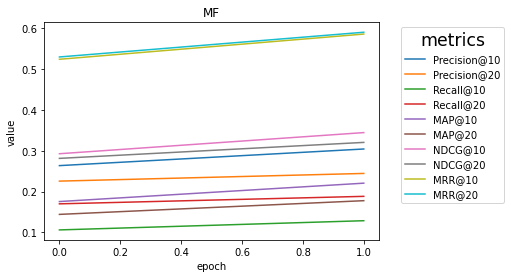

set tensorflow seed
set pytorch seed
doing Caser lr=0.001_l2_reg=1e-6_emb_size=50_seq_L=5_seq_T=3_nv=4_nh=16_dropout=0.5_neg_samples=3_batch_size=512_epochs=1_param_init=normal
2020-11-01 08:38:42.994: my pid: 20948
2020-11-01 08:38:42.995: model: model.sequential_recommender.pytorch.Caser
2020-11-01 08:38:42.997: Dataset statistics:
Name: ml-100k_ratio_u5_i5
The number of users: 943
The number of items: 1349
The number of ratings: 99287
Average actions of users: 105.29
Average actions of items: 73.60
The sparsity of the dataset: 92.195075%

The number of training: 69918
The number of validation: 0
The number of testing: 29369
2020-11-01 08:38:42.999: NeuRec:[NeuRec]:
recommender=Caser
platform=pytorch
data_dir='dataset\ml-100k_ratio_u5_i5'
file_column=UIRT
sep='\t'
gpu_id=0
gpu_mem=0.99
metric=["Precision", "Recall", "MAP", "NDCG", "MRR"]
top_k=[10,20]
test_thread=4
test_batch_size=64
seed=2020

Caser:[hyperparameters]:
lr=0.001
l2_reg=1e-6
emb_size=50
seq_L=5
seq_T=3
nv=4
nh=16
dropo

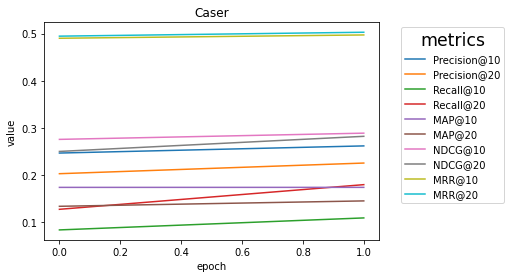

[   {   'MF': {   'MAP@10': [0.17562166, 0.2206445],
                  'MAP@20': [0.14417578, 0.17776126],
                  'MRR@10': [0.524087, 0.58585095],
                  'MRR@20': [0.52975166, 0.59031165],
                  'NDCG@10': [0.2927482, 0.34451437],
                  'NDCG@20': [0.28135666, 0.32049936],
                  'Precision@10': [0.2636268, 0.3043482],
                  'Precision@20': [0.225663, 0.24448615],
                  'Recall@10': [0.10615417, 0.12869696],
                  'Recall@20': [0.17002396, 0.1883594]}},
    {   'Caser': {   'MAP@10': [0.17385097, 0.17390497],
                     'MAP@20': [0.1337153, 0.14516118],
                     'MRR@10': [0.4901524, 0.49718723],
                     'MRR@20': [0.49461257, 0.5029165],
                     'NDCG@10': [0.27566516, 0.2888613],
                     'NDCG@20': [0.2500864, 0.2821757],
                     'Precision@10': [0.24665971, 0.26182416],
                     'Precision@20': [0.202863

In [29]:
from datetime import datetime
path = 'C:/Projects/NeuRec/results/' + datetime.now().strftime('%Y%m%d%H%M%S')
os.mkdir(path)

results = []
general = ['MF']  # , 'CDAE', 'LightGCN', 'MultVAE', 'NGCF']  ##',FISM']
sequential = ['Caser']  # , 'FPMC', 'HGN', 'TransRec']
for algo in [*general, *sequential]:
    result, metrics = evaluate(algorithm, path)
    myplot(result, metrics, algorithm, path)
    results.append(result)

pp.pprint(results)

[{'Precision@10': [0.2636268, 0.3043482], 'Precision@20': [0.225663, 0.24448615], 'Recall@10': [0.10615417, 0.12869696], 'Recall@20': [0.17002396, 0.1883594], 'MAP@10': [0.17562166, 0.2206445], 'MAP@20': [0.14417578, 0.17776126], 'NDCG@10': [0.2927482, 0.34451437], 'NDCG@20': [0.28135666, 0.32049936], 'MRR@10': [0.524087, 0.58585095], 'MRR@20': [0.52975166, 0.59031165]}]


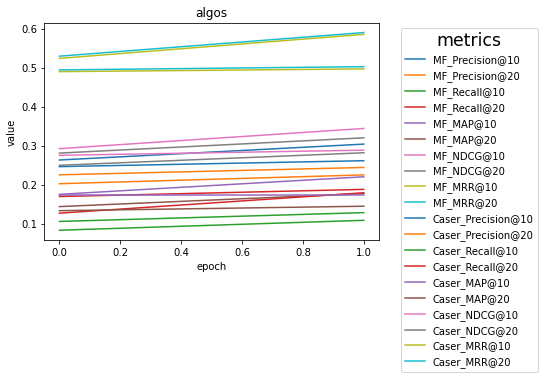

In [111]:
#print(val)
print(list(results[0].values()))

for result in results:
    for metric in metrics:
        algo = list(result)[0]
        title=algo + '_' + metric
        key, val = next(iter(result.items()))
        plt.plot(list(range(len(val[metric]))), val[metric], label=title)
    
plt.xlabel('epoch')
plt.ylabel('value')
plt.title('algos')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='metrics', title_fontsize='xx-large')
plt.show()

[0.2636268, 0.3043482]


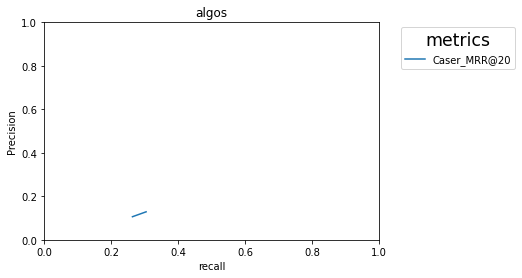

In [123]:
zero = list(results[0].values())[0]
print(zero['Precision@10'])


plt.plot(zero['Precision@10'], zero['Recall@10'], label=title)
    
plt.xlabel('recall')
plt.ylabel('Precision')
plt.title('algos')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='metrics', title_fontsize='xx-large')
plt.ylim(ymin=0, ymax=1)
plt.xlim(xmin=0, xmax=1)

plt.show()


In [4]:
Recall = [0.06133914 ,0.08234998 ,0.09993057 ,0.11031145 ,0.11553573 ,0.12674309 ,0.14646478 ,0.15425973 ,0.16007262 ,0.16310142 ,0.16401586 ,0.16811287 ,0.17034362 ,0.17167576 ,0.17593458 ,0.17597014 ,0.17825405 ,0.18036194 ,0.18239872 ,0.18327251 ,0.18352164 ,0.18581910 ,0.18584922 ,0.18840487 ,0.18795103 ,0.18876661 ,0.18950734 ,0.19043197 ,0.19252305 ,0.19354270 ,0.19493334 ,0.19547443 ,0.19652587 ,0.19902892 ,0.19831845 ,0.19893278 ,0.19853133 ,0.19953048 ,0.20100395 ,0.20321748 ,0.20027682 ,0.20298713 ,0.20185058 ,0.20354658 ,0.20334865 ,0.20559074 ,0.20633247 ,0.20735097 ,0.20628157 ,0.20906140 ,0.20888053 ,0.20888497 ,0.21123388 ,0.20930625 ,0.21003093 ,0.20852250 ,0.21034612 ,0.21021202 ,0.21221195 ,0.20901249 ,0.20944552 ,0.21066712 ,0.20966618 ,0.21140441 ,0.21052983 ,0.20964016 ,0.21126300 ,0.21147904 ,0.21141955 ,0.21039563 ,0.21253696 ,0.21140215 ,0.21238491 ,0.21403581 ,0.21314186 ,0.21199033 ,0.21119429 ,0.21253444 ,0.21103965 ,0.21223217 ,0.21150208 ,0.21366608 ,0.21363710 ,0.21268204 ,0.21073306 ,0.21336803 ,0.21267012 ,0.21025422 ,0.21212502 ,0.21218462 ,0.21095994 ,0.21202281 ,0.21230610 ,0.21147157 ,0.21029645 ,0.21074075 ,0.20972694 ,0.21163534 ,0.21001025 ,0.21093273 ,0.20814483 ,0.20925735 ,0.20872198 ,0.21060908 ,0.20889406 ,0.20723905 ,0.20692116 ,0.20850077 ,0.20648223 ,0.20931633 ,0.20874950 ,0.20712015 ,0.20814817 ,0.20608713 ,0.20622450 ,0.20620143 ,0.20505492 ,0.20788303 ,0.20623562 ,0.20642781 ,0.20486507 ,0.20645992 ,0.20671821 ,0.20646665 ,0.20547917 ,0.20542186 ,0.20496084 ,0.20575285 ,0.20576537 ,0.20258090 ,0.20317665 ,0.20446594 ,0.20362307 ,0.20286420 ,0.20452169 ,0.20425765 ,0.20226713 ,0.20429853 ,0.20190874 ,0.20294374 ,0.20360248 ,0.20337136 ,0.20126335 ,0.20499806 ,0.20358594 ,0.20239162 ,0.20185590 ,0.20073475 ,0.19923131 ,0.20223749 ,0.20097220 ,0.20006086 ,0.20154782 ,0.19993304 ,0.20050184 ,0.20137949 ,0.20096132 ,0.20122100 ,0.19908193 ,0.20026414 ,0.20186342 ,0.19967078 ,0.19985262 ,0.20045806 ,0.20120285 ,0.19977665 ,0.19903044 ,0.20097107 ,0.20018169 ,0.20072772 ,0.20203395 ,0.19831687 ,0.19822648 ,0.19873455 ,0.20005120 ,0.20018926 ,0.19929750 ,0.19896854 ,0.19847167 ,0.19936620 ,0.19927469 ,0.19817115 ,0.19868408 ,0.20011376 ,0.20036623 ,0.19831932 ,0.19898143 ,0.19920826 ,0.19869091 ,0.19927020 ,0.20027000 ,0.20048730 ,0.19862917 ,0.19894609 ,0.19925167 ,0.19940449 ,0.20056702 ,0.20037735 ,0.19857471 ,0.19883141 ,0.19994082 ,0.19775659 ,0.19982824 ,0.20000586 ,0.20011282 ,0.20030531 ,0.19858399 ,0.19834997 ,0.19842793 ,0.20085762 ,0.19958231 ,0.19890901 ,0.19985603 ,0.19939490 ,0.19862556 ,0.19902717 ,0.19962844 ,0.19916341 ,0.20019431 ,0.19880275 ,0.19835344 ,0.19980204 ,0.19882099 ,0.19757469 ,0.19875622 ,0.19910236 ,0.19882807 ,0.19923271 ,0.19968872 ,0.19864388 ,0.19981134 ,0.19851360 ,0.20046899 ,0.19781324 ,0.19818833 ,0.19756633 ,0.19764403 ,0.19867380 ,0.19799440 ,0.19860685 ,0.19994931 ,0.19676852 ,0.19887288 ,0.19830909 ,0.19800158 ,0.19855979 ,0.19969605 ,0.19803776 ,0.19752452 ,0.20054509 ,0.19828515 ,0.19896637 ,0.20002875 ,0.19988796 ,0.19855811 ,0.20012014 ,0.19684349 ,0.19888633 ,0.19862151 ,0.19963853 ,0.19943947 ,0.20023313 ,0.19944265 ,0.19896729 ,0.20017135 ,0.20021544 ,0.20021100 ,0.19870225 ,0.19981194 ,0.19919460 ,0.19946499 ,0.20058775 ,0.19701108 ,0.19894317 ,0.19753894 ,0.19963114 ,0.19851591 ,0.19819531 ,0.19928449 ,0.19879426 ,0.19828360 ,0.19916268 ,0.20002456 ,0.19997932 ,0.19955225 ,0.20084234 ,0.19926994 ,0.20079544 ,0.19777800 ,0.19802849 ,0.19948739 ,0.19848189 ,0.20094605 ,0.20054737 ,0.19888744 ,0.19941473 ,0.20039919 ,0.19980176 ,0.19879000 ,0.20132457 ,0.20046881 ,0.19860552 ,0.20011061 ,0.20064424 ,0.19833361 ,0.19948219 ,0.19835652 ,0.20037894 ,0.19851173 ,0.19808246 ,0.20009477 ,0.19935179 ,0.19925331 ,0.19932261 ,0.19740887 ,0.19908759 ,0.19953358 ,0.19856106 ,0.19819206 ,0.19914602 ,0.20063348 ,0.19947647 ,0.20067945 ,0.19841889 ,0.19979845 ,0.19910873 ,0.19764560 ,0.19926189 ,0.19887400 ,0.19965951 ,0.19787540 ,0.19886905 ,0.19789195 ,0.19923180 ,0.20013575 ,0.19925737 ,0.19935401 ,0.19888930 ,0.19762859 ,0.19964530 ,0.20024997 ,0.19997793 ,0.19926399 ,0.20093925 ,0.20027214 ,0.20204118 ,0.20094405 ,0.20068607 ,0.19932957 ,0.19946671 ,0.19796439 ,0.19791666 ,0.19960424 ,0.19675235 ,0.19823660 ,0.19886495 ,0.19684896 ,0.19785781 ,0.20056620 ,0.19758001 ,0.19912173 ,0.19823176 ,0.19764145 ,0.19758245 ,0.19813503 ,0.19863461 ,0.19793963 ,0.19902846 ,0.19797306 ,0.19787009 ,0.19893253 ,0.19864291 ,0.19840570 ,0.19867036 ,0.20005646 ,0.20013762 ,0.19883005 ,0.20009431 ,0.19899176 ,0.19923180 ,0.20060235 ,0.19992597 ,0.20091999 ,0.19912007 ,0.19905849 ,0.19832635 ,0.19962074 ,0.19942655 ,0.19965628 ,0.19887382 ,0.19938783 ,0.19869900 ,0.19877335 ,0.19985920 ,0.20013447 ,0.20011936 ,0.20029287 ,0.20210657 ,0.20132466 ,0.20009895 ,0.20095831 ,0.19955964 ,0.20112191 ,0.20140626 ,0.20018168 ,0.20005201 ,0.20024422 ,0.20020518 ,0.20014547 ,0.20029011 ,0.20043802 ,0.20017621 ,0.19959450 ,0.20010050 ,0.19990826 ,0.20002027 ,0.20073277 ,0.19972730 ,0.19935167 ,0.19967055 ,0.20091140 ,0.19917285 ,0.19877042 ,0.19903043 ,0.19892266 ,0.19978772 ,0.20030351 ,0.19876927 ,0.19870009 ,0.19945653 ,0.19914234 ,0.19987027 ,0.19966607 ,0.19930068 ,0.20067960 ,0.20049235 ,0.19941358 ,0.20047566 ,0.20059285 ,0.19963177 ,0.19856344 ,0.20013726 ,0.19881344 ,0.19922903 ,0.20182016 ,0.20002438 ,0.19934051 ,0.19970453 ,0.19846882 ,0.19811378 ,0.19826990 ,0.19956407 ,0.19992474 ,0.19993167 ,0.20015275 ,0.19913091 ,0.20027447 ,0.19915438 ,0.19939446 ,0.19986795 ,0.19941421 ,0.19881712 ,0.19986971 ,0.19927353 ,0.19941330 ,0.20029348 ,0.19861832 ,0.19981521 ,0.19955768 ,0.19992679 ,0.19952527 ,0.20013662 ,0.19955757 ,0.20053796 ,0.19935186 ,0.20027022 ,0.20026638 ,0.20064165 ,0.20092374 ,0.19928117 ,0.19977982 ,0.20001146 ,0.19965912 ,0.19947653 ,0.19973773 ,0.19983815 ,0.19974175 ,0.19987953 ,0.20026186 ,0.20000446 ,0.20022568 ,0.19977160 ,0.19990736 ,0.19925386 ,0.19969523 ,0.19972478 ,0.20051983 ,0.20118292 ,0.19968398 ,0.20093943 ,0.19972681 ,0.20113745 ,0.19947419 ,0.19919477 ,0.19925594 ,0.19974037 ,0.19896209 ,0.19978638 ,0.19977710 ,0.20072769 ,0.20010763 ,0.19950646 ,0.20024849 ,0.19955175 ,0.19955993 ,0.20077971 ,0.19997126 ,0.20123799 ,0.19971056 ,0.20104271 ,0.20102182 ,0.19964339 ,0.19895339 ,0.20049717 ,0.20134322 ,0.20033373 ,0.19843109 ,0.19994679 ,0.20084296 ,0.20127252 ,0.19987614 ,0.19972834 ,0.20109288 ,0.20004308 ,0.19922772 ,0.20067203 ,0.20075466 ,0.20089559 ,0.20092230 ,0.19951017 ,0.19948715 ,0.20161416 ,0.20183185 ,0.19999662 ,0.20123838 ,0.19944343 ,0.19889666 ,0.20012757 ,0.19971547 ,0.20113643 ,0.20064722 ,0.19939412 ,0.19926175 ,0.20033400 ,0.19964013 ,0.19984122 ,0.19980748 ,0.20191835 ,0.19999652 ,0.20133755 ,0.19992810 ,0.20018952 ,0.19904661 ,0.19944732 ,0.19999585 ,0.20023821 ,0.20052814 ,0.20077971 ,0.19967605 ,0.19940406 ,0.20003635 ,0.20032208 ,0.20082322 ,0.19986519 ,0.20009200 ,0.19908327 ,0.19954745 ,0.19917794 ,0.19951302 ,0.19884476 ,0.20030706 ,0.19951181 ,0.19962470 ,0.19943351 ,0.19962996 ,0.20012236 ,0.20003211 ,0.19807319 ,0.19884945 ,0.19861464 ,0.19927566 ,0.19973132 ,0.19975905 ,0.19913663 ,0.20083931 ,0.20119298 ,0.20112455 ,0.19998060 ,0.19968654 ,0.19825202 ,0.19885053 ,0.19804022 ,0.19770414 ,0.19879481 ,0.19879803 ,0.19907507 ,0.19974652 ,0.19929953 ,0.19865099 ,0.19977267 ,0.19935152 ,0.20051405 ,0.19999053 ,0.20006801 ,0.20030691 ,0.20004655 ,0.20136189 ,0.20173116 ,0.20054248 ,0.19961450 ,0.19908418 ,0.19953769 ,0.20004551 ,0.19897026 ,0.19954877 ,0.19953685 ,0.19965693 ,0.20058882 ,0.20096329 ,0.20012121 ,0.20100769 ,0.20089832 ,0.20058587 ,0.20128697 ,0.20091428 ,0.19966006 ,0.19970748 ,0.19931370 ,0.20116308 ,0.20015354 ,0.19933668 ,0.20061050 ,0.20052555 ,0.20094956 ,0.20039737 ,0.20100069 ,0.20024320 ,0.20090193 ,0.19988561 ,0.20031713 ,0.20160201 ,0.20133880 ,0.20005162 ,0.19966763 ,0.20012084 ,0.20017220 ,0.20190321 ,0.19979902 ,0.19886376 ,0.20006798 ,0.20123488 ,0.20014757 ,0.19966577 ,0.20058022 ,0.19941722 ,0.19914757 ,0.20048429 ,0.20011073 ,0.20051213 ,0.19967629 ,0.19917566 ,0.20041323 ,0.20046549 ,0.20094253 ,0.19930629 ,0.20027177 ,0.20009002 ,0.19824766 ,0.19888359 ,0.20101251 ,0.20004478 ,0.19892819 ,0.19871236 ,0.19860074 ,0.19950941 ,0.19864379 ,0.19855528 ,0.19811970 ,0.19863161 ,0.19932069 ,0.19909848 ,0.19935387 ,0.19935907 ,0.19905329 ,0.19941804 ,0.19983889 ,0.19912571 ,0.20016654 ,0.20080976 ,0.19920261 ,0.19835818 ,0.19903666 ,0.20061891 ,0.19924086 ,0.19943264 ,0.19815631 ,0.19964999 ,0.19880046 ,0.19876719 ,0.19738631 ,0.19980249 ,0.19988734 ,0.20017302 ,0.19799320 ,0.19797350 ,0.19919005 ,0.19879262 ,0.19927606 ,0.19939570 ,0.19954707 ,0.19957645 ,0.19877516 ,0.19991422 ,0.19915919 ,0.20050599 ,0.19931985 ,0.20133896 ,0.20078933 ,0.19929998 ,0.19927390 ,0.19914377 ,0.19859570 ,0.19853450 ,0.19857100 ,0.19739166 ,0.19931965 ,0.19786048 ,0.20019267 ,0.19992071 ,0.20061518 ,0.20002583 ,0.20102526 ,0.20024902 ,0.20067918 ,0.19929726 ,0.20006955 ,0.20110841 ,0.19962253 ,0.19966502 ,0.19912450 ,0.20069852 ,0.20136188 ,0.20012063 ,0.20021050 ,0.20140097 ,0.20099849 ,0.19901155 ,0.19786195 ,0.19945136 ,0.19975305 ,0.20092469 ,0.19964810 ,0.19914475 ,0.19866058 ,0.19930084 ,0.19972897 ,0.19904126 ,0.19939850 ,0.20095398 ,0.20045474 ,0.19975056 ,0.20019551 ,0.20041792 ,0.19993886 ,0.19860506 ,0.20119047 ,0.19873182 ,0.20095375 ,0.20026986 ,0.20004337 ,0.20083766 ,0.20002575 ,0.19965240 ,0.20091660 ,0.20164029 ,0.20234577 ,0.20140205 ,0.20193216 ,0.20195955 ,0.20133874 ,0.20066492 ,0.20011644 ,0.20043442 ,0.20073026 ,0.19996770 ,0.20055708 ,0.20152768 ,0.20058128 ,0.20009011 ,0.19916582 ,0.19934289 ,0.19949844 ,0.20006803 ,0.20052436 ,0.20135814 ,0.19979681 ,0.20002028 ,0.20219834 ,0.20029736 ,0.19993892 ,0.19973297 ,0.19946434 ,0.20059867 ,0.20034066 ,0.20195669 ,0.20085767 ,0.20048635 ,0.19857608 ,0.20007321 ,0.19862358 ,0.19966297 ,0.19876105 ,0.19956401 ,0.19902363 ,0.19817822 ,0.19744729 ,0.19839644 ,0.19948852 ,0.19995360 ,0.19855601 ,0.19952346 ,0.20040336 ,0.20098205 ,0.19986910 ,0.19992767 ,0.20106602 ,0.20062912 ,0.20017885 ,0.19904645 ,0.19993901 ,0.20020933 ,0.20022871 ,0.20007576 ,0.19975676 ,0.19986211 ,0.20101598 ,0.20005624 ,0.20077662 ,0.19964927 ,0.20000125 ,0.20007437 ,0.20053314 ,0.19828568 ,0.19895943 ,0.20027499 ,0.20026149 ,0.20021626 ,0.19994667 ,0.20021619 ,0.19895223 ,0.20044127 ,0.19953518 ,0.19920065 ,0.19921179 ,0.19966257 ,0.20008080 ,0.20071104 ,0.20006710 ,0.20060201 ,0.19936894 ,0.19883779 ,0.19861431 ,0.19973460 ,0.20016176 ,0.19958583 ,0.19923897 ,0.20001645 ,0.19955565 ,0.19984019 ,0.20102298 ,0.19937901 ,0.19948094 ,0.19932759 ,0.19948539 ,0.19852318 ,0.19891372 ,0.20047410 ,0.19952673 ,0.19975558 ,0.20049176 ,0.19990534 ,0.19946957 ,0.19911258 ,0.19914934 ,0.20133898 ,0.20119876 ,0.20054102 ,0.20080610 ,0.20064707 ,0.20016053 ,0.20060711 ,0.20032740 ,0.20013390 ,0.20102838 ,0.20140429 ,0.20171826 ,0.19962166 ,0.20130846 ,0.20190424 ,0.20110062 ,0.19966362 ,0.20021269 ,0.20007932 ,0.20075823 ,0.20074180 ,0.20108671 ,0.20112370 ,0.20075127 ,0.20150658 ,0.20067786 ,0.19950452 ,0.20028844 ,0.19905423 ,0.20048313 ,0.19892281 ,0.19908747 ,0.20034175 ,0.19921942 ,0.20038038 ,0.19991705 ,0.20094864 ,0.20187780 ,0.19922486 ,0.19914763 ,0.19985144 ,0.19923675 ,0.20001824 ,0.20083085 ,0.20050313 ,0.20131056 ,0.20121108 ,0.20026456 ,0.20043865 ,0.20049661 ,0.20219432 ,0.20129767 ,0.20131625 ,0.20084317 ,0.20051765 ,0.20080045 ,0.20232098 ,0.20028645 ,0.19924566 ,0.19934168 ,0.19996651 ,0.19879802 ,0.20004767 ,0.19940218 ,0.19936933 ,0.19968879 ,0.19966523 ,0.20007581 ,0.20050485 ,0.20006575 ,0.20015803 ,0.20092526 ,0.20036070 ,0.19972219 ,0.20106331 ,0.20066722 ,0.20085980 ,0.20130323 ,0.20039380 ,0.19869661 ,0.19890077 ,0.20001163 ,0.19938496 ,0.19945689 ,0.19960204 ,0.19935800 ,0.19974661 ,0.19906436 ,0.19926001 ,0.19870026 ,0.19839083 ,0.19978358 ,0.20117387 ,0.19936296 ,0.20080476 ,0.19942909 ,0.19989063 ,0.19916837 ,0.20103283 ,0.20104754 ,0.20091847 ,0.20008484 ,0.20097616 ,0.20045978 ,0.20095174 ,0.20166774 ,0.20139168 ,0.20059359 ,0.20071825 ,0.20115088 ,0.20134361 ,0.20192443 ,0.20086575 ,0.20153804 ,0.20117076 ,0.20039421 ,0.20075732 ,0.20165397 ,0.20062746 ,0.20099556 ,0.20080811 ,0.20084788 ,0.20052500 ,0.19984721 ,0.19939585 ,0.20059189 ,0.20172016 ,0.20063536 ,0.19968288 ,0.20112234 ,0.20030855 ,0.19976756 ,0.20058160 ,0.20064080 ,0.19931234 ,0.19931085 ,0.19999753 ,0.19996387 ,0.20092863 ,0.20002201 ,0.20127405 ,0.20205148 ,0.20233996 ,0.20164576 ,0.20031123 ,0.20249864 ,0.20050238 ,0.20096678 ,0.20120989 ,0.20161800 ,0.20219865 ,0.20157337 ,0.20033164 ,0.20103310 ,0.20123060 ,0.20207140 ,0.20019554 ,0.20078883 ,0.20106511 ,0.20086712 ,0.20112829 ,0.20167963 ,0.20110625 ,0.20057368 ,0.20018384 ,0.20069377 ,0.20002544 ,0.19950388 ,0.19930175 ,0.19902603 ,0.19895223 ,0.20132585 ,0.20038876 ,0.20009547 ,0.20034361 ,0.20113370 ,0.20189524 ,0.20171440 ,0.20055196 ,0.20007588 ,0.20051564 ,0.20053698 ,0.19925094 ,0.20004807 ,0.19963935 ,0.19893399 ,0.19947988 ,0.19949965 ,0.19921710 ,0.19978680 ,0.20099151 ,0.20111638 ,0.20030268 ,0.20014909 ,0.20015055 ,0.20108613 ,0.20179676 ,0.19965370 ,0.20029610 ,0.19898744 ,0.20151992 ,0.20062464 ,0.20057888 ,0.19966884 ,0.20068894 ,0.20132053 ,0.19980115 ,0.19988962 ,0.20112512 ,0.20138444 ,0.20220897 ,0.20208989 ,0.20179312 ,0.20155133 ,0.20168141 ,0.20094036 ,0.20165913 ,0.20162876 ,0.20098308 ,0.20120895 ,0.20077598 ,0.20156717 ,0.20068084 ,0.20101134 ,0.20019910 ,0.19982381 ,0.20051761 ,0.20136707 ,0.20148790 ,0.20128144 ,0.20216441 ,0.20154220 ,0.20225978 ,0.20051266 ,0.20172669 ,0.20144093 ,0.20212798 ,0.20170230 ,0.20047511 ,0.20155425 ,0.20145305 ,0.20198151 ,0.20245336 ,0.20065045 ,0.20083180 ,0.20179315 ,0.20111707 ,0.20149337 ,0.20181088 ,0.20048337 ,0.20021430 ,0.20056714 ,0.20113502 ,0.19975680 ,0.20101289 ,0.20121486 ,0.20247710 ,0.20167714 ,0.20068231 ,0.20065083 ,0.20069455 ,0.19979729 ,0.19984302 ,0.20037466 ,0.20045377 ,0.19940457 ,0.20139061 ,0.20165059 ,0.20027247 ,0.20186523 ,0.20239767 ,0.20178430 ,0.20105515 ,0.20095435 ,0.20065938 ,0.20183577 ,0.20007297 ,0.20190413 ,0.20114933 ,0.20129520 ,0.20198266 ,0.20106189 ,0.20161796 ,0.20180346 ,0.20307748 ,0.20161825 ,0.20307890 ,0.20164303 ,0.20207508 ,0.20303492 ,0.20235465 ,0.20206231 ,0.20455676 ,0.20227389 ,0.20017233 ,0.20135142 ,0.20155828 ,0.20114399 ,0.20083636 ,0.20081985 ,0.20102295 ,0.20152281 ,0.20247954 ,0.20149280 ,0.20135368 ,0.20112379 ,0.20137501 ,0.20170708 ,0.20110571 ,0.20115514 ,0.20239420 ,0.20155536 ,0.20046042 ,0.20096689 ,0.20134540 ,0.20169011 ,0.20166111 ,0.20149586 ,0.20097734 ,0.20060523 ,0.20083222 ,0.20017521 ,0.20068036 ,0.19977233 ,0.20108855 ,0.20036617 ,0.19952598 ,0.20066123 ,0.20063606 ,0.20109631 ,0.20219678 ,0.20140238 ,0.20264497 ,0.20207296 ,0.20253637 ,0.20220800 ,0.20173192 ,0.20281553 ,0.20198582 ,0.20145135 ,0.20152892 ,0.20144504 ,0.20083565 ,0.20014666 ,0.20197156 ,0.20124395 ,0.20133398 ,0.20189697 ,0.20168571 ,0.20111318 ,0.20085847 ,0.20195535 ,0.20139962 ,0.20063257 ,0.20071580 ,0.20082915 ,0.20132917 ,0.20080875 ,0.20125023 ,0.20165651 ,0.20157407 ,0.20154662 ,0.20134871 ,0.20168577 ,0.20196296 ,0.20226245 ,0.20146553 ,0.19922350 ,0.19992167 ,0.19959496 ,0.20034504 ,0.20056738 ,0.20138627 ,0.20126267 ,0.20040856 ,0.20024630 ,0.20196953 ,0.20090675 ,0.20186742 ,0.20107426 ,0.20118891 ,0.20319697 ,0.20281103 ,0.20258586 ,0.20187871 ,0.20081326 ,0.20160307 ,0.20188120 ,0.20133533 ,0.20076859 ,0.20129983 ,0.20084168 ,0.20108427 ,0.20043609 ,0.20061859 ,0.20096603 ,0.20111151 ,0.20051779 ,0.20000173 ,0.20126303 ,0.20189154 ,0.20106870 ,0.20110032 ,0.20064013 ,0.20051217 ,0.19985403 ,0.20023875 ,0.20035660 ,0.20041086 ,0.20052527 ,0.19998175 ,0.19885029 ,0.20053485 ,0.20073490 ,0.20144612 ,0.20042616 ,0.19946036 ,0.20068757 ,0.19982421 ,0.20027955 ,0.20024648 ,0.19996795 ,0.19888441 ,0.19960092 ,0.20033073 ,0.19979230 ,0.20092691 ,0.20030168 ,0.20090713 ,0.20033264 ,0.20126730 ,0.20039986 ,0.20101601 ,0.20073822 ,0.20163974 ,0.20021521 ,0.20001189 ,0.20161307 ,0.20207548 ,0.20027527 ,0.20047206 ,0.20086429 ,0.20024145 ,0.20032023 ,0.20229441 ,0.20186748 ,0.20075706 ,0.20098007 ,0.20124745 ,0.20070305 ,0.20175354 ,0.20224455 ,0.20227702 ,0.20215006 ,0.20220682 ,0.20302916 ,0.20221049 ,0.20151135 ,0.20139129 ,0.20208691 ,0.20107089 ,0.20183727 ,0.20195465 ,0.20314196 ,0.20204897 ,0.20161438 ,0.20260081 ,0.20209241 ,0.20258754 ,0.20357203 ,0.20306352 ,0.20258035 ,0.20272492 ,0.20220880 ,0.20303556 ,0.20238633 ,0.20253502 ,0.20209408 ,0.20154411 ,0.20138641 ,0.20098040 ,0.20163353 ,0.20244929 ,0.20243695 ,0.20184506 ,0.20189014 ,0.20149283 ,0.20287754 ,0.20100966 ,0.20193097 ,0.20184851 ,0.20201077 ,0.20249243 ,0.20240669 ,0.20254821 ,0.20283510 ,0.20401150 ,0.20207372 ,0.20194873 ,0.20194815 ,0.20172206 ,0.20169771 ,0.20278811 ,0.20276245 ,0.20177248 ,0.20170003 ,0.20225523 ,0.20250265 ,0.20242764 ,0.20262165 ,0.20227198 ,0.20099610 ,0.20283034 ,0.20222209 ,0.20197882 ,0.20176530 ,0.20254196 ,0.20211352 ,0.20240086 ,0.20076776 ,0.20093450 ,0.20168747 ,0.20370634 ,0.20217422 ,0.20135348 ,0.20069143 ,0.20197694 ,0.20243582 ,0.20225649 ,0.20128340 ,0.20161061 ,0.20149362 ,0.20127508 ,0.20157504 ,0.20164882 ,0.20064230 ,0.20237422 ,0.20282944 ,0.20149788 ,0.20201060 ,0.20185760 ,0.20112546 ,0.19961457 ,0.20079026 ,0.20218940 ,0.20109691 ,0.20130350 ,0.20153953 ,0.20200279 ,0.20114869 ,0.20163038 ,0.20235418 ,0.20140402 ,0.20026067 ,0.20028925 ,0.20170714 ,0.20073962 ,0.20171835 ,0.20240828 ,0.20199291 ,0.20242830 ,0.20159850 ,0.20225841 ,0.20181803 ,0.20234685 ,0.20182557 ,0.20285127 ,0.20210525 ,0.20118546 ,0.20167214 ,0.20027159 ,0.20206872 ,0.20226523 ,0.20136344 ,0.20212694 ,0.20188586 ,0.20264673 ,0.20244807 ,0.20115972 ,0.20195836 ,0.20310239 ,0.20102252 ,0.20177819 ,0.20071337 ,0.20057327 ,0.20149067 ,0.20071158 ,0.20168056 ,0.20145860 ,0.20189984 ,0.20127460 ,0.20122658 ,0.20197746 ,0.20184410 ,0.20085052 ,0.20123516 ,0.20127451 ,0.20114730 ,0.20127480 ,0.20236616 ,0.20279060 ,0.20161235 ,0.20133300 ,0.20100930 ,0.20033327 ,0.20122591 ,0.20169659 ,0.20163241 ,0.20218843 ,0.20171148 ,0.20145603 ,0.20127004 ,0.20233561 ,0.20222668 ,0.20108412 ,0.20143174 ,0.20080566 ,0.20111953 ,0.20257795 ,0.20181955 ,0.20181641 ,0.20120107 ,0.20248567 ,0.20403424 ,0.20221426 ,0.20186946 ,0.20101927 ,0.20135324 ,0.20213197 ,0.20210375 ,0.20303634 ,0.20265251 ,0.20321162 ,0.20359869 ,0.20251930 ,0.20372221 ,0.20244715 ,0.20136009 ,0.20157516 ,0.20009835 ,0.20118289 ,0.20110254 ,0.20149010 ,0.20117357 ,0.20071124 ,0.20213547 ,0.20137201 ,0.20111349 ,0.20226935 ,0.20246427 ,0.20237274 ,0.20231716 ,0.20110410 ,0.20119838 ,0.20313384 ,0.20255232 ,0.20303193 ,0.20116907 ,0.20258126 ,0.20131436 ,0.20298216 ,0.20220844 ,0.20259400 ,0.20209649 ,0.20412776 ,0.20380524 ,0.20240165 ,0.20271638 ,0.20254214 ,0.20276125 ,0.20169391 ,0.20178355 ,0.20167188 ,0.20208703 ,0.20143388 ,0.20206852 ,0.20150939 ,0.20235060 ,0.20236915 ,0.20113705 ,0.20098054 ,0.20170388 ,0.20115246 ,0.20060319 ,0.20169488 ,0.20241098 ,0.20052984 ,0.20139793 ,0.20197201 ,0.20329081 ,0.20140691 ,0.20284766 ,0.20223163 ,0.20164613 ,0.20115881 ,0.20185864 ,0.20090981 ,0.20161161 ,0.20256574 ,0.20231263 ,0.20196621 ,0.20123219 ,0.20139676 ,0.20078743 ,0.20110863 ,0.20134439 ,0.20103131 ,0.20094632 ,0.20068210 ,0.20102613 ,0.20268431 ,0.20211111 ,0.20211835 ,0.20209515 ,0.20107502 ,0.20178670 ,0.20159873 ,0.20193608 ,0.20285004 ,0.20288686 ,0.20112255 ,0.20101017 ,0.20098846 ,0.20256543 ,0.20153169 ,0.20208125 ,0.20154443 ,0.20132847 ,0.20322169 ,0.20223555 ,0.20192458 ,0.20183660 ,0.20197219 ,0.20274656 ,0.20189108 ,0.20128384 ,0.20189725 ,0.20181751 ,0.20256621 ,0.20214622 ,0.20172186 ,0.20226420 ,0.20203538 ,0.20286481 ,0.20157272 ,0.20221131 ,0.20212324 ,0.20160839 ,0.20149691 ,0.20071130 ,0.20234872 ,0.20125081 ,0.20283516 ,0.20156111 ,0.20154718 ,0.20199084 ,0.20268242 ,0.20170085 ,0.20118339 ,0.20261915 ,0.20251732 ,0.20171918 ,0.20233713 ,0.20176683 ,0.20161048 ,0.20149796 ,0.20128392 ,0.20168751 ,0.20147090 ,0.20293900 ,0.20156951 ,0.20054662 ,0.20132217 ,0.20157382 ,0.20200580 ,0.20160177 ,0.20145074 ,0.20109075 ,0.20105799 ,0.20092970 ,0.20282380 ,0.20094876 ,0.20159681 ,0.20115164 ,0.20110014 ,0.20023434 ,0.20172340 ,0.20152530 ,0.20149048 ,0.20158705 ,0.20163703 ,0.20042925 ,0.20124774 ,0.20126083 ,0.20193057 ,0.20062968 ,0.20029330 ,0.20054016 ,0.20046523 ,0.20165697 ,0.20150265 ,0.20092525 ,0.20008123 ,0.20072202 ,0.20200802 ,0.20288149 ,0.20204793 ,0.20160699 ,0.20144354 ,0.20208262 ,0.20211388 ,0.20316696 ,0.20280923 ,0.20157336 ,0.20127766 ,0.20197247 ,0.20115879 ,0.20209196 ,0.20146374 ,0.20238784 ,0.20169869 ,0.20206556 ,0.20281555 ,0.20251466 ,0.20308623 ,0.20266749 ,0.20099270 ,0.20128728 ,0.20094447 ,0.20121038 ,0.20123538 ,0.19981024 ,0.19985634 ,0.20075370 ,0.20141634 ,0.20119856 ,0.20090723 ,0.20137627 ,0.20082159 ,0.20100828 ,0.20164880 ,0.20107026 ,0.20035285 ,0.20222963 ,0.20239590 ,0.20305298 ,0.20165752 ,0.20143908 ,0.20102160 ,0.20211948 ,0.20150839 ,0.20153826 ,0.20147806 ,0.20061301 ,0.20080706 ,0.20201094 ,0.20196764 ,0.20099707 ,0.20141661 ,0.20136803 ,0.20092602 ,0.20224784 ,0.20269546 ,0.20216927 ,0.20239602 ,0.20242871 ,0.20202574 ,0.20083275 ,0.20154795 ,0.20132574 ,0.20237246 ,0.20218615 ,0.20107634 ,0.20073307 ,0.20176256 ,0.20092504 ,0.20147799 ,0.20148653 ,0.20142269 ,0.20266646 ,0.20250142 ,0.20168322 ,0.20234656 ,0.20210592 ,0.20172586 ,0.20004383 ,0.20180385 ,0.20174247 ,0.20185325 ,0.20360428 ,0.20306136 ,0.20309965 ,0.20312704 ,0.20339781 ,0.20280600 ,0.20248382 ,0.20218967 ,0.20204532 ,0.20125161 ,0.20109485 ,0.20214485 ,0.20133576 ,0.20296469 ,0.20173040 ,0.20197625 ,0.20070811 ,0.20147544 ,0.20137741 ,0.20057823 ,0.20212770 ,0.20138645 ,0.20135218 ,0.20136203 ,0.20088722 ,0.20156790 ,0.20247947 ,0.20157279 ,0.20029359 ,0.20175149 ,0.20028783 ,0.20090239 ,0.20253256 ,0.20185290 ,0.20157008 ,0.20137811 ,0.20203421 ,0.20196688 ,0.20236278 ,0.20149481 ,0.20077752 ,0.20008950 ,0.20093408 ,0.20064439 ,0.19994195 ,0.20040452 ,0.20194535 ,0.19943516 ,0.20160994 ,0.19990690 ,0.20113605 ,0.20046443 ,0.20078379 ,0.20047888 ,0.20189375 ,0.20220353 ,0.20272224 ,0.20193315 ,0.20235611 ,0.20177323 ,0.20200673 ,0.20221984 ,0.20145524 ,0.20145941 ,0.20227866 ,0.20053020 ,0.20222948 ,0.20108309 ,0.20255907 ,0.20268326 ,0.20148511 ,0.20125160 ,0.20069215 ,0.20221487 ,0.20321108 ,0.20397682 ,0.20334812 ,0.20283964 ,0.20230994 ,0.20300274 ,0.20276704 ,0.20356573 ,0.20279372 ,0.20297278 ,0.20247872 ,0.20244047 ,0.20145750 ,0.20198341 ,0.20163088 ,0.20211379 ,0.20201169 ,0.20206322 ,0.20207621 ,0.20150553 ,0.20205610 ,0.20097202 ,0.20085283 ,0.20107730 ,0.20051569 ,0.20063762 ,0.20160206 ,0.20197354 ,0.20133859 ,0.20122606 ,0.20144215 ,0.20178223 ,0.20206854 ,0.20145461 ,0.20065695 ,0.20102151 ,0.20090954 ,0.20172215 ,0.20140430 ,0.20081261 ,0.20017357 ,0.20066988 ,0.20171511 ,0.20133157 ,0.20160274 ,0.20103951 ,0.20191887 ,0.20147347 ,0.20210744 ,0.20230223 ,0.20200416 ,0.20205215 ,0.20166960 ,0.20194179 ,0.20211130 ,0.20153533 ,0.20076306 ,0.20193721 ,0.20178524 ,0.20083122 ,0.20087343 ,0.20110931 ,0.20153643 ,0.20129368 ,0.20216839 ,0.20289467 ,0.20213318 ,0.20134878 ,0.20115772 ,0.20122102 ,0.20148037 ,0.20225455 ,0.20140822 ,0.20121281 ,0.20121509 ,0.20084663 ,0.20120293 ,0.20112874 ,0.20129813 ,0.20251991 ,0.20266280 ,0.20275840 ,0.20114142 ,0.20114738 ,0.20069756 ,0.20054695 ,0.20072535 ,0.20057024 ,0.20030989 ,0.20093966 ,0.20013724 ,0.20079827 ,0.20012283 ,0.20031238 ,0.19945732 ,0.19926517 ,0.19861072 ,0.19934118 ,0.20037322 ,0.19992267 ,0.20042740 ,0.20014675 ,0.20091015 ,0.20069854 ,0.20108345 ,0.20099492 ,0.20082860 ,0.19977617 ,0.20077880 ,0.20051195 ,0.20061632 ,0.20065074 ,0.20078693 ,0.20030957 ,0.20040324 ,0.20084906 ,0.19950981 ,0.20126809 ,0.20072430 ,0.20075883 ,0.20011990 ,0.20075317 ,0.20044060 ,0.20049798 ,0.20020023 ,0.20006026 ,0.20040096 ,0.20068505 ,0.20051350 ,0.20142642 ,0.20359243 ,0.20147412 ,0.20135108 ,0.20102152 ,0.20244257 ,0.20143260 ,0.20140637 ,0.20149855 ,0.20121296 ,0.20084892 ,0.20150642 ,0.20212930 ,0.20209719 ,0.20279871 ,0.20220067 ,0.20091762 ,0.20202810 ,0.20168102 ,0.20076559 ,0.20046580 ,0.20017706 ,0.20020033 ,0.19981253 ,0.20044222 ,0.19991483 ,0.20122352 ,0.20222096 ,0.20153916 ,0.20232792 ,0.20154023 ,0.20070483 ,0.20155135 ,0.20134561 ,0.20057164 ,0.20070048 ,0.20072868 ,0.20234966 ,0.20128639 ,0.20044975 ,0.20077500 ,0.20069090 ,0.20222221 ,0.20235929 ,0.20136805 ,0.20166695 ,0.20182611 ,0.20224872 ,0.20103522 ,0.20053552 ,0.20152663 ,0.20164037 ,0.20055526 ,0.20016640 ,0.19943599 ,0.20035818 ,0.20073034 ,0.20120445 ,0.20123900 ,0.20201570 ,0.20122319 ,0.20064954 ,0.19919400 ,0.20020530 ,0.20071134 ,0.20037284 ,0.20042694 ,0.20066351 ,0.20033929 ,0.20117582 ,0.20031935 ,0.20242712 ,0.20171513 ,0.20122591 ,0.20207673 ,0.20106281 ,0.20017153 ,0.20028833 ,0.20089093 ,0.19918869 ,0.20016517 ,0.20031300 ,0.19957137 ,0.19883598 ,0.19955990 ,0.19998717 ,0.20078282 ,0.20039193 ,0.20012395 ,0.20174631 ,0.20053288 ,0.20154212 ,0.20111606 ,0.20013611 ,0.20054549 ,0.20022745 ,0.20062229 ,0.20106408 ,0.20109381 ,0.20067221 ,0.20127466 ,0.20177886 ,0.20126826 ,0.20293091 ,0.20265508 ,0.20268226 ,0.20226337 ,0.20132107 ,0.20162529 ,0.20232551 ,0.20153286 ,0.20187303 ,0.20251273 ,0.20158061 ,0.20166527 ,0.20289674 ,0.20138180 ,0.20208482 ,0.20320973 ,0.20213835 ,0.20340575 ,0.20268235 ,0.20284168 ,0.20214196 ,0.20257576 ,0.20166792 ,0.20317599 ,0.20369427 ,0.20318307 ,0.20298518 ,0.20437470 ,0.20340009 ,0.20281266 ,0.20145988 ,0.20168009 ,0.20182867 ,0.20244823 ,0.20177335 ,0.20168750 ,0.20224392 ,0.20173983 ,0.20269124 ,0.20266983 ,0.20250808 ,0.20295204 ,0.20278107 ,0.20211887 ,0.20125948 ,0.20227100 ,0.20274389 ,0.20291586 ,0.20229518 ,0.20188892 ,0.20248239 ,0.20243414 ,0.20214079 ,0.20325875 ,0.20199846 ,0.20230573 ,0.20239411 ,0.20227857 ,0.20212293 ,0.20217294 ,0.20151465 ,0.20157526 ,0.20165029 ,0.20141660 ,0.20084809 ,0.20180190 ,0.20149389 ,0.20201869 ,0.20103595 ,0.20091532 ,0.20200634 ,0.20273453 ,0.20284162 ,0.20182684 ,0.20153922 ,0.20129776 ,0.20150381 ,0.20093136 ,0.20159447 ,0.20242336 ,0.20195740 ,0.20148036 ,0.20166117 ,0.20249707 ,0.20326331 ,0.20202717 ,0.20247252 ,0.20262592 ,0.20161147 ,0.20284450 ,0.20269828 ,0.20141490 ,0.20148306 ,0.20097564 ,0.20157044 ,0.20181742 ,0.20143850 ,0.20229077 ,0.20158306 ,0.20055726 ,0.20094623 ,0.20120534 ,0.20144293 ,0.20060988 ,0.20199008 ,0.20213135 ,0.20070599 ,0.20117047 ,0.20168589 ,0.20197354 ,0.20179729 ,0.20155981 ,0.20256224 ,0.20261724 ,0.20235819 ,0.20255722 ,0.20308067 ,0.20126605 ,0.20267075 ,0.20097251 ,0.20147905 ,0.20096877 ,0.20216185 ,0.20185289 ,0.20110863 ,0.20038180 ,0.20151497 ,0.20076743 ,0.20171505 ,0.20117314 ,0.20173670 ,0.20232666 ,0.20180865 ,0.20028265 ,0.20088910 ,0.20022061 ,0.20145339 ,0.20180944 ,0.20286348 ,0.20237945 ,0.20161219 ,0.20179614 ,0.20067430 ,0.20107697 ,0.20110756 ,0.20158790 ,0.20013085 ,0.20092267 ,0.20109744 ,0.20053822 ,0.20076656 ,0.20119406 ,0.20087063 ,0.20129380 ,0.20132604 ,0.20088066 ,0.20131892 ,0.20150390 ,0.20216231 ,0.20222977 ,0.20236582 ,0.20275125 ,0.20378418 ,0.20205268 ,0.20269053 ,0.20269865 ,0.20313317 ,0.20297128 ,0.20225498 ,0.20187227 ,0.20285720 ,0.20217632 ,0.20228346 ,0.20280203 ,0.20211056 ,0.20322995 ,0.20309879 ,0.20246999 ,0.20180637 ,0.20175429 ,0.20243435 ,0.20228967 ,0.20170164 ,0.20170483 ,0.20162600 ,0.20057097 ,0.20240936 ,0.20160614 ,0.20196040 ,0.20164764 ,0.20134097 ,0.20132323 ,0.20057033 ,0.20118816 ,0.20227413 ,0.20184134 ,0.20180374 ,0.20058136 ,0.20092376 ,0.20143402 ,0.20047453 ,0.19986577 ,0.20019910 ,0.20103920 ,0.19984387 ,0.20064516 ,0.20192525 ,0.20139712 ,0.20055442 ,0.20150697 ,0.20152052 ,0.20120426 ,0.20153326 ,0.20162253 ,0.20122473 ,0.20195952 ,0.20066582 ,0.20175694 ,0.20149168 ,0.20075822 ,0.20185450 ,0.20043328 ,0.20074739 ,0.20100819 ,0.20119344 ,0.20074084 ,0.20037407 ,0.19994897 ,0.20042229 ,0.20021364 ,0.20006742 ,0.19936916 ,0.20021695 ,0.20027158 ,0.20064986 ,0.20068549 ,0.20077810 ,0.19986717 ,0.20105080 ,0.20106213 ,0.20115691 ,0.20230280 ,0.20010144 ,0.20058891 ,0.19898388 ,0.19971414 ,0.20104787 ,0.20093451 ,0.20018987 ,0.20094793 ,0.20005558 ,0.20157538 ,0.20003587 ,0.20089778 ,0.20009835 ,0.20067862 ,0.20145079 ,0.20067509 ,0.20016228 ,0.19977745 ,0.19931287 ,0.19954616 ,0.19955260 ,0.20125122 ,0.20090091 ,0.20060371 ,0.20147760 ,0.20045674 ,0.20124288 ,0.20037697 ,0.20108253 ,0.20027544 ,0.20089918 ,0.20139962 ,0.20208578 ,0.20141327 ,0.20158699 ,0.20183070 ,0.20257549 ,0.20171273 ,0.20177759 ,0.20300646 ,0.20285276 ,0.20207797 ,0.20366634 ,0.20332463 ,0.20287141 ,0.20281716 ,0.20214711 ,0.20256469 ,0.20247614 ,0.20278050 ,0.20240298 ,0.20140749 ,0.20253742 ,0.20141651 ,0.20204972 ,0.20173799 ,0.20102374 ,0.20173922 ,0.20102423 ,0.20143256 ,0.20189174 ,0.20143077 ,0.20197403 ,0.20194983 ,0.20177606 ,0.20072880 ,0.20148584 ,0.20111731 ,0.20083545 ,0.20134684 ,0.20066495 ,0.20121261 ,0.20064184 ,0.20012380 ,0.20030384 ,0.20111229 ,0.19977348 ,0.19960667 ,0.20043294 ,0.20140335 ,0.20087749 ,0.20068730 ,0.20143180 ,0.20100053 ,0.20166087 ,0.20119694 ,0.20131332 ,0.20121874 ,0.20020865 ,0.20221080 ,0.20143470 ,0.20155241 ,0.20143168 ,0.20153871 ,0.20058829 ,0.20098458 ,0.20072754 ,0.20068420 ,0.20014827 ,0.19984074 ,0.19991049 ,0.20059071 ,0.20089927 ,0.20000058 ,0.20035094 ,0.19983213 ,0.20032741 ,0.20050634 ,0.20123793 ,0.20138641 ,0.20086060 ,0.20280699 ,0.20048483 ,0.20097092 ,0.20144375 ,0.20102553 ,0.20118216 ,0.20160423 ,0.20087993 ,0.20144632 ,0.20065209 ,0.20166250 ,0.20104495 ,0.19984503 ,0.19936931 ,0.20058244 ,0.19911885 ,0.20118393 ,0.20012528 ,0.19972783 ,0.19989353 ,0.20063657 ,0.20119512 ,0.20037255 ,0.20047472 ,0.20170771 ,0.20144491 ,0.20099232 ,0.20133372 ,0.20051441 ,0.20071965 ,0.20093146 ,0.20088838 ,0.19936435 ,0.19996007 ,0.20114677 ,0.20031162 ,0.20070316 ,0.20109528 ,0.20166385 ,0.20105109 ,0.20144989 ,0.20150155 ,0.20062694 ,0.20204596 ,0.20071860 ,0.20200114 ,0.20063300 ,0.20217332 ,0.20142800 ,0.20101359 ,0.20207451 ,0.20207585 ,0.20145020 ,0.20143428 ,0.20111910 ,0.20131563 ,0.20123394 ,0.20109527 ,0.20219089 ,0.20138808 ,0.20276296 ,0.20160526 ,0.20113732 ,0.19983728 ,0.20069061 ,0.20101404 ,0.20271043 ,0.20160037 ,0.20307498 ,0.20255579 ,0.20201826 ,0.20193881 ,0.20221776 ,0.20032622 ,0.20014140 ,0.20086646 ,0.20051186 ,0.20091549 ,0.20216085 ,0.20291936 ,0.20115468 ,0.20068289 ,0.20170997 ,0.20051084 ,0.20182863 ,0.20153907 ,0.20181386 ,0.20062797 ,0.20049547 ,0.20133893 ,0.20162514 ,0.20031962 ,0.20143892 ,0.20142029 ,0.20253035 ,0.20152925 ,0.20195618 ,0.20173030 ,0.20206884 ,0.20160998 ,0.20196630 ,0.20149785 ,0.20168628 ,0.20053458 ,0.20117132 ,0.20084243 ,0.20246874 ,0.20210423 ,0.20201816 ,0.20124672 ,0.20216334 ,0.20216608 ,0.20068647 ,0.20102727 ,0.20171811 ,0.20248652 ,0.20164827 ,0.20053312 ,0.20112176 ,0.20109883 ,0.20188268 ,0.20253506 ,0.20309009 ,0.20120671 ,0.20114331 ,0.20153721 ,0.20128392 ,0.20241456 ,0.20232567 ,0.20072135 ,0.20086503 ,0.20153922 ,0.20154130 ,0.20151688 ,0.20124404 ,0.20295392 ,0.20135842 ,0.20118457 ,0.20245025 ,0.20256878 ,0.20236671 ,0.20181200 ,0.20212242 ,0.20146483 ,0.20109439 ,0.20119663 ,0.20168161 ,0.20123310 ,0.20230265 ,0.20217551 ,0.20124210 ,0.20169646 ,0.20167872 ,0.20137559 ,0.20149352 ,0.20058039 ,0.20216298 ,0.20123094 ,0.20110571 ,0.19947477 ,0.20086561 ,0.20030206 ,0.20152517 ,0.20058297 ,0.20152526 ,0.20214380 ,0.20086682 ,0.20153858 ,0.20190597 ,0.20135915 ,0.20167346 ,0.20007034 ,0.20111123 ,0.20168246 ,0.20119518 ,0.20088333 ,0.20088014 ,0.20182851 ,0.20205891 ,0.20155805 ,0.20028090 ,0.20102982 ,0.20038871 ,0.20061894 ,0.20146503 ,0.20204408 ,0.20227404 ,0.20273083 ,0.20286310 ,0.20295998 ,0.20274627 ,0.20144315 ,0.20052268 ,0.20115215 ,0.20148851 ,0.20101443 ,0.20244378 ,0.20181455 ,0.20205984 ,0.19999368 ,0.19935158 ,0.20005478 ,0.20014955 ,0.20038168 ,0.20011562 ,0.20109157 ,0.20084567 ,0.20191379 ,0.20073655 ,0.20054998 ,0.20140798 ,0.20114142 ,0.20103259 ,0.20064069 ,0.20162226 ,0.20165937 ,0.20181908 ,0.20241816 ,0.20295373 ,0.20285963 ,0.20174676 ,0.20280968 ,0.20238057 ,0.20368654 ,0.20307487 ,0.20259075 ,0.20237307 ,0.20240515 ,0.20219156 ,0.20223668 ,0.20122129 ,0.20072696 ,0.20132944 ,0.20102760 ,0.20120910 ,0.20084995 ,0.20063037 ,0.20066489 ,0.20118578 ,0.20186479 ,0.20183401 ,0.20009658 ,0.20125817 ,0.20100927 ,0.20039482 ,0.20116711 ,0.19997178 ,0.20087661 ,0.20122199 ,0.20157333 ,0.20105526 ,0.20060804 ,0.19980383 ,0.20116153 ,0.20148928 ,0.20121974 ,0.20082153 ,0.20190148 ,0.20101877 ,0.20060714 ,0.20158686 ,0.20146050 ,0.20125087 ,0.20089324 ,0.20037627 ,0.20117277 ,0.20123982 ,0.20083158 ,0.20099533 ,0.20164640 ,0.20216447 ,0.20122173 ,0.19990961 ,0.20080283 ,0.20099664 ,0.20163828 ,0.20080461 ,0.20169362 ,0.20166641 ,0.20293023 ,0.20290513 ,0.20312802 ,0.20168309 ,0.20268604 ,0.20270850 ,0.20169108 ,0.20283495 ,0.20237048 ,0.20229508 ,0.20285691 ,0.20250574 ,0.20239811 ,0.20343028 ,0.20243680 ,0.20264438 ,0.20123212 ,0.20106708 ,0.20151900 ,0.20126542 ,0.20179850 ,0.20146590 ,0.20164934 ,0.20182611 ,0.20272899 ,0.20129609 ,0.20133485 ,0.20362711 ,0.20234291 ,0.20252854 ,0.20154874 ,0.20162891 ,0.20216958 ,0.20131713 ,0.20205450 ,0.20052354 ,0.20213619 ,0.20048791 ,0.20180453 ,0.20127206 ,0.20156693 ,0.20153651 ,0.20315398 ,0.20260976 ,0.20280962 ,0.20221584 ,0.20149159 ,0.20226631 ,0.20204578 ,0.20278411 ,0.20276256 ,0.20225984 ,0.20153445 ,0.20206849 ,0.20267545 ,0.20231089 ,0.20112343 ,0.20161417 ,0.20070699 ,0.20119689 ,0.20154141 ,0.20202012 ,0.20247976 ,0.20152228 ,0.20223333 ,0.20167205 ,0.20199166 ,0.20185867 ,0.20200738 ,0.20054583 ,0.20083128 ,0.20142852 ,0.20090283 ,0.20367999 ,0.20203128 ,0.20327909 ,0.20236774 ,0.20159899 ,0.20303059 ,0.20265889 ,0.20309719 ,0.20253617 ,0.20183328 ,0.20118681 ,0.20151058 ,0.20215736 ,0.20129317 ,0.20269096 ,0.20263974 ,0.20296320 ,0.20141266 ,0.20324993 ,0.20263472 ,0.20229936 ,0.20159255 ,0.20186937 ,0.20235392 ,0.20108226 ,0.20157495 ,0.20174773 ,0.20196953 ,0.20220228 ,0.20162317 ,0.20161752 ,0.20249173 ,0.20187034 ,0.20047247 ,0.20113122 ,0.20046484 ,0.20117530 ,0.19982366 ,0.20139647 ,0.20130078 ,0.20152925 ,0.20159084 ,0.20225736 ,0.20307572 ,0.20170493 ,0.20080656 ,0.20199187 ,0.20232619 ,0.20227061 ,0.20196293 ,0.20136753 ,0.20081742 ,0.20089768 ,0.20188418 ,0.20332403 ,0.20264958 ,0.20156468 ,0.20219126 ,0.20244211 ,0.20219991 ,0.20145775 ,0.20174603 ,0.20138852 ,0.20069233 ,0.20163682 ,0.20271333 ,0.20155804 ,0.20150080 ,0.20303780 ,0.20265563 ,0.20197432 ,0.20153797 ,0.20108578 ,0.20200720 ,0.20171683 ,0.20037019 ,0.20215586 ,0.20103659 ,0.20037308 ,0.20088078 ,0.20105767 ,0.20108604 ,0.20079271 ,0.20102577 ,0.20136909 ,0.20102820 ,0.20191529 ,0.20110144 ,0.20147511 ,0.20239750 ,0.20220803 ,0.20181112 ,0.20173642 ,0.20110030 ,0.20201991 ,0.20140098 ,0.20196605 ,0.20199044 ,0.20212834 ,0.20212737 ,0.20193560 ,0.20273644 ,0.20081089 ,0.20169373 ,0.20181686 ,0.20264894 ,0.20149916 ,0.20232041 ,0.20163023 ,0.20275439 ,0.20259459 ,0.20129295 ,0.20172784 ,0.20055997 ,0.20205288 ,0.20149645 ,0.20073058 ,0.20077597 ,0.20166923 ,0.20144483 ,0.20172752 ,0.20128545 ,0.20107284 ,0.20118834 ,0.20036021 ,0.20086870 ,0.20170391 ,0.20164502 ,0.20246536 ,0.20157787 ,0.20158887 ,0.20232710 ,0.20060322 ,0.20091906 ,0.20106210 ,0.19980210 ,0.20064826 ,0.20016062 ,0.19909507 ,0.19988298 ,0.20101669 ,0.20148085 ,0.20123528 ,0.19997159 ,0.20077577 ,0.20066050 ,0.20161754 ,0.20137864 ,0.20252027 ,0.20286258 ,0.20297511 ,0.20206040 ,0.20190403 ,0.20311734 ,0.20345819 ,0.20234522 ,0.20309019 ,0.20266397 ,0.20179944 ,0.20163895 ,0.20267218 ,0.20207237 ,0.20237361 ,0.20203729 ,0.20301607 ,0.20113590 ,0.20138738 ,0.20241635 ,0.20240562 ,0.20291427 ,0.20184904 ,0.20166208 ,0.20158127 ,0.20148171 ,0.20153356 ,0.20153318 ,0.20157933 ,0.20017138 ,0.20114172 ,0.20178489 ,0.20102641 ,0.20190597 ,0.20185420 ,0.20150496 ,0.20205444 ,0.20113218 ,0.20160678 ,0.20214155 ,0.20190088 ,0.20223495 ,0.20314316 ,0.20250635 ,0.20238933 ,0.20281079 ,0.20238329 ,0.20282359 ,0.20339113 ,0.20272915 ,0.20225221 ,0.20268810 ,0.20325154 ,0.20249341 ,0.20126642 ,0.20204876 ,0.20278026 ,0.20143455 ,0.20246696 ,0.20124155 ,0.20136653 ,0.20192444 ,0.20226885 ,0.20159140 ,0.20237584 ,0.20248958 ,0.20249540 ,0.20283206 ,0.20210271 ,0.20271915 ,0.20245054 ,0.20168786 ,0.20261413 ,0.20139794 ,0.20137765 ,0.20191027 ,0.20251656 ,0.20249398 ,0.20322746 ,0.20264009 ,0.20218918 ,0.20190547 ,0.20143142 ,0.20137225 ,0.20170686 ,0.20169374 ,0.20115933 ,0.20230700 ,0.20157367 ,0.20312437 ,0.20170870 ,0.20180331 ,0.20104586 ,0.20166777 ,0.20147741 ,0.20238550 ,0.20151599 ,0.20180218 ,0.20215768 ,0.20136985 ,0.20198208 ,0.20203184 ,0.20081955 ,0.20136935 ,0.20236945 ,0.20197365 ,0.20104861 ,0.20246658 ,0.20224005 ,0.20265083 ,0.20360647 ,0.20309715 ,0.20283099 ,0.20235866 ,0.20341265 ,0.20252705 ,0.20245567 ,0.20370854 ,0.20339148 ,0.20355332 ,0.20268179 ,0.20292816 ,0.20285629 ,0.20369655 ,0.20369995 ,0.20287545 ,0.20201024 ,0.20187108 ,0.20218897 ,0.20244661 ,0.20225680 ,0.20225224 ,0.20142870 ,0.20229270 ,0.20263986 ,0.20387271 ,0.20430538 ,0.20332557 ,0.20297851 ,0.20303412 ,0.20333318 ,0.20396672 ,0.20354238 ,0.20297688 ,0.20257644 ,0.20197354 ,0.20342982 ,0.20297076 ,0.20337525 ,0.20299335 ,0.20323564 ,0.20219579 ,0.20186076 ,0.20227835 ,0.20181797 ,0.20191731 ,0.20205906 ,0.20238309 ,0.20198604 ,0.20278692 ,0.20171303 ,0.20181289 ,0.20113984 ,0.20143980 ,0.20133132 ,0.20147537 ,0.20217176 ,0.20234731 ,0.20271654 ,0.20190921 ,0.20151006 ,0.20205958 ,0.20182291 ,0.20250501 ,0.20228876 ,0.20173343 ,0.20293047 ,0.20214315 ,0.20128849 ,0.20140682 ,0.20123380 ,0.20140728 ,0.20130391 ,0.20118375 ,0.20169134 ,0.20167480 ,0.20086446 ,0.20056269 ,0.20158239 ,0.20236123 ,0.20182754 ,0.20170537 ,0.20081048 ,0.20093518 ,0.20091322 ,0.20169525 ,0.20100816 ,0.20248251 ,0.20165518 ,0.20170970 ,0.20201151 ,0.20249814 ,0.20269513 ,0.20241027 ,0.20282784 ,0.20229602 ,0.20182337 ,0.20154054 ,0.20088160 ,0.20133196 ,0.20191880 ,0.20113455 ,0.20123628 ,0.20090762 ,0.20258571 ,0.20162305 ,0.20202301 ,0.20242178 ,0.20173915 ,0.20054941 ,0.20132847 ,0.20147622 ,0.20152870 ,0.20085128 ,0.20147164 ,0.20161235 ,0.20182532 ,0.20139875 ,0.20124222 ,0.20101427 ,0.20101371 ,0.20182241 ,0.20255168 ,0.20197664 ,0.20165661 ,0.20096208 ,0.20157440 ,0.20193402 ,0.20189941 ,0.20168369 ,0.20225668 ,0.20136319 ,0.20238094 ,0.20214689 ,0.20278864 ,0.20169872 ,0.20151868 ,0.20124061 ,0.20111965 ,0.20165607 ,0.20228277 ,0.20133395 ,0.20191211 ,0.20181987 ,0.20242308 ,0.20293100 ,0.20219485 ,0.20231915 ,0.20233639 ,0.20244053 ,0.20235957 ,0.20179579 ,0.20257732 ,0.20291801 ,0.20209639 ,0.20178850 ,0.20251773 ,0.20218317 ,0.20201680 ,0.20187730 ,0.20115963 ,0.20037852 ,0.20184717 ,0.20128027 ,0.20026048 ,0.20148714 ,0.20113666 ,0.20286112 ,0.20273185 ,0.20238149 ,0.20207994 ,0.20136210 ,0.20208114 ,0.20200099 ,0.20163134 ,0.20102224 ,0.20044923 ,0.20044303 ,0.20057260 ,0.20092711 ,0.20129794 ,0.20117922 ,0.20112363 ,0.20126267 ,0.20188992 ,0.20111077 ,0.20162886 ,0.20200926 ,0.20160492 ,0.20207629 ,0.20343126 ,0.20239674 ,0.20246169 ,0.20216334 ,0.20132807 ,0.20184715 ,0.20063865 ,0.20062169 ,0.20232512 ,0.20216085 ,0.20143680 ,0.20142168 ,0.20092091 ,0.20235007 ,0.20248424 ,0.20100474 ,0.20271201 ,0.20097291 ,0.20228121 ,0.20147395 ,0.20142604 ,0.20075715 ,0.20174406 ,0.20139974 ,0.20124893 ,0.20088860 ,0.20163450 ,0.20178999 ,0.20299689 ,0.20199338 ,0.20177732 ,0.20144252 ,0.20246512 ,0.20301852 ,0.20125164 ,0.20199563 ,0.20160462 ,0.20276983 ,0.20227568 ,0.20141000 ,0.20169854 ,0.20293149 ,0.20208210 ,0.20070784 ,0.20067853 ,0.20044993 ,0.20267212 ,0.20191100 ,0.20236045 ,0.20335357 ,0.20312399 ,0.20268495 ,0.20212269 ,0.20225668 ,0.20191033 ,0.20186111 ,0.20176904 ,0.20236982 ,0.20183742 ,0.20280109 ,0.20302075 ,0.20167817 ,0.20106220 ,0.20089521 ,0.20036079 ,0.20099966 ,0.20170663 ,0.20113359 ,0.20124538 ,0.20225550 ,0.20199589 ,0.20176458 ,0.20136252 ,0.20156977 ,0.20207646 ,0.20135647 ,0.20167176 ,0.20155866 ,0.20180607 ,0.20183414 ,0.20223433 ,0.20255636 ,0.20163096 ,0.20250736 ,0.20261382 ,0.20192374 ,0.20289718 ,0.20192374 ,0.20238791 ,0.20227675 ,0.20210904 ,0.20092288 ,0.20174994 ,0.20129587 ,0.20176396 ,0.20117398 ,0.20204975 ,0.20107897 ,0.20208789 ,0.20158821 ,0.20223701 ,0.20206933 ,0.20127977 ,0.20146176 ,0.20110683 ,0.20164946 ,0.20153411 ,0.20189351 ,0.20134155 ,0.20105207 ,0.20066397 ,0.20076092 ,0.20123599 ,0.20241410 ,0.20223242 ,0.20274563 ,0.20151964 ,0.20100479 ,0.20094511 ,0.20114079 ,0.20177053 ,0.20223626 ,0.20257236 ,0.20119001 ,0.20150319 ,0.20164083 ,0.20110506 ,0.20179988 ,0.20089865 ,0.20081168 ,0.20108199 ,0.20197128 ,0.20154293 ,0.20154607 ,0.20261529 ,0.20278701 ,0.20159739 ,0.20220444 ,0.20143194 ,0.20193551 ,0.20154601 ,0.20121594 ,0.20017959 ,0.20145552 ,0.20050891 ,0.20134299 ,0.20073463 ,0.20097111 ,0.20142858 ,0.20048915 ,0.20134921 ,0.20127909 ,0.20109846 ,0.20136608 ,0.20074697 ,0.20075345 ,0.20091608 ,0.20062330 ,0.19967598 ,0.19988878 ,0.20028237 ,0.20006059 ,0.20074534 ,0.20079760 ,0.20134668 ,0.20111953 ,0.20219602 ,0.20101628 ,0.20074223 ,0.20041431 ,0.20116271 ,0.20242909 ,0.20271213 ,0.20159899 ,0.20099869 ,0.20180877 ,0.20131387 ,0.20181112 ,0.20100230 ,0.20094410 ,0.20132492 ,0.20082264 ,0.20093444 ,0.20131859 ,0.20164657 ,0.20175442 ,0.20040996 ,0.20145558 ,0.20124738 ,0.20139925 ,0.20024388 ,0.20146839 ,0.20136285 ,0.20186430 ,0.20235944 ,0.20080090 ,0.20076044 ,0.20130019 ,0.20192192 ,0.20219497 ,0.20246401 ,0.20230184 ,0.20182006 ,0.20255049 ,0.20179750 ,0.20108509 ,0.20144047 ,0.20242675 ,0.20184270 ,0.20277268 ,0.20205383 ,0.20232640 ,0.20235316 ,0.20323282 ,0.20332021 ,0.20278570 ,0.20182474 ,0.20204839 ,0.20216891 ,0.20286688 ,0.20244224 ,0.20213559 ,0.20147352 ,0.20073774 ,0.20249857 ,0.20283566 ,0.20282623 ,0.20248620 ,0.20102942 ,0.20064840 ,0.20106477 ,0.20177771 ,0.20095792 ,0.20213096 ,0.20106809 ,0.20227326 ,0.20120446 ,0.20224248 ,0.20100953 ,0.20168456 ,0.20074108 ,0.20120996 ,0.20169184 ,0.20243768 ,0.20325482 ,0.20296468 ,0.20392352 ,0.20291123 ,0.20298900 ,0.20333779 ,0.20279501 ,0.20332424 ,0.20299347 ,0.20216145 ,0.20238976 ,0.20215479 ,0.20299138 ,0.20211315 ,0.20153503 ,0.20218292 ,0.20206313 ,0.20125331 ,0.20166636 ,0.20235854 ,0.20239049 ,0.20195635 ,0.20201162 ,0.20178613 ,0.20272577 ,0.20226069 ,0.20119549 ,0.20127757 ,0.20051588 ,0.20150480 ,0.20191537 ,0.20152859 ,0.20225027 ,0.20122887 ,0.20133087 ,0.20207965 ,0.20173585 ,0.20240955 ,0.20147650 ,0.20154753 ,0.20314041 ,0.20278975 ,0.20209289 ,0.20060036 ,0.20081604 ,0.20051862 ,0.20076123 ,0.20107001 ,0.20091759 ,0.20078309 ,0.20201489 ,0.20183252 ,0.20071575 ,0.19997771 ,0.20129508 ,0.20199437 ,0.20215961 ,0.20266938 ,0.20183717 ,0.20051125 ,0.20089671 ,0.20091279 ,0.20194291 ,0.20185608 ,0.20191063 ,0.20081173 ,0.20260768 ,0.20211408 ,0.20209637 ,0.20143110 ,0.20249069 ,0.20272905 ,0.20141678 ,0.20155826 ,0.20334901 ,0.20314708 ,0.20121962 ,0.20164610 ,0.20248446 ,0.20292209 ,0.20229195 ,0.20290610 ,0.20285931 ,0.20327926 ,0.20302117 ,0.20279370 ,0.20299946 ,0.20256273 ,0.20238197 ,0.20188019 ,0.20219775 ,0.20243876 ,0.20219719 ,0.20176698 ,0.20195079 ,0.20144369 ,0.20276065 ,0.20229124 ,0.20194787 ,0.20164807 ,0.20184533 ,0.20113221 ,0.20225488 ,0.20248382 ,0.20219398 ,0.20121063 ,0.20244381 ,0.20123003 ,0.20061962 ,0.20205995 ,0.20193243 ,0.20246989 ,0.20292607 ,0.20276669 ,0.20177208 ,0.20199716 ,0.20175979 ,0.20197783 ,0.20216203 ,0.20311801 ,0.20084657 ,0.20221925 ,0.20150132 ,0.20208906 ,0.20220529 ,0.20194349 ,0.20207229 ,0.20121449 ,0.20060599 ,0.20105158 ,0.20119567 ,0.20305119 ,0.20140602 ,0.20127606 ,0.20136942 ,0.20183174 ,0.20191710 ,0.20208512 ,0.20151374 ,0.20147401 ,0.20177226 ,0.20054176 ,0.20068032 ,0.20133990 ,0.20069396 ,0.20169336 ,0.20122752 ,0.20155959 ,0.20121518 ,0.20075183 ,0.20179228 ,0.20248038 ,0.20209593 ,0.20250392 ,0.20235638 ,0.20194013 ,0.20221043 ,0.20158306 ,0.20080076 ,0.20123498 ,0.20201015 ,0.20205876 ,0.20196755 ,0.20121489 ,0.20039625 ,0.20116018 ,0.20108072 ,0.20186526 ,0.20187280 ,0.20297441 ,0.20247403 ,0.20290820 ,0.20269448 ,0.20308916 ,0.20251326 ,0.20107408 ,0.20140828 ,0.20143406 ,0.20203467 ,0.20135486 ,0.20143874 ,0.20102499 ,0.20195536 ,0.20340185 ,0.20335746 ,0.20327148 ,0.20177197 ,0.20161924 ,0.20224263 ,0.20309779 ,0.20255236 ,0.20236775 ,0.20197554 ,0.20301943 ,0.20174627 ,0.20259883 ,0.20336537 ,0.20254001 ,0.20248267 ,0.20216800 ,0.20256172 ,0.20201555 ,0.20083599 ,0.20165294 ,0.20225066 ,0.20242102 ,0.20209511 ,0.20147040 ,0.20230450 ,0.20257010 ,0.20210858 ,0.20348457 ,0.20314357 ,0.20236278 ,0.20214553 ,0.20238435 ,0.20297995 ,0.20321251 ,0.20264888 ,0.20311478 ,0.20353830 ,0.20313348 ,0.20369512 ,0.20421630 ,0.20453922 ,0.20409045 ,0.20267768 ,0.20286770 ,0.20263991 ,0.20264964 ,0.20296068 ,0.20359141 ,0.20414270 ,0.20390539 ,0.20368573 ,0.20387340 ,0.20388608 ,0.20274785 ,0.20409250 ,0.20378566 ,0.20356263 ,0.20349713 ,0.20223819 ,0.20319866 ,0.20214204 ,0.20315360 ,0.20298091 ,0.20304470 ,0.20264941 ,0.20342252 ,0.20208873 ,0.20307313 ,0.20363757 ,0.20435262 ,0.20411938 ,0.20426662 ,0.20236756 ,0.20291132 ,0.20255740 ,0.20334294 ,0.20316228 ,0.20439494 ,0.20346396 ,0.20414588 ,0.20393422 ,0.20273486 ,0.20331164 ,0.20420428 ,0.20366234 ,0.20362566 ,0.20424102 ,0.20364703 ,0.20362508 ,0.20287046 ,0.20345831 ,0.20393102 ,0.20279300 ,0.20379908 ,0.20332828 ,0.20376049 ,0.20290980 ,0.20300204 ,0.20295022 ,0.20427038 ,0.20364311 ,0.20436533 ,0.20405152 ,0.20320256 ,0.20376568 ,0.20364419 ,0.20317674 ,0.20367259 ,0.20342290 ,0.20304376 ,0.20264336 ,0.20228085 ,0.20231320 ,0.20298195 ,0.20277438 ,0.20363241 ,0.20194386 ,0.20222634 ,0.20208551 ,0.20323046 ,0.20305318 ,0.20404114 ,0.20264891 ,0.20275584 ,0.20179836 ,0.20221263 ,0.20176567 ,0.20251605 ,0.20222905 ,0.20115367 ,0.20181225 ,0.20252463 ,0.20193169 ,0.20222586 ,0.20207690 ,0.20354530 ,0.20374547 ,0.20386906 ,0.20360401 ,0.20373400 ,0.20365076 ,0.20379879 ,0.20294851 ,0.20209576 ,0.20258527 ,0.20300615 ,0.20396309 ,0.20378822 ,0.20334513 ,0.20338763 ,0.20269960 ,0.20332548 ,0.20288864 ,0.20332603 ,0.20293009 ,0.20241462 ,0.20196843 ,0.20209774 ,0.20292039 ,0.20238838 ,0.20289625 ,0.20442514 ,0.20291384 ,0.20331189 ,0.20260321 ,0.20249470 ,0.20318297 ,0.20356782 ,0.20239830 ,0.20368473 ,0.20387042 ,0.20295551 ,0.20291154 ,0.20211639 ,0.20218083 ,0.20268892 ,0.20200257 ,0.20243414 ,0.20130537 ,0.20201735 ,0.20349748 ,0.20351687 ,0.20307419 ,0.20295595 ,0.20293474 ,0.20235665 ,0.20251076 ,0.20337723 ,0.20348021 ,0.20268668 ,0.20332992 ,0.20300110 ,0.20269160 ,0.20325255 ,0.20242019 ,0.20303215 ,0.20320186 ,0.20380582 ,0.20292257 ,0.20311557 ,0.20232722 ,0.20242453 ,0.20250714 ,0.20301792 ,0.20304115 ,0.20365728 ,0.20290045 ,0.20324379 ,0.20197067 ,0.20376086 ,0.20353994 ,0.20405051 ,0.20437077 ,0.20346019 ,0.20269814 ,0.20358609 ,0.20149358 ,0.20227681 ,0.20218626 ,0.20214334 ,0.20237473 ,0.20278738 ,0.20269197 ,0.20226218 ,0.20115611 ,0.20077483 ,0.20102572 ,0.20099777 ,0.20081402 ,0.20248699 ,0.20244291 ,0.20231269 ,0.20275596 ,0.20316581 ,0.20371479 ,0.20315918 ,0.20249151 ,0.20243934 ,0.20276514 ,0.20247871 ,0.20245016 ,0.20230462 ,0.20303123 ,0.20344058 ,0.20256200 ,0.20339568 ,0.20296775 ,0.20219752 ,0.20116931 ,0.20187193 ,0.20173191 ,0.20110558 ,0.20173110 ,0.20171072 ,0.20104665 ,0.20117651 ,0.20210020 ,0.20228848 ,0.20145440 ,0.20278805 ,0.20230415 ,0.20280463 ,0.20281304 ,0.20228235 ,0.20140138 ,0.20208348 ,0.20203206 ,0.20131272 ,0.20195717 ,0.20222333 ,0.20337860 ,0.20270744 ,0.20221235 ,0.20208910 ,0.20229690 ,0.20274222 ,0.20324428 ,0.20302194 ,0.20301773 ,0.20329796 ,0.20221907 ,0.20238878 ,0.20320407 ,0.20360062 ,0.20331971 ,0.20336129 ,0.20363069 ,0.20240200 ,0.20294897 ,0.20298089 ,0.20350589 ,0.20350817 ,0.20210211 ,0.20286931 ,0.20284490 ,0.20327124 ,0.20232095 ,0.20297650 ,0.20368920 ,0.20349185 ,0.20317307 ,0.20408528 ,0.20329025 ,0.20309140 ,0.20309274 ,0.20336121 ,0.20315757 ,0.20305178 ,0.20225017 ,0.20278767 ,0.20085219 ,0.20180036 ,0.20265406 ,0.20211428 ,0.20291428 ,0.20302671 ,0.20240141 ,0.20187660 ,0.20307475 ,0.20282435 ,0.20321889 ,0.20193724 ,0.20232743 ,0.20291445 ,0.20229131 ,0.20260884 ,0.20242202 ,0.20327622 ,0.20182481 ,0.20324804 ,0.20396258 ,0.20354176 ,0.20363131 ,0.20304075 ,0.20406203 ,0.20349440 ,0.20339102 ,0.20365484 ,0.20398276 ,0.20341353 ,0.20287456 ,0.20266762 ,0.20188747 ,0.20190884 ,0.20215529 ,0.20179228 ,0.20218253 ,0.20233034 ,0.20265250 ,0.20276988 ,0.20267658 ,0.20198111 ,0.20307814 ,0.20332374 ,0.20268188 ,0.20290560 ,0.20341702 ,0.20207532 ,0.20164950 ,0.20189002 ,0.20325176 ,0.20256233 ,0.20209162 ,0.20224045 ,0.20248401 ,0.20227250 ,0.20182213 ,0.20186938 ,0.20279597 ,0.20241782 ,0.20443080 ,0.20384592 ,0.20357473 ,0.20359617 ,0.20246355 ,0.20178659 ,0.20268562 ,0.20314969 ,0.20197055 ,0.20182773 ,0.20213179 ,0.20173961 ,0.20160218 ,0.20208654 ,0.20163977 ,0.20174040 ,0.20263365 ,0.20282125 ,0.20227690 ,0.20385885 ,0.20309538 ,0.20173825 ,0.20314930 ,0.20309152 ,0.20318919 ,0.20330401 ,0.20268115 ,0.20233878 ,0.20250840 ,0.20259190 ,0.20265676 ,0.20262583 ,0.20342277 ,0.20354089 ,0.20368567 ,0.20328885 ,0.20241718 ,0.20223725 ,0.20314665 ,0.20158327 ,0.20174462 ,0.20188719 ,0.20202640 ,0.20231599 ,0.20274584 ,0.20276797 ,0.20359348 ,0.20382100 ,0.20336252 ,0.20312309 ,0.20237650 ,0.20227888 ,0.20216483 ,0.20247868 ,0.20188051 ,0.20239115 ,0.20249325 ,0.20327635 ,0.20253985 ,0.20192929 ,0.20238750 ,0.20165825 ,0.20223321 ,0.20249240 ,0.20228960 ,0.20222490 ,0.20191638 ,0.20174137 ,0.20285031 ,0.20240486 ,0.20223363 ,0.20158984 ,0.20251021 ,0.20338768 ,0.20327893 ,0.20263255 ,0.20218945 ,0.20211630 ,0.20257583 ,0.20208478 ,0.20257981 ,0.20208238 ,0.20299287 ,0.20226540 ,0.20209986 ,0.20288426 ,0.20373729 ,0.20341681 ,0.20214188 ,0.20367265 ,0.20398641 ,0.20338514 ,0.20424530 ,0.20375021 ,0.20431906 ,0.20437402 ,0.20362909 ,0.20325422 ,0.20303978 ,0.20259032 ,0.20353188 ,0.20290007 ,0.20198505 ,0.20235428 ,0.20284060 ,0.20286320 ,0.20171198 ,0.20284550 ,0.20154651 ,0.20244770 ,0.20235527 ,0.20247866 ,0.20239140 ,0.20256938 ,0.20183779 ,0.20211545 ,0.20199583 ,0.20232891 ,0.20222998 ,0.20202129 ,0.20119917 ,0.20162006 ,0.20170107 ,0.20160255 ,0.20246856 ,0.20263913 ,0.20114724 ,0.20160814 ,0.20172627 ,0.20116988 ,0.20193735 ,0.20281637 ,0.20194916 ,0.20192347 ,0.20286009 ,0.20257387 ,0.20230012 ,0.20234744 ,0.20219365 ,0.20272116 ,0.20179860 ,0.20178109 ,0.20204587 ,0.20216112 ,0.20200600 ,0.20239986 ,0.20197701 ,0.20241711 ,0.20216209 ,0.20244706 ,0.20235135 ,0.20217806 ,0.20381640 ,0.20363823 ,0.20356283 ,0.20353845 ,0.20307702 ,0.20320334 ,0.20277333 ,0.20294522 ,0.20303290 ,0.20366144 ,0.20309287 ,0.20403372 ,0.20459776 ,0.20337209 ,0.20395361 ,0.20372669 ,0.20305826 ,0.20418450 ,0.20370311 ,0.20359753 ,0.20345594 ,0.20326912 ,0.20354226 ,0.20338941 ,0.20251057 ,0.20340958 ,0.20369323 ,0.20362400 ,0.20466395 ,0.20508453 ,0.20397063 ,0.20316307 ,0.20329724 ,0.20254429 ,0.20343614 ,0.20314966 ,0.20274824 ,0.20278303 ,0.20277324 ,0.20381270 ,0.20351592 ,0.20328808 ,0.20385323 ,0.20340161 ,0.20218097 ,0.20254102 ,0.20267704 ,0.20298421 ,0.20283557 ,0.20385705 ,0.20512548 ,0.20319223 ,0.20391650 ,0.20372520 ,0.20328975 ,0.20294672 ,0.20291233 ,0.20263505 ,0.20194393 ,0.20350955 ,0.20318024 ,0.20331252 ,0.20239729 ,0.20287237 ,0.20399658 ,0.20406267 ,0.20306230 ,0.20348682 ,0.20375498 ,0.20338729 ,0.20346233 ,0.20304629 ,0.20243119 ,0.20261919 ,0.20283617 ,0.20212002 ,0.20259224 ,0.20307571 ,0.20312017 ,0.20392366 ,0.20420396 ,0.20337157 ,0.20418516 ,0.20374721 ,0.20291658 ,0.20228201 ,0.20269047 ,0.20323046 ,0.20292714 ,0.20212708 ,0.20265499 ,0.20222716 ,0.20258491 ,0.20301001 ,0.20383433 ,0.20341231 ,0.20333397 ,0.20216595 ,0.20303209 ,0.20212416 ,0.20245402 ,0.20210236 ,0.20210196 ,0.20290656 ,0.20365749 ,0.20314854 ,0.20266353 ,0.20261160 ,0.20340256 ,0.20250222 ,0.20201211 ,0.20226105 ,0.20243606 ,0.20297875 ,0.20286733 ,0.20270042 ,0.20181796 ,0.20330907 ,0.20185754 ,0.20254719 ,0.20253639 ,0.20235710 ,0.20176226 ,0.20132782 ,0.20130438 ,0.20228614 ,0.20214845 ,0.20304681 ,0.20273668 ,0.20357385 ,0.20303607 ,0.20382535 ,0.20356899 ,0.20270728 ,0.20268691 ,0.20338736 ,0.20330578 ,0.20251898 ,0.20255673 ,0.20283534 ,0.20335245 ,0.20216158 ,0.20304006 ,0.20383990 ,0.20370291 ,0.20320356 ,0.20317109 ,0.20198132 ,0.20156182 ,0.20222484 ,0.20276876 ,0.20250548 ,0.20252866 ,0.20299076 ,0.20159218 ,0.20162876 ,0.20209685 ,0.20163547 ,0.20244156 ,0.20228823 ,0.20190540 ,0.20190141 ,0.20276944 ,0.20243077 ,0.20288959 ,0.20180368 ,0.20205167 ,0.20217682 ,0.20192388 ,0.20287693 ,0.20205210 ,0.20258719 ,0.20240752 ,0.20236030 ,0.20218402 ,0.20165695 ,0.20139028 ,0.20225374 ,0.20187742 ,0.20208330 ,0.20256700 ,0.20139506 ,0.20241694 ,0.20279711 ,0.20388339 ,0.20328346 ,0.20339352 ,0.20320895 ,0.20290251 ,0.20285587 ,0.20380351 ,0.20350790 ,0.20203383 ,0.20226873 ,0.20188946 ,0.20244740 ,0.20230228 ,0.20205228 ,0.20169555 ,0.20117585 ,0.20171535 ,0.20130229 ,0.19995649 ,0.20084082 ,0.20214219 ,0.20177014 ,0.20176159 ,0.20178708 ,0.20115787 ,0.20189494 ,0.20125061 ,0.20268072 ,0.20120862 ,0.20166479 ,0.20213778 ,0.20193328 ,0.20283884 ,0.20286676 ,0.20197260 ,0.20265225 ,0.20252521 ,0.20261678 ,0.20177454 ,0.20177057 ,0.20262575 ,0.20240501 ,0.20224050 ,0.20199090 ,0.20255663 ,0.20222956 ,0.20181106 ,0.20222071 ,0.20168583 ,0.20165199 ,0.20254549 ,0.20350759 ,0.20278741 ,0.20259713 ,0.20314518 ,0.20208195 ,0.20169884 ,0.20096995 ,0.20312192 ,0.20422822 ,0.20413433 ,0.20409173 ,0.20346732 ,0.20466530 ,0.20367922 ,0.20456159 ,0.20378022 ,0.20335403 ,0.20353742 ,0.20312710 ,0.20302334 ,0.20283447 ,0.20185901 ,0.20214833 ,0.20248036 ,0.20307308 ,0.20241292 ,0.20240158 ,0.20175524 ,0.20287825 ,0.20201260 ,0.20403662 ,0.20237431 ,0.20146206 ,0.20265394 ,0.20266484 ,0.20299204 ,0.20347193 ,0.20150416 ,0.20235237 ,0.20248844 ,0.20177549 ,0.20157719 ,0.20241459 ,0.20365945 ,0.20261370 ,0.20200182 ,0.20168953 ,0.20212722 ,0.20306811 ,0.20236380 ,0.20261855 ,0.20255198 ,0.20244758 ,0.20181957 ,0.20204930 ,0.20338221 ,0.20260035 ,0.20323254 ,0.20291318 ,0.20224839 ,0.20286107 ,0.20312130 ,0.20298092 ,0.20163739 ,0.20216253 ,0.20288099 ,0.20282036 ,0.20286426 ,0.20235328 ,0.20275527 ,0.20254646 ,0.20304289 ,0.20381416 ,0.20335235 ,0.20312661 ,0.20441419 ,0.20332140 ,0.20234169 ,0.20326965 ,0.20330444 ,0.20294723 ,0.20354086 ,0.20369597 ,0.20373160 ,0.20352091 ,0.20350114 ,0.20263243 ,0.20267883 ,0.20300947 ,0.20228708 ,0.20271511 ,0.20212767 ,0.20234543 ,0.20200865 ,0.20100196 ,0.20212050 ,0.20211057 ,0.20142277 ,0.20153533 ,0.20155334 ,0.20189394 ,0.20166123 ,0.20253097 ,0.20250516 ,0.20198712 ,0.20289095 ,0.20299560 ,0.20323762 ,0.20359942 ,0.20280118 ,0.20292857 ,0.20453128 ,0.20299369 ,0.20291325 ,0.20157430 ,0.20225158 ,0.20213452 ,0.20254514 ,0.20202635 ,0.20297593 ,0.20342581 ,0.20303948 ,0.20224623 ,0.20249300 ,0.20321159 ,0.20329648 ,0.20219913 ,0.20202026 ,0.20143549 ,0.20153911 ,0.20233558 ,0.20253098 ,0.20220880 ,0.20291604 ,0.20260191 ,0.20356254 ,0.20361295 ,0.20368129 ,0.20285980 ,0.20229125 ,0.20328872 ,0.20216382 ,0.20216255 ,0.20328343 ,0.20269482 ,0.20328517 ,0.20273611 ,0.20226102 ,0.20387468 ,0.20406392 ,0.20307034 ,0.20375074 ,0.20384148 ,0.20289628 ,0.20343755 ,0.20271935 ,0.20308095 ,0.20248513 ,0.20253223 ,0.20285366 ,0.20282908 ,0.20266438 ,0.20273776 ,0.20176889 ,0.20198406 ,0.20243429 ,0.20286490 ,0.20381680 ,0.20439160 ,0.20328519 ,0.20273758 ,0.20408304 ,0.20422992 ,0.20406847 ,0.20363602 ,0.20356210 ,0.20370311 ,0.20377567 ,0.20404746 ,0.20331073 ,0.20474097 ,0.20330900 ,0.20344168 ,0.20413080 ,0.20300443 ,0.20427644 ,0.20309050 ,0.20316188 ,0.20195141 ,0.20263591 ,0.20348629 ,0.20357667 ,0.20348963 ,0.20285454 ,0.20274101 ,0.20308170 ,0.20413442 ,0.20401566 ,0.20353685 ,0.20370142 ,0.20309655 ,0.20273595 ,0.20286228 ,0.20244399 ,0.20244940 ,0.20231511 ,0.20154528 ,0.20280325 ,0.20294999 ,0.20376386 ,0.20305550 ,0.20245479 ,0.20291303 ,0.20313692 ,0.20246512 ,0.20214316 ,0.20215949 ,0.20176268 ,0.20227897 ,0.20320266 ,0.20278943 ,0.20409466 ,0.20354806 ,0.20373859 ,0.20470813 ,0.20363820 ,0.20360976 ,0.20435910 ,0.20296495 ,0.20399162 ,0.20496009 ,0.20353742 ,0.20409612 ,0.20474581 ,0.20385183 ,0.20367929 ,0.20409910 ,0.20301995 ,0.20327264 ,0.20280389 ,0.20297895 ,0.20225844 ,0.20374213 ,0.20253265 ,0.20319684 ,0.20380272 ,0.20379844 ,0.20329301 ,0.20216753 ,0.20235357 ,0.20287354 ,0.20223516 ,0.20248899 ,0.20271665 ,0.20200323 ,0.20246805 ,0.20298573 ,0.20402354 ,0.20491251 ,0.20371775 ,0.20383337 ,0.20383090 ,0.20338556 ,0.20327964 ,0.20389141 ,0.20290673 ,0.20293294 ,0.20236240 ,0.20346139 ,0.20374960 ,0.20350443 ,0.20290193 ,0.20269164 ,0.20246851 ,0.20326869 ,0.20336314 ,0.20289326 ,0.20131859 ,0.20096228 ,0.20171252 ,0.20192315 ,0.20346165 ,0.20224772 ,0.20208780 ,0.20332485 ,0.20381828 ,0.20469114 ,0.20456399 ,0.20428416 ,0.20400378 ,0.20341063 ,0.20371635 ,0.20325927 ,0.20299998 ,0.20325597 ,0.20376872 ,0.20313096 ,0.20350549 ,0.20261882 ,0.20333385 ,0.20357421 ,0.20248085 ,0.20310920 ,0.20377593 ,0.20398447 ,0.20281169 ,0.20313314 ,0.20308575 ,0.20299043 ,0.20272091 ,0.20296909 ,0.20275281 ,0.20379576 ,0.20203105 ,0.20221525 ,0.20322724 ,0.20262113 ,0.20336908 ,0.20310603 ,0.20375244 ,0.20309117 ,0.20344290 ,0.20470141 ,0.20375054 ,0.20419465 ,0.20288305 ,0.20322241 ,0.20321748 ,0.20273437 ,0.20262152 ,0.20292144 ,0.20394500 ,0.20336992 ,0.20377880 ,0.20311351 ,0.20369832 ,0.20376888 ,0.20313159 ,0.20225142 ,0.20265064 ,0.20219529 ,0.20236851 ,0.20348762 ,0.20294870 ,0.20392518 ,0.20388933 ,0.20416142 ,0.20348080 ,0.20313025 ,0.20362613 ,0.20298444 ,0.20357692 ,0.20426360 ,0.20433924 ,0.20402850 ,0.20373298 ,0.20292003 ,0.20198801 ,0.20301732 ,0.20369095 ,0.20254345 ,0.20385566 ,0.20402350 ,0.20391002 ,0.20381841 ,0.20378840 ,0.20328471 ,0.20279887 ,0.20354398 ,0.20355965 ,0.20357889 ,0.20216703 ,0.20238945 ,0.20180458 ,0.20205572 ,0.20252834 ,0.20239472 ,0.20193008 ,0.20261636 ,0.20220347 ,0.20273505 ,0.20188382 ,0.20159654 ,0.20223781 ,0.20245625 ,0.20207132 ,0.20327722 ,0.20376341 ,0.20346294 ,0.20264550 ,0.20193151 ,0.20187002 ,0.20164832 ,0.20234461 ,0.20279138 ,0.20210300 ,0.20230936 ,0.20254058 ,0.20253329 ,0.20296925 ,0.20215325 ,0.20290218 ,0.20192125 ,0.20239860 ,0.20270954 ,0.20352629 ,0.20268627 ,0.20165747 ,0.20325245 ,0.20416954 ,0.20370176 ,0.20333220 ,0.20332721 ,0.20381574 ,0.20383821 ,0.20367645 ,0.20255221 ,0.20339210 ,0.20243730 ,0.20337687 ,0.20364483 ,0.20303982 ,0.20498146 ,0.20411231 ,0.20387809 ,0.20337424 ,0.20305905 ,0.20309277 ,0.20296371 ,0.20215048 ,0.20245679 ,0.20259917 ,0.20310804 ,0.20191832 ,0.20271793 ,0.20256007 ,0.20310688 ,0.20304084 ,0.20389193 ,0.20338140 ,0.20333248 ,0.20386872 ,0.20390159 ,0.20212570 ,0.20194669 ,0.20216523 ,0.20217898 ,0.20220120 ,0.20370838 ,0.20414940 ,0.20412180 ,0.20416705 ,0.20422876 ,0.20444384 ,0.20612985 ,0.20294580 ,0.20347151 ,0.20358604 ,0.20406665 ,0.20324159 ,0.20319073 ,0.20292704 ,0.20220323 ,0.20150943 ,0.20243992 ,0.20224208 ,0.20248054 ,0.20302907 ,0.20202476 ,0.20216100 ,0.20211303 ,0.20231429 ,0.20224887 ,0.20276043 ,0.20356070 ,0.20444109 ,0.20298615 ,0.20345661 ,0.20274130 ,0.20426345 ,0.20553231 ,0.20552477 ,0.20422944 ,0.20332862 ,0.20340961 ,0.20363295 ,0.20335203 ,0.20296216 ,0.20205691 ,0.20183581 ,0.20106846 ,0.20198134 ,0.20150027 ,0.20200089 ,0.20262350 ,0.20218928 ,0.20278420 ,0.20337600 ,0.20322195 ,0.20430911 ,0.20439811 ,0.20426935 ,0.20390449 ,0.20260578 ,0.20379843 ,0.20432539 ,0.20365517 ,0.20408061 ,0.20409705 ,0.20417821 ,0.20327453 ,0.20325863 ,0.20312607 ,0.20300841 ,0.20193325 ,0.20200171 ,0.20372513 ,0.20336762 ,0.20311815 ,0.20249796 ,0.20422500 ,0.20278814 ,0.20412080 ,0.20248868 ,0.20265932 ,0.20299193 ,0.20291126 ,0.20425962 ,0.20367970 ,0.20313826 ,0.20343249 ,0.20263553 ,0.20344262 ,0.20386130 ,0.20232026 ,0.20281835 ,0.20389231 ,0.20340858 ,0.20370758 ,0.20408477 ,0.20196447 ,0.20224077 ,0.20189863 ,0.20284773 ,0.20182927 ,0.20239563 ,0.20208901 ,0.20204052 ,0.20225397 ,0.20201902 ,0.20339338 ,0.20309353 ,0.20292312 ,0.20393573 ,0.20416117 ,0.20254837 ,0.20218197 ,0.20219640 ,0.20210196 ,0.20378374 ,0.20281430 ,0.20363788 ,0.20377927 ,0.20333819 ,0.20266308 ,0.20384808 ,0.20286201 ,0.20370722 ,0.20322998 ,0.20352946 ,0.20319754 ,0.20404954 ,0.20395815]

In [2]:
Precision = [0.20053023 ,0.24750800 ,0.25790063 ,0.26649010 ,0.27529189 ,0.29268309 ,0.32714766 ,0.34167561 ,0.35302246 ,0.35641590 ,0.35949111 ,0.36850473 ,0.37232250 ,0.37486753 ,0.38069990 ,0.38112399 ,0.38356298 ,0.38695651 ,0.38939548 ,0.39130458 ,0.39045614 ,0.39437982 ,0.39756110 ,0.40063629 ,0.40275723 ,0.39989403 ,0.40180272 ,0.40318137 ,0.40487808 ,0.40805963 ,0.40784734 ,0.41177109 ,0.41463411 ,0.41420993 ,0.41760346 ,0.41739139 ,0.41930050 ,0.42120910 ,0.41961849 ,0.42439035 ,0.42014870 ,0.42545104 ,0.42492071 ,0.42725372 ,0.42587519 ,0.42979875 ,0.43032897 ,0.43001077 ,0.42990479 ,0.43276796 ,0.43499491 ,0.43552503 ,0.43700969 ,0.43616134 ,0.43552518 ,0.43488884 ,0.43775180 ,0.43807027 ,0.44082710 ,0.43616146 ,0.43563098 ,0.43870634 ,0.43626735 ,0.43870649 ,0.43870628 ,0.43743375 ,0.43934238 ,0.43690372 ,0.44241783 ,0.43785819 ,0.43796414 ,0.44040298 ,0.44008517 ,0.44231164 ,0.43849432 ,0.43944857 ,0.43626726 ,0.43870640 ,0.43679744 ,0.43976679 ,0.43997866 ,0.44093314 ,0.43902424 ,0.43722162 ,0.43467647 ,0.43732747 ,0.43541890 ,0.43393439 ,0.43679735 ,0.43520674 ,0.43308592 ,0.43520665 ,0.43690342 ,0.43329790 ,0.43001062 ,0.43107113 ,0.42629951 ,0.43138936 ,0.42831400 ,0.43043500 ,0.42428437 ,0.42651114 ,0.42693540 ,0.42704165 ,0.42258790 ,0.42110306 ,0.42046702 ,0.42195132 ,0.41855812 ,0.42375416 ,0.42237550 ,0.41919428 ,0.42248157 ,0.41654322 ,0.41781577 ,0.41654330 ,0.41378617 ,0.42120898 ,0.41463429 ,0.41505817 ,0.41304362 ,0.41410407 ,0.41293776 ,0.41611889 ,0.41336182 ,0.41336179 ,0.41261950 ,0.41187727 ,0.41452831 ,0.40466607 ,0.41018045 ,0.41102886 ,0.40965036 ,0.40996850 ,0.40933228 ,0.41049877 ,0.40519661 ,0.40890792 ,0.40487817 ,0.40646893 ,0.40699950 ,0.40774119 ,0.40265131 ,0.41028640 ,0.40583262 ,0.40487820 ,0.40519628 ,0.40402982 ,0.39957616 ,0.40615058 ,0.39925799 ,0.40137878 ,0.40402964 ,0.39946976 ,0.40010601 ,0.40074235 ,0.40201515 ,0.40137866 ,0.39787924 ,0.40074244 ,0.40402985 ,0.39893967 ,0.39893997 ,0.40243915 ,0.40053031 ,0.40095443 ,0.39904556 ,0.40254515 ,0.39840963 ,0.40063661 ,0.40318143 ,0.39671296 ,0.39724308 ,0.39692464 ,0.39798513 ,0.39957598 ,0.39925766 ,0.39681864 ,0.39809117 ,0.39777297 ,0.40074220 ,0.39787918 ,0.39575833 ,0.39862138 ,0.40233287 ,0.39543995 ,0.39809129 ,0.39628837 ,0.39756110 ,0.39851543 ,0.39734909 ,0.40084827 ,0.39660659 ,0.39660645 ,0.39692467 ,0.39703083 ,0.40053040 ,0.39862150 ,0.39745507 ,0.39628869 ,0.40063632 ,0.39416745 ,0.39851549 ,0.40116668 ,0.39830327 ,0.39851540 ,0.39724275 ,0.39639443 ,0.39628851 ,0.39936373 ,0.39904556 ,0.39756110 ,0.39904568 ,0.39777312 ,0.39681846 ,0.39787886 ,0.39628842 ,0.39522809 ,0.39777315 ,0.39734882 ,0.39607647 ,0.39915159 ,0.39522797 ,0.39660633 ,0.39607629 ,0.39872733 ,0.39586413 ,0.39745477 ,0.40084827 ,0.39618245 ,0.40127262 ,0.39756089 ,0.39989391 ,0.39628842 ,0.39819714 ,0.39628837 ,0.39745507 ,0.39777306 ,0.39819729 ,0.39872766 ,0.40063617 ,0.39374346 ,0.39957592 ,0.39904559 ,0.39554614 ,0.39650026 ,0.39766702 ,0.39522779 ,0.39554590 ,0.39851525 ,0.39469767 ,0.39639443 ,0.39830324 ,0.39798510 ,0.39660650 ,0.39734867 ,0.38981962 ,0.39957592 ,0.39607617 ,0.39777300 ,0.39830324 ,0.40042409 ,0.39787912 ,0.39692447 ,0.40053007 ,0.40000001 ,0.40116644 ,0.39915171 ,0.39989394 ,0.39798525 ,0.39872751 ,0.40180281 ,0.39809123 ,0.39883345 ,0.39766708 ,0.39840940 ,0.39830333 ,0.39830351 ,0.40254524 ,0.39745528 ,0.39798525 ,0.39883357 ,0.39893967 ,0.39819729 ,0.39925763 ,0.39915180 ,0.39989403 ,0.40148476 ,0.39851564 ,0.39671281 ,0.40137860 ,0.39692476 ,0.40360549 ,0.39968178 ,0.39925778 ,0.40190908 ,0.39989412 ,0.40243909 ,0.39671263 ,0.40159062 ,0.40084839 ,0.39957595 ,0.39946997 ,0.40328732 ,0.39883348 ,0.39925766 ,0.39734876 ,0.40116677 ,0.39978790 ,0.39830303 ,0.40053007 ,0.39978802 ,0.40190876 ,0.40127242 ,0.39957580 ,0.39957601 ,0.40084854 ,0.40074250 ,0.39978790 ,0.40190899 ,0.40275708 ,0.39978784 ,0.40159068 ,0.40000001 ,0.40063611 ,0.39999998 ,0.39883351 ,0.40286326 ,0.40074238 ,0.39957592 ,0.39989385 ,0.40106055 ,0.40074223 ,0.40084842 ,0.40212098 ,0.40180293 ,0.40116653 ,0.39915147 ,0.39872760 ,0.40318149 ,0.40180272 ,0.40116647 ,0.39851528 ,0.40328738 ,0.40159073 ,0.40498412 ,0.40233290 ,0.40371150 ,0.40169656 ,0.40000007 ,0.39957601 ,0.40084833 ,0.40318125 ,0.39724272 ,0.39904562 ,0.40042406 ,0.39851528 ,0.39745489 ,0.40328732 ,0.39777306 ,0.40084845 ,0.39798531 ,0.40053046 ,0.39936379 ,0.39968187 ,0.39978793 ,0.39650053 ,0.40031812 ,0.39703089 ,0.39925769 ,0.40063623 ,0.39840961 ,0.39968190 ,0.40010622 ,0.40116641 ,0.40307519 ,0.39957595 ,0.40328741 ,0.39904553 ,0.40201488 ,0.40445384 ,0.40137857 ,0.40402976 ,0.40233305 ,0.40063623 ,0.40042427 ,0.40328741 ,0.40402988 ,0.40084845 ,0.40286303 ,0.40116647 ,0.39904562 ,0.39936379 ,0.40381765 ,0.40402979 ,0.40307507 ,0.40243900 ,0.40381765 ,0.40477201 ,0.40212086 ,0.40275723 ,0.40212095 ,0.40286320 ,0.40381750 ,0.40265122 ,0.40222695 ,0.40137857 ,0.40159065 ,0.40265113 ,0.40243897 ,0.39915153 ,0.40148449 ,0.40106052 ,0.40106040 ,0.40010631 ,0.40137857 ,0.40201479 ,0.40127262 ,0.39883369 ,0.39936393 ,0.40212101 ,0.40084854 ,0.40190876 ,0.40106058 ,0.40265128 ,0.40180302 ,0.40381771 ,0.40053025 ,0.40222684 ,0.40402967 ,0.39978805 ,0.40222701 ,0.40222687 ,0.40084842 ,0.40318143 ,0.40392375 ,0.40233293 ,0.40371147 ,0.40286317 ,0.40116641 ,0.39957565 ,0.40222684 ,0.40307531 ,0.40190876 ,0.40360549 ,0.40286306 ,0.40127242 ,0.40074217 ,0.39936373 ,0.40000001 ,0.40010616 ,0.40159068 ,0.40201500 ,0.40169677 ,0.40413573 ,0.40021229 ,0.40328732 ,0.40106046 ,0.40159076 ,0.40074223 ,0.40275711 ,0.39989391 ,0.40148470 ,0.40212086 ,0.40222692 ,0.40318137 ,0.40042412 ,0.40053016 ,0.40159062 ,0.40307519 ,0.40201479 ,0.40222698 ,0.40296918 ,0.40349931 ,0.40148467 ,0.40424177 ,0.40424177 ,0.40413564 ,0.40477186 ,0.40402973 ,0.40339345 ,0.39999995 ,0.40296933 ,0.40212080 ,0.40222690 ,0.40318137 ,0.40339339 ,0.40265119 ,0.40201482 ,0.40275720 ,0.40233275 ,0.40116662 ,0.40318120 ,0.40360528 ,0.40413564 ,0.40275702 ,0.40593845 ,0.40392360 ,0.40360546 ,0.40381759 ,0.40254506 ,0.40445396 ,0.40053031 ,0.40212080 ,0.39989391 ,0.40498397 ,0.40296921 ,0.40508997 ,0.40445396 ,0.40604463 ,0.40371141 ,0.40254492 ,0.40371141 ,0.40466577 ,0.40318131 ,0.40636265 ,0.40328732 ,0.40636259 ,0.40349939 ,0.40530223 ,0.40519613 ,0.40318125 ,0.40159073 ,0.40360552 ,0.40646869 ,0.40349942 ,0.40222690 ,0.40413567 ,0.40678689 ,0.40562022 ,0.40212068 ,0.40487805 ,0.40583244 ,0.40540832 ,0.40137863 ,0.40424198 ,0.40339363 ,0.40402976 ,0.40424186 ,0.40265122 ,0.40530246 ,0.40466610 ,0.40646881 ,0.40307513 ,0.40487790 ,0.40265104 ,0.40169659 ,0.40349960 ,0.40233305 ,0.40328747 ,0.40360552 ,0.40296927 ,0.40413588 ,0.40339339 ,0.40360546 ,0.40307501 ,0.40339333 ,0.40593863 ,0.40381742 ,0.40615067 ,0.40265119 ,0.40360573 ,0.40127251 ,0.40180284 ,0.40392381 ,0.40519616 ,0.40381759 ,0.40349942 ,0.40296921 ,0.40074226 ,0.40371150 ,0.40286309 ,0.40307525 ,0.40360582 ,0.40307534 ,0.40137851 ,0.40169686 ,0.40201482 ,0.40349951 ,0.40233305 ,0.40286323 ,0.40084839 ,0.40190896 ,0.40190881 ,0.40243894 ,0.40360549 ,0.40339345 ,0.40106049 ,0.40106043 ,0.40212104 ,0.40243909 ,0.40466619 ,0.40371153 ,0.40031832 ,0.40371177 ,0.40519625 ,0.40593854 ,0.40296933 ,0.40381765 ,0.40212092 ,0.40243906 ,0.40063635 ,0.40127251 ,0.40466595 ,0.40243909 ,0.40074229 ,0.40392372 ,0.40307537 ,0.40212083 ,0.40318140 ,0.40095443 ,0.40668085 ,0.40286329 ,0.40392351 ,0.40551430 ,0.40360552 ,0.40445390 ,0.40625647 ,0.40402976 ,0.40254521 ,0.39936388 ,0.40328753 ,0.40265122 ,0.40307525 ,0.40180266 ,0.40402952 ,0.40233317 ,0.40572637 ,0.40572634 ,0.40413576 ,0.40551424 ,0.40445381 ,0.40593836 ,0.40710491 ,0.40424171 ,0.40265110 ,0.40466586 ,0.40243891 ,0.40816522 ,0.40530214 ,0.40392375 ,0.40381756 ,0.40254503 ,0.40466577 ,0.40402943 ,0.40625656 ,0.40424171 ,0.40498403 ,0.40212104 ,0.40360561 ,0.40646878 ,0.40593854 ,0.40509021 ,0.40392375 ,0.40296939 ,0.40349963 ,0.40816543 ,0.40159056 ,0.40084839 ,0.40519613 ,0.40572637 ,0.40392363 ,0.40318125 ,0.40424177 ,0.40243921 ,0.40328753 ,0.40551430 ,0.40434784 ,0.40593845 ,0.40509021 ,0.40169662 ,0.40519595 ,0.40434787 ,0.40286317 ,0.40137863 ,0.40360543 ,0.40392360 ,0.40021214 ,0.40180272 ,0.40593836 ,0.40402946 ,0.40307516 ,0.40169662 ,0.40307540 ,0.40424171 ,0.40265107 ,0.40148473 ,0.40031818 ,0.40063632 ,0.40159059 ,0.40042406 ,0.40455988 ,0.40137860 ,0.40190873 ,0.40116641 ,0.40318128 ,0.39936379 ,0.40625656 ,0.40530235 ,0.40371168 ,0.40190893 ,0.40328744 ,0.40498403 ,0.40307531 ,0.40286297 ,0.40212086 ,0.40106037 ,0.40286314 ,0.40180251 ,0.39713660 ,0.40371141 ,0.40318134 ,0.40318143 ,0.40010604 ,0.39703068 ,0.40063632 ,0.40127274 ,0.40434802 ,0.40360567 ,0.40466595 ,0.40095440 ,0.40084836 ,0.40137857 ,0.40137875 ,0.40445387 ,0.40042415 ,0.40466589 ,0.40392363 ,0.40413558 ,0.40148470 ,0.40254506 ,0.40265122 ,0.40137848 ,0.40402982 ,0.39830336 ,0.40339363 ,0.39989400 ,0.40509030 ,0.40307534 ,0.40530223 ,0.40487814 ,0.40805948 ,0.40710500 ,0.40604457 ,0.40413573 ,0.40360546 ,0.40805942 ,0.40413567 ,0.40159073 ,0.40106043 ,0.40562028 ,0.40742317 ,0.40371150 ,0.40466613 ,0.40445372 ,0.40615031 ,0.40233278 ,0.39989367 ,0.40402970 ,0.40265125 ,0.40636262 ,0.40222692 ,0.40148449 ,0.40286338 ,0.40381759 ,0.40392378 ,0.40233305 ,0.40402979 ,0.40837768 ,0.40636277 ,0.40222701 ,0.40562043 ,0.40254503 ,0.40519622 ,0.40127271 ,0.40699902 ,0.40392381 ,0.40657499 ,0.40583247 ,0.40583256 ,0.40583256 ,0.40339342 ,0.40371162 ,0.40562043 ,0.40593848 ,0.40880185 ,0.40689290 ,0.40816551 ,0.40880182 ,0.40678695 ,0.40636262 ,0.40583250 ,0.40593857 ,0.40487820 ,0.40307528 ,0.40699887 ,0.40625656 ,0.40519607 ,0.40456000 ,0.40402982 ,0.40318137 ,0.40392372 ,0.40307534 ,0.40360555 ,0.40540838 ,0.40477198 ,0.40456006 ,0.40805954 ,0.40445402 ,0.40296924 ,0.40318137 ,0.40318140 ,0.40636280 ,0.40392372 ,0.40593854 ,0.40593851 ,0.40487823 ,0.40095448 ,0.40318131 ,0.40084842 ,0.40392372 ,0.40275720 ,0.40413597 ,0.40424183 ,0.40148482 ,0.39946982 ,0.40265104 ,0.40243894 ,0.40413573 ,0.40010607 ,0.40339339 ,0.40296924 ,0.40646869 ,0.40371177 ,0.40233308 ,0.40498412 ,0.40509003 ,0.40562046 ,0.40233308 ,0.40349948 ,0.40392375 ,0.40339357 ,0.40413567 ,0.40424171 ,0.40477198 ,0.40572643 ,0.40445396 ,0.40604463 ,0.40455994 ,0.40487814 ,0.40424174 ,0.40562052 ,0.40222698 ,0.40402973 ,0.40540838 ,0.40593868 ,0.40349934 ,0.40296927 ,0.40392375 ,0.40328732 ,0.40551430 ,0.40265119 ,0.40455991 ,0.40254492 ,0.40307516 ,0.40392351 ,0.40466580 ,0.40445384 ,0.40392357 ,0.40233293 ,0.40381753 ,0.39936391 ,0.40339357 ,0.40434787 ,0.40328726 ,0.40328744 ,0.40265113 ,0.40328741 ,0.40487796 ,0.40519616 ,0.40042412 ,0.40254492 ,0.40339339 ,0.40201476 ,0.40106046 ,0.40286309 ,0.40328726 ,0.40328741 ,0.40392366 ,0.40519616 ,0.40328723 ,0.40307519 ,0.40116653 ,0.40074244 ,0.40392354 ,0.40434787 ,0.40137860 ,0.40604454 ,0.40381777 ,0.40201494 ,0.40296933 ,0.40127257 ,0.40519604 ,0.40477222 ,0.40424180 ,0.40562040 ,0.40339342 ,0.40434781 ,0.40466598 ,0.40424186 ,0.40095434 ,0.40424180 ,0.40339327 ,0.40540811 ,0.40371144 ,0.40562031 ,0.40625644 ,0.40413570 ,0.40551436 ,0.40371156 ,0.40159073 ,0.40551427 ,0.40233290 ,0.40583244 ,0.40265095 ,0.40307510 ,0.40710476 ,0.40381742 ,0.40519616 ,0.40381753 ,0.40519622 ,0.40731704 ,0.40265116 ,0.40371147 ,0.40413558 ,0.40243900 ,0.40455988 ,0.40593839 ,0.40466577 ,0.40615046 ,0.40699902 ,0.40180260 ,0.40402967 ,0.40530220 ,0.40742311 ,0.40371168 ,0.40402970 ,0.40392366 ,0.40551436 ,0.40519625 ,0.40816537 ,0.40233284 ,0.40530238 ,0.40222692 ,0.40233299 ,0.40212080 ,0.40254501 ,0.40371162 ,0.40360558 ,0.40509012 ,0.40212080 ,0.40371153 ,0.40392372 ,0.40349957 ,0.40212095 ,0.40339348 ,0.40307516 ,0.40254492 ,0.40572634 ,0.40339345 ,0.40551415 ,0.40615046 ,0.40487781 ,0.40063605 ,0.40307513 ,0.40349934 ,0.40265113 ,0.40243903 ,0.40371162 ,0.40371165 ,0.40456006 ,0.40360558 ,0.40360552 ,0.40212083 ,0.40190876 ,0.40413570 ,0.40540823 ,0.40084809 ,0.40604463 ,0.40328738 ,0.40360561 ,0.40286320 ,0.40583232 ,0.40731692 ,0.40615061 ,0.40593842 ,0.40668070 ,0.40424165 ,0.40551409 ,0.40784732 ,0.40646875 ,0.40604442 ,0.40636256 ,0.40689278 ,0.40657482 ,0.40625653 ,0.40519619 ,0.40901378 ,0.40689275 ,0.40699890 ,0.40625668 ,0.40742302 ,0.40636244 ,0.40562028 ,0.40307531 ,0.40402955 ,0.40572640 ,0.40243894 ,0.40275708 ,0.40509021 ,0.40795317 ,0.40551430 ,0.40434763 ,0.40562028 ,0.40593836 ,0.40339333 ,0.40583244 ,0.40710515 ,0.40455997 ,0.40286309 ,0.40477186 ,0.40445367 ,0.40583238 ,0.40562022 ,0.40477201 ,0.40752906 ,0.40858951 ,0.40625653 ,0.40487796 ,0.40752915 ,0.40328744 ,0.40519613 ,0.40636259 ,0.40551430 ,0.40774131 ,0.40562034 ,0.40434766 ,0.40540838 ,0.40625665 ,0.40636277 ,0.40498421 ,0.40816545 ,0.40731713 ,0.40646869 ,0.40636271 ,0.40763521 ,0.40763521 ,0.40498385 ,0.40328741 ,0.40487805 ,0.40540811 ,0.40445381 ,0.40159053 ,0.40254498 ,0.40116641 ,0.40583232 ,0.40392354 ,0.40243894 ,0.40307516 ,0.40562034 ,0.40805927 ,0.40593851 ,0.40434796 ,0.40540820 ,0.40402964 ,0.40562016 ,0.40413573 ,0.40392363 ,0.40477186 ,0.40392372 ,0.40424144 ,0.40307525 ,0.40307513 ,0.40328741 ,0.40413564 ,0.40615052 ,0.40583256 ,0.40392384 ,0.40445393 ,0.40413558 ,0.40731698 ,0.40275702 ,0.40625656 ,0.40243903 ,0.40583244 ,0.40519610 ,0.40371141 ,0.40254498 ,0.40445384 ,0.40678692 ,0.40487799 ,0.40455985 ,0.40615031 ,0.40636265 ,0.40625638 ,0.40795341 ,0.40837735 ,0.40572640 ,0.40689272 ,0.40795332 ,0.40668058 ,0.40752900 ,0.40562034 ,0.40699890 ,0.40604433 ,0.40784720 ,0.40477204 ,0.40540817 ,0.40551412 ,0.40360522 ,0.40615016 ,0.40678665 ,0.40816522 ,0.40636259 ,0.40689281 ,0.40530205 ,0.40816510 ,0.40424180 ,0.40530202 ,0.40572619 ,0.40827125 ,0.40721074 ,0.40498388 ,0.40721098 ,0.40710485 ,0.40710491 ,0.40816531 ,0.40487799 ,0.40349934 ,0.40455979 ,0.40498406 ,0.40710494 ,0.40625662 ,0.40477189 ,0.40318120 ,0.40402976 ,0.40583259 ,0.40413576 ,0.40604430 ,0.40710479 ,0.40636253 ,0.40625653 ,0.40615049 ,0.40593848 ,0.40530217 ,0.40413567 ,0.40381753 ,0.40540817 ,0.40636265 ,0.40212074 ,0.40774113 ,0.40922588 ,0.40360540 ,0.40816522 ,0.40869540 ,0.40646839 ,0.40731677 ,0.40615028 ,0.40349925 ,0.40901345 ,0.40455991 ,0.40742311 ,0.40721086 ,0.40763509 ,0.40890774 ,0.40657467 ,0.40911976 ,0.40858945 ,0.40922573 ,0.40848345 ,0.40922573 ,0.40816522 ,0.40805927 ,0.40996829 ,0.41039231 ,0.40954387 ,0.41208911 ,0.40954393 ,0.40498400 ,0.40890777 ,0.40774116 ,0.40827143 ,0.40880156 ,0.40848351 ,0.40816548 ,0.40837756 ,0.40965015 ,0.40848371 ,0.40869549 ,0.40763512 ,0.40646845 ,0.40646851 ,0.40689272 ,0.40455988 ,0.40742302 ,0.40572634 ,0.40699890 ,0.40699893 ,0.40827140 ,0.40816537 ,0.40827149 ,0.40827161 ,0.40455973 ,0.40530211 ,0.40519607 ,0.40445387 ,0.40402967 ,0.40434769 ,0.40519589 ,0.40689263 ,0.40424153 ,0.40678671 ,0.40498388 ,0.40731689 ,0.40795323 ,0.40795311 ,0.40837741 ,0.40795326 ,0.40954408 ,0.41028619 ,0.40604433 ,0.40710494 ,0.40890762 ,0.40858939 ,0.40689284 ,0.40805933 ,0.40498403 ,0.40477204 ,0.40742320 ,0.40752912 ,0.40593839 ,0.40625665 ,0.40731707 ,0.40615058 ,0.40392357 ,0.40763506 ,0.40424180 ,0.40381739 ,0.40455982 ,0.40678680 ,0.40615058 ,0.40678680 ,0.40763518 ,0.40774128 ,0.40636259 ,0.40763512 ,0.40827146 ,0.40784726 ,0.40827140 ,0.40911976 ,0.40869555 ,0.40413570 ,0.40657455 ,0.40625662 ,0.40657473 ,0.40827125 ,0.40837756 ,0.40752918 ,0.40487787 ,0.40731707 ,0.40795335 ,0.40784723 ,0.40795344 ,0.40604454 ,0.40657482 ,0.40890762 ,0.40933177 ,0.40816534 ,0.40858954 ,0.40530229 ,0.40721104 ,0.40742299 ,0.40551421 ,0.40530229 ,0.40710491 ,0.40604451 ,0.40721086 ,0.40689284 ,0.40466565 ,0.40593848 ,0.40805936 ,0.40625650 ,0.40551412 ,0.40678677 ,0.40774119 ,0.40615031 ,0.40562019 ,0.40646863 ,0.40625635 ,0.40477183 ,0.40540811 ,0.40668064 ,0.40572628 ,0.40593842 ,0.40593848 ,0.40371141 ,0.40509009 ,0.40710491 ,0.40880179 ,0.40636256 ,0.40593842 ,0.40816522 ,0.40551418 ,0.40583214 ,0.40519595 ,0.40710479 ,0.40530202 ,0.40710509 ,0.40551424 ,0.40646866 ,0.40774107 ,0.40593833 ,0.40827134 ,0.40646863 ,0.40699905 ,0.40477192 ,0.40678677 ,0.40434784 ,0.40657485 ,0.40477195 ,0.40583250 ,0.40901393 ,0.40943804 ,0.40349954 ,0.40540832 ,0.40710503 ,0.40625665 ,0.40434781 ,0.40837735 ,0.40805930 ,0.40689284 ,0.40858960 ,0.40816537 ,0.40668085 ,0.40848356 ,0.40689287 ,0.40763503 ,0.40827125 ,0.40678680 ,0.40774116 ,0.40837756 ,0.40763521 ,0.40636268 ,0.40699866 ,0.40943781 ,0.40858939 ,0.40774110 ,0.40901354 ,0.41018009 ,0.40657467 ,0.41039219 ,0.40837744 ,0.41007403 ,0.41145262 ,0.40933186 ,0.40911958 ,0.40911970 ,0.40922582 ,0.40880167 ,0.40922567 ,0.40880153 ,0.40742302 ,0.40678674 ,0.40689272 ,0.40572622 ,0.40869558 ,0.40933165 ,0.40774107 ,0.40816534 ,0.40965000 ,0.40911987 ,0.41124061 ,0.40805927 ,0.40731695 ,0.40668076 ,0.40890762 ,0.40848351 ,0.40901357 ,0.41028613 ,0.41007414 ,0.41071042 ,0.40837744 ,0.40752912 ,0.40890765 ,0.40784723 ,0.40752900 ,0.40742296 ,0.40986198 ,0.40933189 ,0.40752894 ,0.40986207 ,0.40827107 ,0.40964988 ,0.40943787 ,0.40964985 ,0.40636256 ,0.41071036 ,0.40975589 ,0.40837729 ,0.40837723 ,0.40922567 ,0.40975583 ,0.40890753 ,0.40562031 ,0.40933201 ,0.40827146 ,0.41039214 ,0.40816554 ,0.40784732 ,0.40678680 ,0.41028634 ,0.40933183 ,0.40986201 ,0.40731713 ,0.40911981 ,0.40858951 ,0.40699875 ,0.40827128 ,0.40848348 ,0.40731707 ,0.40869570 ,0.40965012 ,0.40869567 ,0.40911987 ,0.40858954 ,0.40752900 ,0.40551415 ,0.40869540 ,0.40880150 ,0.40848351 ,0.40996796 ,0.41134670 ,0.41018012 ,0.40858963 ,0.41039237 ,0.40986216 ,0.40890768 ,0.40710509 ,0.40827143 ,0.40678662 ,0.40530223 ,0.40805924 ,0.40784714 ,0.40911984 ,0.41007423 ,0.41102868 ,0.41049841 ,0.41081643 ,0.41049838 ,0.40763506 ,0.41155884 ,0.40933207 ,0.40933192 ,0.40911976 ,0.40721089 ,0.40901357 ,0.41166466 ,0.40816545 ,0.40986198 ,0.41007411 ,0.40933180 ,0.40986192 ,0.40530205 ,0.40816522 ,0.40837711 ,0.40604442 ,0.40880150 ,0.40774116 ,0.40837732 ,0.40795317 ,0.40784696 ,0.40890753 ,0.40858945 ,0.40890756 ,0.40816531 ,0.40880141 ,0.41049829 ,0.40954387 ,0.40657461 ,0.40805918 ,0.40784723 ,0.40742293 ,0.40784723 ,0.41028619 ,0.41113463 ,0.40869558 ,0.40943789 ,0.40742302 ,0.40646866 ,0.40731674 ,0.40933165 ,0.40975571 ,0.40986177 ,0.40699875 ,0.40774113 ,0.40678665 ,0.40890762 ,0.40911973 ,0.40752906 ,0.40721101 ,0.40551454 ,0.40763518 ,0.40922597 ,0.40858969 ,0.40827149 ,0.40816545 ,0.40816534 ,0.41102859 ,0.40816537 ,0.40752909 ,0.40615064 ,0.40593845 ,0.40752932 ,0.40805930 ,0.40869543 ,0.40890765 ,0.40975618 ,0.41071036 ,0.40805936 ,0.41124064 ,0.41060448 ,0.40816540 ,0.40795326 ,0.40540811 ,0.40657461 ,0.40795323 ,0.40646869 ,0.40562019 ,0.40604436 ,0.40805921 ,0.40752915 ,0.40678671 ,0.40837753 ,0.40795332 ,0.40795341 ,0.40848339 ,0.40657473 ,0.40657470 ,0.40922576 ,0.40858951 ,0.41007420 ,0.40699893 ,0.40731698 ,0.40636244 ,0.40858957 ,0.40530211 ,0.40763506 ,0.40593833 ,0.41071048 ,0.40901375 ,0.40869564 ,0.40880165 ,0.40848374 ,0.40975603 ,0.40795317 ,0.40699890 ,0.40742311 ,0.40742311 ,0.40551433 ,0.40901381 ,0.40636271 ,0.40890738 ,0.40848336 ,0.40646845 ,0.40731689 ,0.40848342 ,0.40689284 ,0.40625653 ,0.40784708 ,0.40774107 ,0.40625647 ,0.40869552 ,0.40752900 ,0.40901360 ,0.40657464 ,0.40848342 ,0.40880159 ,0.40890771 ,0.40668064 ,0.40699887 ,0.40721101 ,0.40572631 ,0.40911967 ,0.40890768 ,0.40837741 ,0.40848351 ,0.40858954 ,0.40784726 ,0.40816537 ,0.40668061 ,0.40593845 ,0.40784734 ,0.40678677 ,0.40625644 ,0.41018024 ,0.40933186 ,0.40996796 ,0.40901366 ,0.40731695 ,0.40848345 ,0.40699896 ,0.40784705 ,0.41007400 ,0.40837735 ,0.40615049 ,0.40593839 ,0.40657461 ,0.40965006 ,0.40901363 ,0.41060433 ,0.40657461 ,0.40721104 ,0.40869567 ,0.40774122 ,0.40678662 ,0.40816543 ,0.40869558 ,0.40943787 ,0.40848345 ,0.40763506 ,0.40964985 ,0.40837753 ,0.40964997 ,0.40742311 ,0.40721098 ,0.40827149 ,0.40636262 ,0.41028610 ,0.41018021 ,0.40901369 ,0.40880156 ,0.40752909 ,0.40657470 ,0.40657470 ,0.40890759 ,0.40858960 ,0.41102868 ,0.40901375 ,0.40986198 ,0.40890762 ,0.41018000 ,0.40880153 ,0.40752894 ,0.41028619 ,0.40922579 ,0.40890759 ,0.41039202 ,0.40880153 ,0.40774113 ,0.40805918 ,0.40890762 ,0.40922573 ,0.40858942 ,0.40901381 ,0.40699887 ,0.40646878 ,0.40668091 ,0.40795341 ,0.40837747 ,0.40774116 ,0.40721104 ,0.40721101 ,0.40710491 ,0.40763518 ,0.40837762 ,0.40636268 ,0.40858960 ,0.40710497 ,0.40678674 ,0.40689290 ,0.40795329 ,0.40721095 ,0.40805921 ,0.40827146 ,0.40880167 ,0.40827128 ,0.40784708 ,0.40562040 ,0.40816531 ,0.40487763 ,0.40604439 ,0.40604436 ,0.40752903 ,0.40837747 ,0.40837753 ,0.40657461 ,0.40519604 ,0.40519622 ,0.40763518 ,0.40816528 ,0.40763509 ,0.40689287 ,0.40742299 ,0.40858951 ,0.40933192 ,0.41018033 ,0.41049835 ,0.40922576 ,0.40890762 ,0.40986213 ,0.40784714 ,0.40954405 ,0.40752912 ,0.41081658 ,0.40954402 ,0.40869558 ,0.40964985 ,0.40911976 ,0.40869546 ,0.40742293 ,0.40477175 ,0.40710482 ,0.40763509 ,0.40816531 ,0.40721101 ,0.40530232 ,0.40466598 ,0.40615052 ,0.40551424 ,0.40551421 ,0.40562016 ,0.40604433 ,0.40742287 ,0.40657467 ,0.40890765 ,0.40657461 ,0.40434748 ,0.40805912 ,0.40848327 ,0.41039219 ,0.40827134 ,0.40710485 ,0.40901381 ,0.40890768 ,0.40763509 ,0.40615031 ,0.40774098 ,0.40593833 ,0.40657461 ,0.40869549 ,0.40805921 ,0.40784732 ,0.40710479 ,0.40699878 ,0.40583217 ,0.40890759 ,0.40890777 ,0.40964988 ,0.40763530 ,0.40890780 ,0.40943775 ,0.40774110 ,0.40837753 ,0.40763509 ,0.40858951 ,0.40911973 ,0.40710500 ,0.40636253 ,0.40869555 ,0.40625656 ,0.40837747 ,0.40805942 ,0.40774137 ,0.40742308 ,0.40858939 ,0.40816534 ,0.40795320 ,0.40795308 ,0.40699875 ,0.40265104 ,0.40689281 ,0.40678662 ,0.40699878 ,0.41018021 ,0.40869558 ,0.40975603 ,0.40890762 ,0.40954369 ,0.40880156 ,0.40848356 ,0.40827149 ,0.40774110 ,0.40827146 ,0.40752932 ,0.40848354 ,0.40646860 ,0.40933195 ,0.40837768 ,0.40774119 ,0.40562034 ,0.40615031 ,0.40742302 ,0.40509000 ,0.40901369 ,0.40869552 ,0.40731695 ,0.40636262 ,0.40530229 ,0.40795338 ,0.40795317 ,0.40795308 ,0.40508988 ,0.40848330 ,0.40519586 ,0.40763494 ,0.40922573 ,0.40933168 ,0.40911973 ,0.40816507 ,0.40911958 ,0.40827146 ,0.40827155 ,0.40540811 ,0.40668055 ,0.40445352 ,0.40710458 ,0.40752888 ,0.40477186 ,0.40562022 ,0.40668088 ,0.40455976 ,0.40837759 ,0.40625662 ,0.40710491 ,0.40615052 ,0.40880159 ,0.40848356 ,0.40954384 ,0.40922579 ,0.41039219 ,0.41113448 ,0.40911973 ,0.40731707 ,0.41092253 ,0.41007408 ,0.40880138 ,0.40922561 ,0.40933162 ,0.40710464 ,0.40911967 ,0.40646848 ,0.40880159 ,0.40964991 ,0.40880147 ,0.40858918 ,0.40763503 ,0.41018003 ,0.41166469 ,0.41134670 ,0.41039211 ,0.40964985 ,0.40975586 ,0.40943787 ,0.40901357 ,0.40943792 ,0.40933183 ,0.41134676 ,0.40901375 ,0.40848348 ,0.40763506 ,0.40890759 ,0.40752918 ,0.40816540 ,0.40805936 ,0.40911973 ,0.40986201 ,0.41049823 ,0.41177091 ,0.40975589 ,0.40880156 ,0.40805933 ,0.40710488 ,0.40742314 ,0.40954399 ,0.40668079 ,0.40721086 ,0.40763518 ,0.40763506 ,0.40742308 ,0.40657473 ,0.40774113 ,0.40774116 ,0.40657449 ,0.40668064 ,0.40763503 ,0.40763503 ,0.40636250 ,0.40731698 ,0.40699887 ,0.40837729 ,0.40646851 ,0.40763503 ,0.40699875 ,0.40837729 ,0.40763497 ,0.41113439 ,0.41198269 ,0.41092229 ,0.41049832 ,0.41102847 ,0.41113448 ,0.41134664 ,0.41007408 ,0.40880153 ,0.40848356 ,0.40911970 ,0.40858951 ,0.40827143 ,0.40827146 ,0.40731686 ,0.40774101 ,0.40964985 ,0.41251320 ,0.41060430 ,0.40890750 ,0.40784702 ,0.40784708 ,0.40869555 ,0.40964988 ,0.40964994 ,0.40816531 ,0.40710479 ,0.40869540 ,0.40805918 ,0.40964991 ,0.40636250 ,0.40911984 ,0.41102839 ,0.41007417 ,0.40699857 ,0.40795323 ,0.40795329 ,0.40678680 ,0.40699890 ,0.40646860 ,0.40593833 ,0.40742293 ,0.40689269 ,0.40763503 ,0.40657473 ,0.40805921 ,0.40636262 ,0.40678662 ,0.40487787 ,0.40498403 ,0.40721089 ,0.40795308 ,0.40784726 ,0.40763521 ,0.40827155 ,0.40816543 ,0.40625668 ,0.40742317 ,0.40827155 ,0.40625668 ,0.40922579 ,0.40816545 ,0.40901381 ,0.40784726 ,0.40933186 ,0.40805927 ,0.40869561 ,0.40954402 ,0.40721115 ,0.40858966 ,0.40721107 ,0.40752912 ,0.40869561 ,0.40996817 ,0.40848356 ,0.41018024 ,0.40975600 ,0.40911973 ,0.40901345 ,0.40880156 ,0.40954369 ,0.40922576 ,0.41283134 ,0.40943781 ,0.41081631 ,0.40933162 ,0.40922540 ,0.40784702 ,0.40805924 ,0.40933180 ,0.40752879 ,0.40964961 ,0.40869528 ,0.41060427 ,0.41028613 ,0.41198289 ,0.40996814 ,0.40869549 ,0.40975589 ,0.40954393 ,0.40816534 ,0.40752923 ,0.40636271 ,0.40689287 ,0.40742296 ,0.40827131 ,0.40710476 ,0.40901354 ,0.41028595 ,0.40996790 ,0.41028607 ,0.40922561 ,0.40721083 ,0.40964988 ,0.40848354 ,0.40731698 ,0.40869558 ,0.40572605 ,0.41060427 ,0.40901375 ,0.40721077 ,0.40689263 ,0.40646830 ,0.40890744 ,0.40954396 ,0.40848336 ,0.40805945 ,0.40774116 ,0.40869543 ,0.40636259 ,0.40540817 ,0.40763527 ,0.40795326 ,0.40519598 ,0.40339324 ,0.40201470 ,0.40434766 ,0.40752888 ,0.40795329 ,0.40795302 ,0.40943778 ,0.40678686 ,0.40731701 ,0.40509012 ,0.40689278 ,0.40593854 ,0.40646890 ,0.40742311 ,0.40604442 ,0.40689263 ,0.40816531 ,0.40572631 ,0.40996787 ,0.40848333 ,0.40742278 ,0.40986204 ,0.40710491 ,0.40625650 ,0.40784714 ,0.40752915 ,0.40583232 ,0.40498415 ,0.40901363 ,0.40678662 ,0.40318123 ,0.40615037 ,0.40636238 ,0.40795308 ,0.40699869 ,0.40508986 ,0.40848339 ,0.40689284 ,0.40763521 ,0.40636256 ,0.40615058 ,0.40699866 ,0.40774113 ,0.40742302 ,0.40593839 ,0.40710494 ,0.40562022 ,0.40805918 ,0.40858918 ,0.40784720 ,0.40901354 ,0.40964982 ,0.40890783 ,0.40827131 ,0.40848348 ,0.40816528 ,0.40816513 ,0.40816528 ,0.40848345 ,0.40816531 ,0.40636253 ,0.40742299 ,0.40954405 ,0.40721080 ,0.40880144 ,0.41177082 ,0.40816534 ,0.40848336 ,0.40848330 ,0.40901369 ,0.40816531 ,0.40964997 ,0.40890750 ,0.41007414 ,0.41049823 ,0.41134652 ,0.41113439 ,0.41283122 ,0.41092250 ,0.40986192 ,0.40699872 ,0.40710485 ,0.40657443 ,0.40954378 ,0.40668070 ,0.40731704 ,0.40805933 ,0.40668088 ,0.41039225 ,0.40911970 ,0.40890753 ,0.40901375 ,0.41092265 ,0.40975598 ,0.40869546 ,0.41049826 ,0.41145271 ,0.41049826 ,0.41049829 ,0.40880167 ,0.40996820 ,0.41018012 ,0.40954387 ,0.41049835 ,0.40880167 ,0.41028628 ,0.41113460 ,0.41071051 ,0.40975609 ,0.40880159 ,0.40784702 ,0.40763509 ,0.40933189 ,0.40954387 ,0.40827128 ,0.40837750 ,0.40848327 ,0.40837741 ,0.40721101 ,0.40816528 ,0.40837744 ,0.41018009 ,0.40975580 ,0.40795317 ,0.40763497 ,0.40858936 ,0.40827128 ,0.40890744 ,0.40954390 ,0.40880165 ,0.40901354 ,0.40869543 ,0.40922555 ,0.41071030 ,0.41092247 ,0.40943778 ,0.41092247 ,0.41049835 ,0.41039234 ,0.41049829 ,0.41092256 ,0.40943792 ,0.40795338 ,0.40774116 ,0.40954384 ,0.40933192 ,0.40858960 ,0.40996811 ,0.41134679 ,0.40816551 ,0.40731698 ,0.40721107 ,0.40901378 ,0.40827134 ,0.40943804 ,0.40954417 ,0.40837762 ,0.40869561 ,0.41007411 ,0.41060433 ,0.40996823 ,0.40964994 ,0.41018021 ,0.41060436 ,0.40986189 ,0.41102847 ,0.41018012 ,0.40721112 ,0.40954375 ,0.40678662 ,0.40795317 ,0.40752918 ,0.41028598 ,0.40933174 ,0.40816534 ,0.40678665 ,0.40890771 ,0.40699872 ,0.40774110 ,0.40774113 ,0.40816534 ,0.40880159 ,0.40922567 ,0.40699890 ,0.40752912 ,0.40731692 ,0.40869558 ,0.40901375 ,0.40869561 ,0.40774107 ,0.40657473 ,0.40869564 ,0.40678677 ,0.40752923 ,0.40625647 ,0.40710485 ,0.40530202 ,0.40572616 ,0.40604427 ,0.40763497 ,0.40858951 ,0.41060436 ,0.40922591 ,0.40848356 ,0.41049844 ,0.40911978 ,0.40837759 ,0.40805948 ,0.40986207 ,0.40943798 ,0.41049838 ,0.41007432 ,0.41208908 ,0.40890771 ,0.41007411 ,0.41071030 ,0.40986210 ,0.41251326 ,0.41230121 ,0.41018024 ,0.41134673 ,0.41113469 ,0.40975600 ,0.41177094 ,0.40996820 ,0.41134682 ,0.41336161 ,0.41177091 ,0.40858963 ,0.41028631 ,0.40965006 ,0.41071025 ,0.41134667 ,0.40763527 ,0.40699893 ,0.40678674 ,0.40943781 ,0.40837744 ,0.40827143 ,0.40816519 ,0.40816543 ,0.40699890 ,0.40678689 ,0.40784711 ,0.40816534 ,0.40816534 ,0.40933183 ,0.40551424 ,0.40551430 ,0.40848365 ,0.40689281 ,0.40583241 ,0.40625641 ,0.40593839 ,0.40434775 ,0.40615040 ,0.40774107 ,0.40848351 ,0.40551415 ,0.40837756 ,0.40880167 ,0.40699872 ,0.40710497 ,0.40678671 ,0.40583238 ,0.40646860 ,0.40668100 ,0.40668076 ,0.40699908 ,0.40636274 ,0.40763521 ,0.40625653 ,0.40678695 ,0.40721115 ,0.40901381 ,0.40837747 ,0.40668085 ,0.40689287 ,0.40795359 ,0.40742314 ,0.40604457 ,0.40371150 ,0.40742296 ,0.40540823 ,0.40487799 ,0.40774122 ,0.40689278 ,0.40583226 ,0.40848354 ,0.40869558 ,0.40636262 ,0.40721107 ,0.40519616 ,0.40498412 ,0.40286303 ,0.40424177 ,0.40477183 ,0.40487796 ,0.40487781 ,0.40519598 ,0.40509003 ,0.40625653 ,0.40615046 ,0.40710497 ,0.40625668 ,0.40583244 ,0.40689275 ,0.40445384 ,0.40615055 ,0.40360558 ,0.40477204 ,0.40434775 ,0.40519613 ,0.40763518 ,0.40752903 ,0.40657473 ,0.40869585 ,0.40530232 ,0.40805933 ,0.40583238 ,0.40763518 ,0.40593854 ,0.40551457 ,0.40625677 ,0.40678686 ,0.40668085 ,0.40848371 ,0.40784734 ,0.40858966 ,0.40933192 ,0.40911993 ,0.41007432 ,0.41028628 ,0.40699893 ,0.41018015 ,0.41028628 ,0.40890768 ,0.41060436 ,0.40954378 ,0.41060436 ,0.41124070 ,0.41155881 ,0.40996811 ,0.40869561 ,0.40943792 ,0.40731701 ,0.40795329 ,0.40880170 ,0.40678683 ,0.40890762 ,0.40795320 ,0.40816537 ,0.41039217 ,0.40752906 ,0.40795326 ,0.40784714 ,0.40880150 ,0.40752894 ,0.40731689 ,0.40731695 ,0.40636262 ,0.40880167 ,0.40816540 ,0.40795341 ,0.40646869 ,0.40721115 ,0.40721104 ,0.40837729 ,0.40699899 ,0.40710485 ,0.40795335 ,0.40933189 ,0.40911967 ,0.40869558 ,0.40805936 ,0.40784743 ,0.40890780 ,0.40837741 ,0.40890765 ,0.40816554 ,0.40795320 ,0.40986198 ,0.40901369 ,0.40816543 ,0.40742299 ,0.40816522 ,0.40636253 ,0.40636250 ,0.40657476 ,0.40721104 ,0.40466613 ,0.40445393 ,0.40445405 ,0.40604439 ,0.40604463 ,0.40519637 ,0.40625656 ,0.40424159 ,0.40498409 ,0.40509000 ,0.40604457 ,0.40551424 ,0.40477192 ,0.40721098 ,0.40477198 ,0.40572646 ,0.40710497 ,0.40562022 ,0.40583241 ,0.40699890 ,0.40752909 ,0.40795317 ,0.40636271 ,0.40721086 ,0.40583250 ,0.40530235 ,0.40371156 ,0.40678677 ,0.40424180 ,0.40551427 ,0.40615058 ,0.40509012 ,0.40572628 ,0.40583262 ,0.40615067 ,0.40562031 ,0.40562043 ,0.40657479 ,0.40636241 ,0.40508997 ,0.40646863 ,0.40636256 ,0.40625656 ,0.40752918 ,0.40668070 ,0.40466586 ,0.40509009 ,0.40848336 ,0.40657467 ,0.40721095 ,0.40742308 ,0.40890756 ,0.40827128 ,0.40805927 ,0.40880179 ,0.40710500 ,0.40816548 ,0.40455982 ,0.40721083 ,0.40593845 ,0.40858972 ,0.40986225 ,0.40763527 ,0.40795329 ,0.40911987 ,0.40699893 ,0.40668076 ,0.40551430 ,0.40678695 ,0.40657467 ,0.40657479 ,0.40901384 ,0.40678674 ,0.40890774 ,0.40805933 ,0.40646863 ,0.40530223 ,0.40477186 ,0.40678671 ,0.40922594 ,0.40774131 ,0.40965003 ,0.40837756 ,0.40965018 ,0.40954408 ,0.40816557 ,0.40593851 ,0.40657467 ,0.40689287 ,0.40742311 ,0.40604466 ,0.40795338 ,0.40933186 ,0.40752918 ,0.40731710 ,0.40604460 ,0.40763533 ,0.40699887 ,0.40752935 ,0.40615070 ,0.40593854 ,0.40509003 ,0.40795329 ,0.40763530 ,0.40562043 ,0.40699902 ,0.40731719 ,0.40805933 ,0.40699893 ,0.40837744 ,0.40869531 ,0.40911978 ,0.40795326 ,0.40805927 ,0.40933180 ,0.40752912 ,0.40636274 ,0.40901369 ,0.40678680 ,0.40954393 ,0.40858945 ,0.40763518 ,0.40699902 ,0.40911984 ,0.40784723 ,0.40646878 ,0.40636268 ,0.40816528 ,0.40869549 ,0.40604439 ,0.40625653 ,0.40615052 ,0.40657467 ,0.40763506 ,0.40827128 ,0.40943781 ,0.40678677 ,0.40657488 ,0.40710503 ,0.40583253 ,0.40805948 ,0.40816537 ,0.40604463 ,0.40572637 ,0.40721089 ,0.40763512 ,0.40731689 ,0.40668055 ,0.40964979 ,0.40805933 ,0.40752906 ,0.40943789 ,0.40986216 ,0.40795323 ,0.40795320 ,0.40784717 ,0.40816534 ,0.40848339 ,0.40943787 ,0.40901369 ,0.40880159 ,0.41018006 ,0.41007400 ,0.40890765 ,0.40880159 ,0.40784732 ,0.40827131 ,0.40784705 ,0.40699875 ,0.40922573 ,0.40742314 ,0.40668070 ,0.40477189 ,0.40657461 ,0.40763503 ,0.40827131 ,0.40509003 ,0.40742290 ,0.40858936 ,0.40678671 ,0.40922573 ,0.40837741 ,0.40827161 ,0.40710497 ,0.40551421 ,0.40530229 ,0.40699899 ,0.40710494 ,0.40805954 ,0.40858972 ,0.40869591 ,0.40731725 ,0.40721118 ,0.40668094 ,0.40572637 ,0.40466598 ,0.40604469 ,0.40615067 ,0.40858960 ,0.40805945 ,0.40689293 ,0.40880173 ,0.40837759 ,0.40901384 ,0.40593866 ,0.40540832 ,0.40593848 ,0.40678683 ,0.40572622 ,0.40805942 ,0.40710488 ,0.40848356 ,0.40583262 ,0.40487814 ,0.40572667 ,0.40530232 ,0.40551433 ,0.40434778 ,0.40583247 ,0.40572631 ,0.40763512 ,0.40583229 ,0.40710482 ,0.40880170 ,0.40689284 ,0.40636250 ,0.40731695 ,0.40890759 ,0.40816534 ,0.40837741 ,0.40858939 ,0.40964994 ,0.41007417 ,0.40890771 ,0.40996802 ,0.40827131 ,0.40986195 ,0.41039231 ,0.40965000 ,0.41007411 ,0.40869549 ,0.40837726 ,0.40933204 ,0.40689301 ,0.40657479 ,0.40784726 ,0.40805942 ,0.40975606 ,0.40678695 ,0.40699887 ,0.40699887 ,0.40710485 ,0.40668061 ,0.40742308 ,0.40657467 ,0.40954405 ,0.40795335 ,0.40911973 ,0.40774116 ,0.40583223 ,0.40837741 ,0.40869561 ,0.40890771 ,0.40858960 ,0.40848342 ,0.40816545 ,0.40965003 ,0.40933183 ,0.40742284 ,0.40657464 ,0.40752900 ,0.40710494 ,0.40678692 ,0.40668070 ,0.40646869 ,0.40710500 ,0.40625662 ,0.40593848 ,0.40636280 ,0.40837753 ,0.40731701 ,0.40657476 ,0.40731701 ,0.40774125 ,0.40689284 ,0.40402967 ,0.40530214 ,0.40530211 ,0.40763506 ,0.40731695 ,0.40827137 ,0.40721098 ,0.40901378 ,0.41028619 ,0.40996808 ,0.40890762 ,0.40986195 ,0.40943772 ,0.40890789 ,0.41134682 ,0.41071048 ,0.40827161 ,0.41007417 ,0.40943798 ,0.40837759 ,0.40858951 ,0.40774128 ,0.40848348 ,0.40731695 ,0.40805927 ,0.40805936 ,0.40805915 ,0.40816528 ,0.40752923 ,0.40901375 ,0.40933189 ,0.41049847 ,0.40805948 ,0.40975612 ,0.41134652 ,0.40911970 ,0.40996808 ,0.40805936 ,0.40805945 ,0.41081661 ,0.40615061 ,0.40848356 ,0.40689310 ,0.40890774 ,0.40869576 ,0.40869588 ,0.40816557 ,0.40943789 ,0.40922582 ,0.41134673 ,0.40996802 ,0.41102847 ,0.40964997 ,0.40901381 ,0.40880153 ,0.40954399 ,0.41124079 ,0.41028619 ,0.40922588 ,0.40699887 ,0.40911976 ,0.40964994 ,0.40954396 ,0.40763503 ,0.40816537 ,0.40689287 ,0.40805942 ,0.40678683 ,0.40901381 ,0.40922591 ,0.40710500 ,0.40901390 ,0.40816531 ,0.40816540 ,0.40710482 ,0.40901369 ,0.40689290 ,0.40805942 ,0.40858969 ,0.40763512 ,0.41145280 ,0.40837750 ,0.40986204 ,0.40943781 ,0.40880165 ,0.40975598 ,0.41028655 ,0.40965000 ,0.41018027 ,0.41007420 ,0.40615031 ,0.40805918 ,0.40858936 ,0.40837732 ,0.41060433 ,0.40986210 ,0.41007400 ,0.40837729 ,0.41219518 ,0.41071042 ,0.41007411 ,0.40752906 ,0.40880176 ,0.41049856 ,0.40721107 ,0.40657473 ,0.40752906 ,0.40816522 ,0.40964997 ,0.40721098 ,0.40731722 ,0.40922603 ,0.40901414 ,0.40784732 ,0.40721110 ,0.40487811 ,0.40657473 ,0.40583232 ,0.40710485 ,0.40540817 ,0.40689275 ,0.40795323 ,0.40869552 ,0.40943801 ,0.40774137 ,0.40721115 ,0.40774125 ,0.40752923 ,0.40742320 ,0.40646878 ,0.40710497 ,0.40731710 ,0.40721095 ,0.40805927 ,0.41102859 ,0.40954390 ,0.40604439 ,0.40827143 ,0.40964994 ,0.40965003 ,0.40816522 ,0.40933162 ,0.40901363 ,0.40752903 ,0.40869543 ,0.41049826 ,0.40848356 ,0.40848348 ,0.40996808 ,0.40858945 ,0.40858954 ,0.40816534 ,0.40774116 ,0.40890765 ,0.40774128 ,0.40551421 ,0.40986216 ,0.40795347 ,0.40657482 ,0.40774128 ,0.40721107 ,0.40848351 ,0.40805948 ,0.40625677 ,0.40805954 ,0.40795347 ,0.40890777 ,0.40933183 ,0.40964988 ,0.41039234 ,0.41007432 ,0.40964988 ,0.40954399 ,0.40774128 ,0.41039237 ,0.40880156 ,0.40901378 ,0.40986237 ,0.41007444 ,0.41039237 ,0.40742299 ,0.40986201 ,0.40699869 ,0.40827137 ,0.40933174 ,0.41049838 ,0.40858945 ,0.40901375 ,0.40890759 ,0.40975598 ,0.40975600 ,0.40827155 ,0.40795329 ,0.40668097 ,0.40901384 ,0.40943792 ,0.40774113 ,0.40742308 ,0.40827140 ,0.40869579 ,0.40933186 ,0.40752921 ,0.40689304 ,0.40752938 ,0.40678689 ,0.40731704 ,0.40805933 ,0.40858957 ,0.40996820 ,0.40795347 ,0.41028634 ,0.41060451 ,0.40721107 ,0.40890765 ,0.40805924 ,0.40519637 ,0.40752923 ,0.40721101 ,0.40424180 ,0.40509012 ,0.40699890 ,0.40774116 ,0.40625644 ,0.40668055 ,0.40657443 ,0.40636253 ,0.40837723 ,0.40805930 ,0.40858942 ,0.40975600 ,0.40975609 ,0.40943804 ,0.40965006 ,0.41049826 ,0.41177091 ,0.41028631 ,0.41092256 ,0.41049838 ,0.40922582 ,0.40858963 ,0.41134673 ,0.40890759 ,0.40869558 ,0.40848354 ,0.40933180 ,0.40752921 ,0.40858972 ,0.40784734 ,0.40848365 ,0.40954411 ,0.40837756 ,0.40774113 ,0.40848365 ,0.40848356 ,0.40911990 ,0.40827155 ,0.40731698 ,0.40530223 ,0.40731704 ,0.40784723 ,0.40615052 ,0.40805945 ,0.40721115 ,0.40636271 ,0.40731722 ,0.40646869 ,0.40699893 ,0.40880179 ,0.40890783 ,0.40911984 ,0.41124073 ,0.41007420 ,0.41060448 ,0.41272542 ,0.41060439 ,0.41039240 ,0.41187719 ,0.41124088 ,0.40933192 ,0.41018033 ,0.41081670 ,0.40869570 ,0.40530235 ,0.40721118 ,0.40858972 ,0.40572664 ,0.40837753 ,0.40668088 ,0.40593833 ,0.40837750 ,0.40848356 ,0.40869561 ,0.40890774 ,0.40816545 ,0.41018039 ,0.40943801 ,0.40816554 ,0.40965012 ,0.40954405 ,0.40827134 ,0.40933183 ,0.40710497 ,0.40858960 ,0.40795332 ,0.40827137 ,0.40848342 ,0.40901375 ,0.40996817 ,0.40827134 ,0.40721101 ,0.40827158 ,0.40795326 ,0.40816537 ,0.40858957 ,0.40880170 ,0.40933183 ,0.40996811 ,0.41092259 ,0.40858963 ,0.40858960 ,0.40805936 ,0.40784734 ,0.40615031 ,0.40795335 ,0.40636280 ,0.40837747 ,0.40954378 ,0.40699863 ,0.40636250 ,0.40763500 ,0.40636253 ,0.40752909 ,0.40986207 ,0.40996817 ,0.40816548 ,0.40933192 ,0.40933186 ,0.40805933 ,0.41134685 ,0.41230124 ,0.41018039 ,0.40774116 ,0.41102839 ,0.40986201 ,0.40869558 ,0.40975600 ,0.40933183 ,0.41166490 ,0.41028634 ,0.40965000 ,0.41071051 ,0.41177106 ,0.41177100 ,0.40901387 ,0.40784717 ,0.40742290 ,0.40943781 ,0.40933183 ,0.40901375 ,0.40858951 ,0.40731701 ,0.40795356 ,0.40943801 ,0.41113466 ,0.41177103 ,0.40901384 ,0.40911987 ,0.41049850 ,0.40954411 ,0.41208911 ,0.41113469 ,0.40901369 ,0.41092247 ,0.41039219 ,0.41187686 ,0.40911990 ,0.41145289 ,0.41124079 ,0.41007411 ,0.40986192 ,0.41028613 ,0.40943801 ,0.40805927 ,0.40678671 ,0.40668073 ,0.40816534 ,0.40848342 ,0.40774110 ,0.40742308 ,0.40784723 ,0.40668076 ,0.40805924 ,0.40795335 ,0.40699893 ,0.40689275 ,0.40911981 ,0.40880159 ,0.40636265 ,0.40562022 ,0.40625665 ,0.40699875 ,0.40943772 ,0.40890762 ,0.40742320 ,0.40901366 ,0.41039237 ,0.40795323 ,0.40837735 ,0.40721104 ,0.40763527 ,0.40689281 ,0.40625656 ,0.40858963 ,0.40657473 ,0.40731701 ,0.40583241 ,0.40699884 ,0.40901378 ,0.40943775 ,0.40880170 ,0.40742278 ,0.40827122 ,0.40646857 ,0.40880156 ,0.40721110 ,0.41049826 ,0.40848345 ,0.40890768 ,0.40752923 ,0.40668088 ,0.40837768 ,0.40646878 ,0.40816540 ,0.40678692 ,0.40742311 ,0.40657479 ,0.40583241 ,0.40848354 ,0.40689290 ,0.40689290 ,0.40901381 ,0.40646884 ,0.40901393 ,0.40880179 ,0.40890771 ,0.40901375 ,0.41028637 ,0.40710497 ,0.40668088 ,0.40593854 ,0.40657470 ,0.40699875 ,0.40721101 ,0.40699893 ,0.40816543 ,0.40784740 ,0.40699902 ,0.40636271 ,0.40636268 ,0.40742317 ,0.40933192 ,0.40858975 ,0.40699893 ,0.40615058 ,0.40752915 ,0.40784708 ,0.40668055 ,0.40742302 ,0.40784717 ,0.40731701 ,0.40784726 ,0.40699899 ,0.40816554 ,0.40381768 ,0.40615079 ,0.40636274 ,0.40731707 ,0.40710485 ,0.40805921 ,0.40689281 ,0.40890768 ,0.40752915 ,0.40795338 ,0.40943810 ,0.40869567 ,0.40922594 ,0.40880170 ,0.40911990 ,0.40975615 ,0.40805966 ,0.40805954 ,0.40922594 ,0.40752935 ,0.40689278 ,0.40858963 ,0.40911973 ,0.41018024 ,0.40880173 ,0.40827158 ,0.40455991 ,0.40668088 ,0.40774149 ,0.40593874 ,0.40795362 ,0.40625682 ,0.40922597 ,0.40954414 ,0.40858966 ,0.40795335 ,0.40636262 ,0.40858966 ,0.40774125 ,0.40562034 ,0.40615055 ,0.40424165 ,0.40413558 ,0.40519613 ,0.40625656 ,0.40763503 ,0.40827155 ,0.40668070 ,0.40625641 ,0.40869555 ,0.40795338 ,0.40795320 ,0.40710485 ,0.40752885 ,0.40901369 ,0.40911970 ,0.40858945 ,0.40827122 ,0.40816543 ,0.40583247 ,0.40805936 ,0.40498406 ,0.40615067 ,0.40816551 ,0.40731707 ,0.40731719 ,0.40530223 ,0.40445375 ,0.40784723 ,0.40805936 ,0.40540838 ,0.40880173 ,0.40636277 ,0.40890789 ,0.40742329 ,0.40816569 ,0.40731722 ,0.40763548 ,0.40710503 ,0.40668112 ,0.40689304 ,0.40678695 ,0.40922588 ,0.40901375 ,0.40858954 ,0.40774131 ,0.40774134 ,0.40880159 ,0.40943807 ,0.40816548 ,0.41007432 ,0.41039237 ,0.41102865 ,0.40986213 ,0.40721110 ,0.40731710 ,0.40805936 ,0.40668091 ,0.40572625 ,0.40784720 ,0.40668088 ,0.40858966 ,0.40848356 ,0.40943792 ,0.40996808 ,0.40933201 ,0.40837756 ,0.40890759 ,0.40699890 ,0.40763527 ,0.40752921 ,0.40837762 ,0.40869570 ,0.40858966 ,0.41092265 ,0.41293743 ,0.40922576 ,0.40721086 ,0.40742314 ,0.40742317 ,0.40869567 ,0.40784720 ,0.40752918 ,0.40795320 ,0.40890765 ,0.40795329 ,0.40678671 ,0.40583238 ,0.40699887 ,0.40827140 ,0.40678665 ,0.40710482 ,0.40699884 ,0.40911978 ,0.40911981 ,0.40752915 ,0.40890762 ,0.40689299 ,0.40986195 ,0.40890753 ,0.40752906 ,0.40911981 ,0.40805924 ,0.40954390 ,0.40774119 ,0.40858951 ,0.40752918 ,0.40848345 ,0.40689299 ,0.40827146 ,0.40816545 ,0.40890765 ,0.40689281 ,0.40933192 ,0.40880167 ,0.40837744 ,0.40795332 ,0.40699890 ,0.40805933 ,0.40752900 ,0.40784732 ,0.40699887 ,0.40731695 ,0.40593842 ,0.40784720 ,0.40551421 ,0.40774122 ,0.40795320 ,0.40848330 ,0.40668064 ,0.40731707 ,0.40604463 ,0.40572640 ,0.40572646 ,0.40572655 ,0.40784740 ,0.40848356 ,0.40911981 ,0.40668097 ,0.40774128 ,0.40774131 ,0.40646878 ,0.40731707 ,0.40742308 ,0.40636268 ,0.40551427 ,0.40742311 ,0.40583250 ,0.40509018 ,0.40784740 ,0.40742311 ,0.40583241 ,0.40922594 ,0.40890780 ,0.40880182 ,0.40742311 ,0.40721104 ,0.40689293 ,0.40742320 ,0.40636286 ,0.40784746 ,0.40731728 ,0.40710497 ,0.40752912 ,0.40710497 ,0.40943810 ,0.40742311 ,0.40890783 ,0.40890768 ,0.40763512 ,0.40880165 ,0.40880179 ,0.40731719 ,0.40699887 ,0.40752912 ,0.40689293 ,0.40763524 ,0.40752897 ,0.40763503 ,0.40625650 ,0.40774107 ,0.40911952 ,0.40721080 ,0.40668061 ,0.40551424 ,0.40731701 ,0.41007403 ,0.41039240 ,0.40933174 ,0.40763518 ,0.40922570 ,0.40837750 ,0.40933201 ,0.40880165 ,0.40827134 ,0.40625650 ,0.40689278 ,0.40805945 ,0.40954396 ,0.40965000 ,0.40880173 ,0.40562049 ,0.40912011 ,0.40837774 ,0.40848371 ,0.40572658 ,0.40689287 ,0.40668088 ,0.40816560 ,0.40911990 ,0.40646881 ,0.40805945 ,0.40869561 ,0.40858963 ,0.40954399 ,0.40848359 ,0.40996826 ,0.40922600 ,0.41081655 ,0.40848368 ,0.40848371 ,0.40837765 ,0.40933201 ,0.40827155 ,0.40943792 ,0.40880173 ,0.40668109 ,0.40858957 ,0.41049862 ,0.40986234 ,0.40943813 ,0.40805942 ,0.40784734 ,0.40869588 ,0.40943798 ,0.40784746 ,0.40721107 ,0.40763542 ,0.40763530 ,0.40858966 ,0.40816543 ,0.40848368 ,0.40784740 ,0.40742329 ,0.40668073 ,0.40615043 ,0.40763530 ,0.40625662 ,0.40795311 ,0.40742314 ,0.40805921 ,0.40615046 ,0.40837729 ,0.40742317 ,0.40805948 ,0.40668076 ,0.40615049 ,0.40933165 ,0.40986207 ,0.41102853 ,0.41102856 ,0.41124073 ,0.40965024 ,0.40975621 ,0.41018015 ,0.40965000 ,0.41028634 ,0.40975598 ,0.40858966 ,0.40880173 ,0.40763509 ,0.41081658 ,0.40848351 ,0.40742311 ,0.40752909 ,0.40869552 ,0.40869570 ,0.40901396 ,0.40890771 ,0.40911984 ,0.40774125 ,0.40784705 ,0.40837723 ,0.41081640 ,0.41007385 ,0.40805912 ,0.40763518 ,0.40678680 ,0.40933195 ,0.40986210 ,0.40805933 ,0.40858957 ,0.40710485 ,0.40689269 ,0.40880159 ,0.40710473 ,0.40933156 ,0.40880156 ,0.40858969 ,0.41049856 ,0.40911984 ,0.40805921 ,0.40466577 ,0.40540826 ,0.40604436 ,0.40848356 ,0.40911984 ,0.40848371 ,0.40795320 ,0.40837732 ,0.40922576 ,0.40827146 ,0.40583238 ,0.40848354 ,0.40869561 ,0.40742320 ,0.40933192 ,0.40901369 ,0.40689281 ,0.40689284 ,0.40721101 ,0.40805933 ,0.40837744 ,0.40837744 ,0.40763506 ,0.40880159 ,0.40901375 ,0.40869546 ,0.40816519 ,0.40731701 ,0.40869546 ,0.40562016 ,0.40774110 ,0.41049829 ,0.40816522 ,0.40551424 ,0.40752909 ,0.40848354 ,0.41039225 ,0.40858960 ,0.40869555 ,0.40816554 ,0.40933201 ,0.40837768 ,0.40996817 ,0.40964997 ,0.40922576 ,0.40869549 ,0.40880153 ,0.40763512 ,0.40699899 ,0.40721095 ,0.40604442 ,0.40540811 ,0.40742299 ,0.40837750 ,0.40858972 ,0.40721107 ,0.40731695 ,0.40689293 ,0.40657479 ,0.40742314 ,0.40827146 ,0.40827161 ,0.40795332 ,0.40933186 ,0.40837765 ,0.40784740 ,0.40911990 ,0.40901396 ,0.40954411 ,0.40869561 ,0.41039234 ,0.40763512 ,0.40848365 ,0.40858963 ,0.40911976 ,0.40965003 ,0.41177106 ,0.40710503 ,0.40922597 ,0.40795347 ,0.40880179 ,0.41039252 ,0.40890798 ,0.40890795 ,0.40911984 ,0.40848359 ,0.40699923 ,0.40763545 ,0.40911990 ,0.40699902 ,0.40678683 ,0.40731710 ,0.40827161 ,0.40646866 ,0.40678701 ,0.40784723 ,0.40710488 ,0.40858945 ,0.40519619 ,0.40615064 ,0.40752932 ,0.40646866 ,0.40752918 ,0.40604454 ,0.40752923 ,0.40678698 ,0.40604463 ,0.40678698 ,0.40805942 ,0.40572643 ,0.40837744 ,0.40890765 ,0.40837744 ,0.40869549 ,0.40721104 ,0.40615061 ,0.40858951 ,0.40752912 ,0.40784711 ,0.40752915 ,0.40615052 ,0.40540817 ,0.40710491 ,0.40657485 ,0.40784734 ,0.40795335 ,0.41018036 ,0.40880173 ,0.40943792 ,0.40848371 ,0.40890783 ,0.40848354 ,0.40615037 ,0.40911987 ,0.40710494 ,0.40657446 ,0.40721089 ,0.40784711 ,0.40678677 ,0.40795329 ,0.41049841 ,0.40943789 ,0.41145277 ,0.40848336 ,0.40721083 ,0.40986207 ,0.40901357 ,0.40996799 ,0.40911967 ,0.40965006 ,0.41071045 ,0.40975592 ,0.40911949 ,0.41092244 ,0.40996802 ,0.41018012 ,0.40763500 ,0.40837726 ,0.40668076 ,0.40551418 ,0.40668067 ,0.40742293 ,0.40668067 ,0.40604436 ,0.40731695 ,0.40827122 ,0.40795317 ,0.40710488 ,0.40911978 ,0.40848342 ,0.41018012 ,0.40858945 ,0.40869555 ,0.40965003 ,0.40880159 ,0.40837735 ,0.41113478 ,0.41081664 ,0.41039234 ,0.41314951 ,0.41230112 ,0.41251302 ,0.41187671 ,0.40880167 ,0.40869564 ,0.41007420 ,0.41060466 ,0.41113481 ,0.41102865 ,0.41071048 ,0.41081640 ,0.41155884 ,0.41145268 ,0.41134670 ,0.41018021 ,0.41007408 ,0.41018009 ,0.40975606 ,0.41071063 ,0.40604439 ,0.40795323 ,0.40880156 ,0.41039234 ,0.40911970 ,0.41018009 ,0.40975615 ,0.40827164 ,0.40901378 ,0.41007438 ,0.41071054 ,0.41261923 ,0.41113478 ,0.41166508 ,0.40943798 ,0.41007406 ,0.40986198 ,0.41155866 ,0.41028616 ,0.41272524 ,0.41049823 ,0.41240707 ,0.41219503 ,0.41028619 ,0.41018015 ,0.41124070 ,0.41071045 ,0.41134670 ,0.41219494 ,0.40975600 ,0.40954378 ,0.40911970 ,0.40975603 ,0.41102853 ,0.40943772 ,0.41060424 ,0.41092247 ,0.41049829 ,0.40986198 ,0.40869558 ,0.41049823 ,0.41018003 ,0.40954375 ,0.41177070 ,0.41018003 ,0.40890753 ,0.40869528 ,0.40901360 ,0.40805930 ,0.40943789 ,0.40986207 ,0.40869570 ,0.40742296 ,0.40837741 ,0.40837729 ,0.40805921 ,0.40986210 ,0.41092253 ,0.40933189 ,0.40774119 ,0.40668067 ,0.40869549 ,0.40869555 ,0.41081640 ,0.40858954 ,0.40880176 ,0.40742308 ,0.40742308 ,0.41018036 ,0.40986207 ,0.40975600 ,0.40657464 ,0.40933174 ,0.40933195 ,0.40986213 ,0.41155893 ,0.41049847 ,0.41166487 ,0.41187692 ,0.41177097 ,0.41166490 ,0.41028625 ,0.41145280 ,0.41124073 ,0.41092265 ,0.40996823 ,0.40943787 ,0.41018006 ,0.41145259 ,0.41060448 ,0.40943804 ,0.41039217 ,0.41018015 ,0.41124067 ,0.41081640 ,0.40911973 ,0.40996817 ,0.40890759 ,0.40827128 ,0.40816545 ,0.40996820 ,0.40901369 ,0.40901366 ,0.41018033 ,0.40922582 ,0.40986195 ,0.40869555 ,0.40901387 ,0.40901375 ,0.41102865 ,0.41039234 ,0.41145283 ,0.41145277 ,0.40922570 ,0.40996814 ,0.40954384 ,0.40848348 ,0.40986204 ,0.40752915 ,0.40805930 ,0.40731713 ,0.40742299 ,0.41007417 ,0.40922588 ,0.40901363 ,0.40933186 ,0.40922597 ,0.40816531 ,0.40922579 ,0.41102841 ,0.41049826 ,0.40774113 ,0.41102850 ,0.40996823 ,0.40848348 ,0.40964988 ,0.40901369 ,0.41060427 ,0.40954387 ,0.40954396 ,0.40922573 ,0.40933180 ,0.40763521 ,0.40742314 ,0.40795338 ,0.40752918 ,0.40848345 ,0.40890759 ,0.40869558 ,0.40964982 ,0.40795317 ,0.41060430 ,0.40933165 ,0.41092253 ,0.41007420 ,0.40784720 ,0.40721095 ,0.40901381 ,0.40784734 ,0.40901390 ,0.40795332 ,0.40880179 ,0.40911984 ,0.40880188 ,0.40837747 ,0.40996811 ,0.40837750 ,0.40593839 ,0.40752900 ,0.40593848 ,0.40498406 ,0.40869546 ,0.40752906 ,0.40848365 ,0.40880167 ,0.40986228 ,0.41071048 ,0.40901369 ,0.40933168 ,0.40869570 ,0.41018045 ,0.41007423 ,0.40975615 ,0.40964997 ,0.41018024 ,0.40922573 ,0.41018027 ,0.41028622 ,0.40901366 ,0.40816528 ,0.40816531 ,0.40901375 ,0.40763509 ,0.40795332 ,0.40837750 ,0.40837750 ,0.40858963 ,0.40795341 ,0.40996817 ,0.40901369 ,0.40890762 ,0.40901381 ,0.40848359 ,0.41049835 ,0.40986222 ,0.41007420 ,0.40827158 ,0.40943792 ,0.40954390 ,0.40816540 ,0.40848348 ,0.40752897 ,0.41092241 ,0.40890765 ,0.40678683 ,0.40678698 ,0.40721124 ,0.40774131 ,0.40965027 ,0.40858960 ,0.40731707 ,0.41102865 ,0.40922597 ,0.40911990 ,0.40986216 ,0.41049844 ,0.41145289 ,0.41145283 ,0.41208917 ,0.40996847 ,0.41145280 ,0.41134667 ,0.41113460 ,0.41049841 ,0.40933195 ,0.40986210 ,0.40986204 ,0.41018006 ,0.40954387 ,0.40975612 ,0.41071042 ,0.40996811 ,0.41102841 ,0.41198286 ,0.40986195 ,0.40954387 ,0.40858939 ,0.40996808 ,0.40880159 ,0.40933168 ,0.40901378 ,0.40911987 ,0.40551442 ,0.40763512 ,0.40943816 ,0.40911999 ,0.40965018 ,0.40996826 ,0.40954405 ,0.40774128 ,0.40943804 ,0.40933180 ,0.41155857 ,0.40996826 ,0.40954405 ,0.41060433 ,0.40964991 ,0.40869570 ,0.40933189 ,0.40975600 ,0.40837747 ,0.41208908 ,0.41261929 ,0.41208917 ,0.41251352 ,0.41145283 ,0.41283146 ,0.41230127 ,0.41102865 ,0.41198295 ,0.41219518 ,0.41124082 ,0.41049847 ,0.40986222 ,0.40795359 ,0.41049841 ,0.40986216 ,0.40901390 ,0.40880167 ,0.41007426 ,0.41039237 ,0.40986213 ,0.40943798 ,0.40922603 ,0.40933216 ,0.41018045 ,0.41134694 ,0.41049829 ,0.41134673 ,0.41028628 ,0.40752915 ,0.40954396 ,0.40943781 ,0.40858933 ,0.40880159 ,0.40837729 ,0.40901363 ,0.40986207 ,0.40869558 ,0.40890771 ,0.40986210 ,0.41092247 ,0.41240710 ,0.41113460 ,0.41102859 ,0.41166484 ,0.41007423 ,0.40901387 ,0.41113463 ,0.41187698 ,0.40954402 ,0.41049838 ,0.41028646 ,0.40752918 ,0.40858963 ,0.40996820 ,0.40827146 ,0.40795350 ,0.40965018 ,0.40954405 ,0.40922597 ,0.41102871 ,0.40943810 ,0.40816545 ,0.40975609 ,0.40805930 ,0.40922579 ,0.41113463 ,0.41049832 ,0.40837723 ,0.40858966 ,0.40975600 ,0.40964994 ,0.41018015 ,0.41071039 ,0.40943781 ,0.41039225 ,0.40922588 ,0.40890774 ,0.40943787 ,0.41113469 ,0.40858963 ,0.40911973 ,0.40911990 ,0.41018036 ,0.40869561 ,0.40837747 ,0.40848354 ,0.41039225 ,0.41028619 ,0.41081646 ,0.40975592 ,0.40805912 ,0.40795320 ,0.40901369 ,0.40837723 ,0.40869567 ,0.40965006 ,0.40996823 ,0.41081661 ,0.40986225 ,0.40858969 ,0.40954402 ,0.40774128 ,0.40975612 ,0.40986201 ,0.40964994 ,0.40869543 ,0.40837741 ,0.40678677 ,0.40933192 ,0.40805936 ,0.40752921 ,0.40657476 ,0.40996823 ,0.41049835 ,0.41049826 ,0.40901360 ,0.40805933 ,0.40763521 ,0.40699893 ,0.40742302 ,0.40837753 ,0.40657473 ,0.40858957 ,0.40911981 ,0.40922588 ,0.40922603 ,0.41124058 ,0.41102844 ,0.40911978 ,0.41060430 ,0.41145274 ,0.41071033 ,0.41124073 ,0.41049829 ,0.41124055 ,0.41198292 ,0.40943798 ,0.40996808 ,0.41018033 ,0.41018036 ,0.41102850 ,0.40922597 ,0.40943789 ,0.40795335 ,0.40827143 ,0.40922597 ,0.40784734 ,0.40975598 ,0.40636259 ,0.40933195 ,0.40805930 ,0.40752926 ,0.40763527 ,0.40752909 ,0.40763503 ,0.40901366 ,0.40816531 ,0.40890753 ,0.40805945 ,0.40890771 ,0.40742311 ,0.40721107 ,0.40805948 ,0.40763512 ,0.40816537 ,0.40890771 ,0.40615064 ,0.40763524 ,0.40933183 ,0.40721112 ,0.40858981 ,0.40922600 ,0.40816551 ,0.40933192 ,0.41018036 ,0.40858963 ,0.41071054 ,0.40943804 ,0.40901354 ,0.41007414 ,0.40752938 ,0.40774137 ,0.40858966 ,0.40848354 ,0.40848359 ,0.40858963 ,0.40880179 ,0.40890780 ,0.40837765 ,0.40869564 ,0.40795338 ,0.40933195 ,0.41113469 ,0.41134691 ,0.41081667 ,0.40986225 ,0.41007435 ,0.40911973 ,0.40911981 ,0.40816543 ,0.40816537 ,0.41187683 ,0.40827140 ,0.40954393 ,0.41081646 ,0.40996817 ,0.40975612 ,0.41124064 ,0.41134676 ,0.41208899 ,0.41124067 ,0.41028631 ,0.41018027 ,0.41007420 ,0.41039255 ,0.40954423 ,0.41028640 ,0.41081661 ,0.41007414 ,0.41092262 ,0.41219524 ,0.41187713 ,0.41230118 ,0.41113463 ,0.41102868 ,0.40954405 ,0.41113487 ,0.41081682 ,0.41039246 ,0.40986222 ,0.40880179 ,0.41071036 ,0.41113463 ,0.41113478 ,0.41177082 ,0.41028631 ,0.40880170 ,0.40965012 ,0.40689299 ,0.40837768 ,0.40763536 ,0.41049835 ,0.41219512 ,0.40933201 ,0.40986237 ,0.40933201 ,0.40880156 ,0.40943798 ,0.40922591 ,0.40996808 ,0.40880179 ,0.41018027 ,0.41081637 ,0.41071042 ,0.41049832 ,0.40922576 ,0.41177088 ,0.41145274 ,0.40954405 ,0.41081658 ,0.40943775 ,0.41081646 ,0.40986216 ,0.41039231 ,0.40986189 ,0.40922567 ,0.40890756 ,0.40742296 ,0.40890759 ,0.40933177 ,0.40975603 ,0.40975609 ,0.41102868 ,0.41102853 ,0.41081655 ,0.41092262 ,0.41060445 ,0.40880170 ,0.40827134 ,0.41113472 ,0.41113469 ,0.40975583 ,0.41081646 ,0.41049841 ,0.41039219 ,0.41028619 ,0.41155890 ,0.41198301 ,0.41039234 ,0.41060451 ,0.40996820 ,0.40805936 ,0.40954411 ,0.40827155 ,0.40848368 ,0.40848354 ,0.40933186 ,0.40975627 ,0.40986222 ,0.40954423 ,0.41166493 ,0.40880170 ,0.40636277 ,0.40784749 ,0.40869570 ,0.40827164 ,0.40933213 ,0.40880185 ,0.40795362 ,0.41039264 ,0.40890804 ,0.41039255 ,0.40965012 ,0.40858963 ,0.40827155 ,0.40763527 ,0.40933180 ,0.40911978 ,0.41007417 ,0.41155878 ,0.40986213 ,0.41251323 ,0.41219512 ,0.41314948 ,0.41293746 ,0.41081649 ,0.41145280 ,0.41018027 ,0.41166487 ,0.40933183 ,0.40996811 ,0.41102853 ,0.41134679 ,0.41018012 ,0.41155890 ,0.41230100 ,0.41272542 ,0.41039246 ,0.41113460 ,0.40805945 ,0.40848354 ,0.40933195 ,0.40996817 ,0.41028622 ,0.41071048 ,0.41018015 ,0.40805945 ,0.40869567 ,0.40943804 ,0.40869579 ,0.40933216 ,0.40858969 ,0.40858966 ,0.40858942 ,0.40869564 ,0.40965024 ,0.40954387 ,0.40858957 ,0.40805936 ,0.40858960 ,0.40689278 ,0.41018030 ,0.40721118 ,0.40975621 ,0.40986228 ,0.40869576 ,0.40869558 ,0.40858957 ,0.40752909 ,0.40784726 ,0.40943787 ,0.40943784 ,0.40858945 ,0.40530220 ,0.40848348 ,0.40975586 ,0.41071025 ,0.40954399 ,0.40986210 ,0.40869582 ,0.41007417 ,0.40975598 ,0.40805954 ,0.40975603 ,0.40869564 ,0.40805948 ,0.40678689 ,0.40827143 ,0.40890777 ,0.40731707 ,0.40604454 ,0.40636262 ,0.40742326 ,0.40742320 ,0.40424183 ,0.40562046 ,0.40795332 ,0.40625674 ,0.40752935 ,0.40742329 ,0.40752938 ,0.40954399 ,0.41028640 ,0.41208908 ,0.40996835 ,0.40922606 ,0.40996832 ,0.40975624 ,0.40986237 ,0.40996832 ,0.40901414 ,0.40986210 ,0.40816543 ,0.40943804 ,0.40710515 ,0.40699908 ,0.40848354 ,0.40933189 ,0.40869576 ,0.40784726 ,0.40933183 ,0.40890768 ,0.40731701 ,0.40795308 ,0.40752903 ,0.40721089 ,0.40848342 ,0.41007408 ,0.41113487 ,0.41018012 ,0.40911967 ,0.40922573 ,0.40774116 ,0.40795323 ,0.41039222 ,0.41155872 ,0.41208908 ,0.41102859 ,0.41039231 ,0.41219512 ,0.41155893 ,0.41219512 ,0.41102859 ,0.40933201 ,0.40922588 ,0.40954393 ,0.40986207 ,0.40954402 ,0.40869570 ,0.41039225 ,0.41018027 ,0.41124085 ,0.40943784 ,0.41007417 ,0.40890774 ,0.41081649 ,0.40890774 ,0.41198310 ,0.40922579 ,0.40763524 ,0.41028625 ,0.41134682 ,0.41049850 ,0.41071057 ,0.40880191 ,0.41007438 ,0.41081676 ,0.40933183 ,0.40954405 ,0.41071054 ,0.41219521 ,0.40986237 ,0.40752923 ,0.40774131 ,0.40848368 ,0.40922597 ,0.40890792 ,0.40880176 ,0.41071054 ,0.40848354 ,0.40975603 ,0.40869567 ,0.41092259 ,0.41060445 ,0.41039246 ,0.41081658 ,0.40975600 ,0.41060454 ,0.41198310 ,0.41007435 ,0.40911987 ,0.40901387 ,0.40965003 ,0.41177109 ,0.40996823 ,0.40986222 ,0.40911978 ,0.40858972 ,0.40890777 ,0.41124088 ,0.41166505 ,0.41092274 ,0.41187698 ,0.41060451 ,0.40986225 ,0.41177100 ,0.41060448 ,0.40933201 ,0.41028634 ,0.41018039 ,0.41177109 ,0.41113475 ,0.41071051 ,0.40922591 ,0.40986210 ,0.41102850 ,0.40975615 ,0.41039225 ,0.40986228 ,0.40943789 ,0.40763521 ,0.40710503 ,0.40805942 ,0.40827149 ,0.40742320 ,0.40890777 ,0.40774134 ,0.40763512 ,0.40742314 ,0.40858972 ,0.40752906 ,0.40678686 ,0.40986207 ,0.40933186 ,0.41071039 ,0.41060433 ,0.40933189 ,0.40954396 ,0.41166505 ,0.41113475 ,0.41092259 ,0.40858969 ,0.41039252 ,0.40901393 ,0.41018060 ,0.40827164 ,0.40954408 ,0.41102874 ,0.41145301 ,0.40816545 ,0.40901393 ,0.40975627 ,0.41007426 ,0.40880170 ,0.40965003 ,0.41007417 ,0.41049838 ,0.40996838 ,0.41092271 ,0.41028649 ,0.41219527 ,0.41145289 ,0.41208920 ,0.41261935 ,0.41102874 ,0.41134691 ,0.41039252 ,0.41081655 ,0.41102871 ,0.41124091 ,0.41177097 ,0.41049835 ,0.40975612 ,0.41071051 ,0.40880176 ,0.41124082 ,0.41177088 ,0.40943804 ,0.41039237 ,0.41113478 ,0.40858957 ,0.41007417 ,0.40848365 ,0.40911999 ,0.40869570 ,0.40880179 ,0.40890774 ,0.40912005 ,0.40901390 ,0.41049859 ,0.40912005 ,0.40869582 ,0.40965012 ,0.41049874 ,0.41113475 ,0.41124079 ,0.40933177 ,0.40986201 ,0.41166496 ,0.41198310 ,0.41272539 ,0.41251341 ,0.41304368 ,0.41177100 ,0.41261935 ,0.41177097 ,0.41092268 ,0.41442204 ,0.41198319 ,0.41092256 ,0.41230130 ,0.41177082 ,0.41357371 ,0.41102859 ,0.41071042 ,0.40880188 ,0.40933201 ,0.41102880 ,0.41293761 ,0.41145292 ,0.41134703 ,0.41071063 ,0.41039246 ,0.41134685 ,0.41219515 ,0.41081655 ,0.41102883 ,0.41166487 ,0.40996829 ,0.40922609 ,0.40837768 ,0.40954429 ,0.40965021 ,0.40933207 ,0.41018033 ,0.41166502 ,0.41240725 ,0.40975624 ,0.40986210 ,0.40911976 ,0.41018039 ,0.40901396 ,0.40795350 ,0.40731731 ,0.40668091 ,0.40912011 ,0.40965042 ,0.40890783 ,0.41071060 ,0.40922591 ,0.40975627 ,0.41092274 ,0.40890798 ,0.40858963 ,0.41049841 ,0.40922600 ,0.41198313 ,0.41304359 ,0.41092265 ,0.40975621 ,0.41113469 ,0.41081655 ,0.40954396 ,0.41028640 ,0.40890774 ,0.40880167 ,0.40763527 ,0.40848354 ,0.40742323 ,0.41007426 ,0.40922591 ,0.40965015 ,0.41071057 ,0.41134676 ,0.41007426 ,0.40837762 ,0.41092286 ,0.41134703 ,0.41092286 ,0.41102868 ,0.40975615 ,0.40710509 ,0.40795347 ,0.41081667 ,0.41155905 ,0.41357401 ,0.41219553 ,0.41208938 ,0.41230139 ,0.41134679 ,0.41155905 ,0.41283163 ,0.41102883 ,0.41134691 ,0.40943804 ,0.41028661 ,0.41018033 ,0.40943813 ,0.40933192 ,0.40933201 ,0.40922597 ,0.41060469 ,0.40986225 ,0.40795350 ,0.40731713 ,0.40615058 ,0.40901378 ,0.40880191 ,0.41018048 ,0.40869570 ,0.40848368 ,0.40986231 ,0.41071063 ,0.41124085 ,0.41060448 ,0.41134679 ,0.41007426 ,0.40943810 ,0.40848365 ,0.40890789 ,0.40965024 ,0.41060454 ,0.41071051 ,0.40901396 ,0.40933204 ,0.40912011 ,0.41071054 ,0.41060451 ,0.40869570 ,0.41049838 ,0.41102868 ,0.41039225 ,0.40869588 ,0.41049850 ,0.40943807 ,0.41060445 ,0.40922594 ,0.40975603 ,0.40752900 ,0.41060448 ,0.40922588 ,0.40943816 ,0.41102877 ,0.40901399 ,0.40827176 ,0.40848377 ,0.41007438 ,0.40975621 ,0.41049847 ,0.41124091 ,0.41124085 ,0.41060483 ,0.40710515 ,0.40869582 ,0.40922600 ,0.40890780 ,0.40858978 ,0.40858969 ,0.40964994 ,0.41039222 ,0.41155887 ,0.40911984 ,0.41134676 ,0.41113466 ,0.41071063 ,0.40943804 ,0.40880173 ,0.40689299 ,0.40784752 ,0.40965030 ,0.40933216 ,0.41060454 ,0.41177103 ,0.41251323 ,0.41071039 ,0.40986222 ,0.40965003 ,0.40880170 ,0.40933189 ,0.41102874 ,0.41230121 ,0.40986225 ,0.40911990 ,0.40795338 ,0.40763509 ,0.40911970 ,0.41102856 ,0.41018030 ,0.41081646 ,0.41071042 ,0.41177106 ,0.41092274 ,0.41092256 ,0.40954393 ,0.41081646 ,0.40986210 ,0.40922579 ,0.41092247 ,0.40795335 ,0.40911987 ,0.40763527 ,0.40880173 ,0.40922579 ,0.41081649 ,0.40880165 ,0.40869558 ,0.40911987 ,0.40933189 ,0.40880165 ,0.40774113 ,0.40954393 ,0.41081637 ,0.40965012 ,0.41166490 ,0.41272524 ,0.41134655 ,0.41028631 ,0.40901381 ,0.40986213 ,0.40890777 ,0.40837753 ,0.40964997 ,0.41018036 ,0.40880170 ,0.40996820 ,0.41039243 ,0.41039237 ,0.40774122 ,0.40975603 ,0.40965006 ,0.40890774 ,0.40827146 ,0.41145289 ,0.40901390 ,0.40731728 ,0.40901393 ,0.41134694 ,0.41039240 ,0.41071060 ,0.41060466 ,0.41071060 ,0.40922582 ,0.40996811 ,0.40858954 ,0.40922579 ,0.40869558 ,0.41039222 ,0.40911973 ,0.40784723 ,0.41261941 ,0.41124073 ,0.41007417 ,0.40996823 ,0.40869567 ,0.40911981 ,0.41060448 ,0.40858966 ,0.40827134 ,0.40943784 ,0.41092250 ,0.40996799 ,0.41145259 ,0.40933183 ,0.41113466 ,0.41113469 ,0.41240722 ,0.41028628 ,0.41113457 ,0.41272527 ,0.41208899 ,0.41039219 ,0.40954393 ,0.41049835 ,0.41071051 ,0.41081640 ,0.41102844 ,0.41272521 ,0.41336146 ,0.41272527 ,0.41367975 ,0.41357368 ,0.41590670 ,0.40996814 ,0.40986198 ,0.41155863 ,0.41230103 ,0.41049829 ,0.41028610 ,0.40975586 ,0.40869540 ,0.40795323 ,0.40911978 ,0.40848339 ,0.40858963 ,0.40922588 ,0.40954396 ,0.40922594 ,0.40922591 ,0.41102850 ,0.41039234 ,0.40901384 ,0.40922588 ,0.41102865 ,0.41049844 ,0.41028640 ,0.40996829 ,0.41251335 ,0.41240728 ,0.41325581 ,0.41081661 ,0.41049862 ,0.40911987 ,0.40996832 ,0.41060466 ,0.40996832 ,0.40975612 ,0.40816545 ,0.40721110 ,0.40710509 ,0.40752932 ,0.40827143 ,0.40943819 ,0.40869585 ,0.40848368 ,0.40965006 ,0.40911993 ,0.41092262 ,0.41230124 ,0.41018042 ,0.40890774 ,0.40774134 ,0.41007423 ,0.41124073 ,0.41028631 ,0.41092250 ,0.41187701 ,0.41166493 ,0.41145283 ,0.41081667 ,0.40922597 ,0.41028640 ,0.40742338 ,0.40795338 ,0.41007444 ,0.40975618 ,0.41049847 ,0.40943819 ,0.41219527 ,0.40954417 ,0.41113487 ,0.40954423 ,0.40933204 ,0.41071063 ,0.40869588 ,0.41039234 ,0.41177106 ,0.41124088 ,0.41092268 ,0.40986234 ,0.41039240 ,0.41251323 ,0.40880165 ,0.41007417 ,0.41304359 ,0.41198310 ,0.41166484 ,0.41049835 ,0.40869564 ,0.41081661 ,0.41081667 ,0.41102865 ,0.40784746 ,0.40933216 ,0.40752926 ,0.40742320 ,0.40827173 ,0.40901396 ,0.41102883 ,0.41102865 ,0.41007435 ,0.41198301 ,0.41261953 ,0.41039243 ,0.41007432 ,0.40965015 ,0.40965027 ,0.41145277 ,0.41049847 ,0.41113472 ,0.41134679 ,0.41071051 ,0.40911981 ,0.41049841 ,0.41039231 ,0.41134673 ,0.40975583 ,0.41039214 ,0.41208896 ,0.41198301 ,0.41346765]

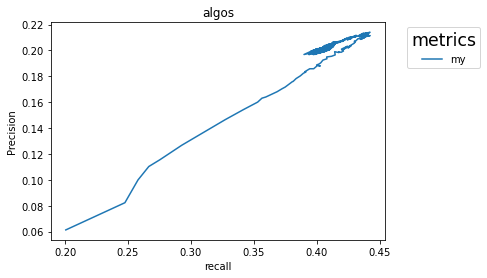

In [7]:
plt.plot(Precision, Recall, label='my')
    
plt.xlabel('recall')
plt.ylabel('Precision')
plt.title('algos')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='metrics', title_fontsize='xx-large')
#plt.ylim(ymin=0, ymax=1)
#plt.xlim(xmin=0, xmax=1)

plt.show()

In [10]:
with open('data.json') as f:
    d = json.load(f)
    print(d)

{'my': [0.20053023, 0.247508, 0.25790063, 0.2664901, 0.27529189, 0.29268309, 0.32714766, 0.34167561, 0.35302246, 0.3564159, 0.35949111, 0.36850473, 0.3723225, 0.37486753, 0.3806999, 0.38112399, 0.38356298, 0.38695651, 0.38939548, 0.39130458, 0.39045614, 0.39437982, 0.3975611, 0.40063629, 0.40275723, 0.39989403, 0.40180272, 0.40318137, 0.40487808, 0.40805963, 0.40784734, 0.41177109, 0.41463411, 0.41420993, 0.41760346, 0.41739139, 0.4193005, 0.4212091, 0.41961849, 0.42439035, 0.4201487, 0.42545104, 0.42492071, 0.42725372, 0.42587519, 0.42979875, 0.43032897, 0.43001077, 0.42990479, 0.43276796, 0.43499491, 0.43552503, 0.43700969, 0.43616134, 0.43552518, 0.43488884, 0.4377518, 0.43807027, 0.4408271, 0.43616146, 0.43563098, 0.43870634, 0.43626735, 0.43870649, 0.43870628, 0.43743375, 0.43934238, 0.43690372, 0.44241783, 0.43785819, 0.43796414, 0.44040298, 0.44008517, 0.44231164, 0.43849432, 0.43944857, 0.43626726, 0.4387064, 0.43679744, 0.43976679, 0.43997866, 0.44093314, 0.43902424, 0.4372216

In [12]:
from datetime import datetime
path = 'C:/Projects/NeuRec/results/'
with open(os.path.join(path, datetime.now().strftime('%Y%m%d%H%M%S') + 'results.json'), 'w', encoding='utf-8') as f:
    json.dump(d, f, ensure_ascii=False, indent=4)